# Training Flappy Bird AI Agents - Reinforcement Learning Practise
This notebook used Stable Baselines 3 to train a neural network to control the bird in the Flappy Bird environment from (https://github.com/markub3327/flappy-bird-gymnasium).

### actions:
- none (0)
- flap (1)

### Reward:
* +0.1 - every frame it stays alive
* +1.0 - successfully passing a pipe
* -1.0 - dying

### observation: 
#### vector based observations:
* the last pipe's horizontal position
* the last top pipe's vertical position
* the last bottom pipe's vertical position
* the next pipe's horizontal position
* the next top pipe's vertical position
* the next bottom pipe's vertical position
* the next next pipe's horizontal position
* the next next top pipe's vertical position
* the next next bottom pipe's vertical position
* player's vertical position
* player's vertical velocity
* player's rotation

#### And an RGB image based observations:
* A screenshot of the game without score (size 288 X 512 pixels)

### Initialisations

In [1]:
"""!apt install swig cmake ffmpeg
!apt-get install -y xvfb x11-utils
!pip install stable-baselines3[mpi]==2.0.0a1 box2d box2d-kengz
!pip install box2d-py
!pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate
!pip install flappy-bird-gymnasium"""

'!apt install swig cmake ffmpeg\n!apt-get install -y xvfb x11-utils\n!pip install stable-baselines3[mpi]==2.0.0a1 box2d box2d-kengz\n!pip install box2d-py\n!pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate\n!pip install flappy-bird-gymnasium'

Import required packages. 

In [2]:
import sys
import gymnasium
sys.modules["gym"] = gymnasium

In [3]:
import os
os.environ["SDL_AUDIODRIVER"] = "dummy"

In [4]:
import torch 
import gymnasium as gym
import stable_baselines3 as sb3
import flappy_bird_gymnasium

import pandas as pd # For data frames and data frame manipulation
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
import numpy as np # For general  numeric operations

import matplotlib.pyplot as plt
%matplotlib inline 

import time
from stable_baselines3.common.monitor import Monitor

### Creating and Viewing the Environment

#### Source: Codes are adopted from examples at lecture notes.

In [5]:
env = Monitor(gym.make('FlappyBird-v0'))

Exploring the environment -action and observation space.

In [6]:
env.action_space

Discrete(2)

In [7]:
env.observation_space

Box(-inf, inf, (12,), float64)

Playing an episode of the environment with random actions

In [8]:
obs = env.reset()
done = truncated = False
while not (done or truncated):
    action = env.action_space.sample()
    obs, reward, done, truncated, info  = env.step(action)
    env.render()
    time.sleep(0.05)

### Vector Agent
Creating PPO agent using a designed vector as the observation & monitoring training with tensorboard

In [9]:
%load_ext tensorboard

In [10]:
# Add code here
tb_log = './log_tb_flappy_bird_vector/'
agent = sb3.PPO('MlpPolicy', 
                env, 
                learning_rate = 3e-5,
                n_steps = 512,
                ent_coef = 0.001,
                batch_size = 128,
                gae_lambda = 0.9,
                n_epochs = 20,
                clip_range = 0.4,
                policy_kwargs = {'log_std_init': -2, 'ortho_init':False},
                verbose=1,
                tensorboard_log=tb_log,)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [11]:
# Viewing the agent network.
print(agent.policy)

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=12, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=12, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=2, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)


In [12]:
# evaluation callback to renders the episode with regular intervals.

eval_log_path = './log_flappy_bird_vector/'
eval_env= Monitor(gym.make('FlappyBird-v0'))

eval_env=sb3.common.vec_env.DummyVecEnv([lambda:eval_env])

eval_callback = sb3.common.callbacks.EvalCallback(eval_env , 
                                                  best_model_save_path=eval_log_path ,
                                                  log_path=eval_log_path , 
                                                  eval_freq=100,
                                                  render=True)

In [13]:
# Display TensorBoard
%tensorboard --logdir log_tb_flappy_bird_vector

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [14]:
# training model for 500000 timestep
agent.learn(total_timesteps=500000,
            reset_num_timesteps = True,
           callback = eval_callback)

2023-06-25 12:46:05.519500: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-25 12:46:05.554060: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 12:46:05.788718: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 12:46:05.791054: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 12:46:07.088078: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Logging to ./log_tb_flappy_bird_vector/PPO_1


/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:208: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Eval num_timesteps=100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 100      |
---------------------------------
New best mean reward!
Eval num_timesteps=200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 200      |
---------------------------------
Eval num_timesteps=300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 300      |
---------------------------------
Eval num_

Eval num_timesteps=1900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 1900     |
---------------------------------
Eval num_timesteps=2000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 200      |
|    iterations      | 4        |
|    time_elapsed    | 10       |
|    total_timesteps | 2048     |
---------------------------------
Eval num_tim

Eval num_timesteps=3600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 3600        |
| train/                  |             |
|    approx_kl            | 0.013836679 |
|    clip_fraction        | 0           |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.687      |
|    explained_variance   | 0.283       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.217       |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0058     |
|    value_loss           | 0.461       |
-----------------------------------------
Eval num_timesteps=3700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|   

Eval num_timesteps=5300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 5300     |
---------------------------------
Eval num_timesteps=5400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 5400     |
---------------------------------
Eval num_timesteps=5500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 5500     |
---------------------------------
Eval num_timesteps=5600, epi

Eval num_timesteps=7100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 7100     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 263      |
|    iterations      | 14       |
|    time_elapsed    | 27       |
|    total_timesteps | 7168     |
---------------------------------
Eval num_timesteps=7200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 101           |
|    mean_reward          | 9             |
| time/                   |               |
|    total_timesteps      | 72

Eval num_timesteps=8800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 8800        |
| train/                  |             |
|    approx_kl            | 0.007254055 |
|    clip_fraction        | 0           |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.541      |
|    explained_variance   | 0.65        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.266       |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00329    |
|    value_loss           | 0.529       |
-----------------------------------------
Eval num_timesteps=8900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|   

Eval num_timesteps=10400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 10400    |
---------------------------------
Eval num_timesteps=10500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 10500    |
---------------------------------
Eval num_timesteps=10600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 10600    |
---------------------------------
Eval num_timesteps=10700,

Eval num_timesteps=12200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 12200    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 276      |
|    iterations      | 24       |
|    time_elapsed    | 44       |
|    total_timesteps | 12288    |
---------------------------------
Eval num_timesteps=12300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 12300

Eval num_timesteps=13900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 13900        |
| train/                  |              |
|    approx_kl            | 0.0043164706 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.422       |
|    explained_variance   | 0.94         |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0728       |
|    n_updates            | 540          |
|    policy_gradient_loss | -0.0025      |
|    value_loss           | 0.171        |
------------------------------------------
Eval num_timesteps=14000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/           

Eval num_timesteps=15500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 15500    |
---------------------------------
Eval num_timesteps=15600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 15600    |
---------------------------------
Eval num_timesteps=15700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 15700    |
---------------------------------
Eval num_timesteps=15800,

Eval num_timesteps=17300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 17300    |
---------------------------------
Eval num_timesteps=17400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 17400    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 298      |
|    iterations      | 34       |
|    time_elapsed    | 58       |
|    total_timesteps | 17408    |
---------------------------------
Eval num_t

Eval num_timesteps=19000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 19000        |
| train/                  |              |
|    approx_kl            | 0.0005777996 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.407       |
|    explained_variance   | 0.975        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0275       |
|    n_updates            | 740          |
|    policy_gradient_loss | -0.00041     |
|    value_loss           | 0.105        |
------------------------------------------
Eval num_timesteps=19100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/           

Eval num_timesteps=20600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 20600    |
---------------------------------
Eval num_timesteps=20700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 20700    |
---------------------------------
Eval num_timesteps=20800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 20800    |
---------------------------------
Eval num_timesteps=20900,

Eval num_timesteps=22400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 22400    |
---------------------------------
Eval num_timesteps=22500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 22500    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 311      |
|    iterations      | 44       |
|    time_elapsed    | 72       |
|    total_timesteps | 22528    |
---------------------------------
Eval num_t

Eval num_timesteps=24100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 24100        |
| train/                  |              |
|    approx_kl            | 0.0049358695 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.384       |
|    explained_variance   | 0.987        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.00815      |
|    n_updates            | 940          |
|    policy_gradient_loss | -0.00337     |
|    value_loss           | 0.0504       |
------------------------------------------
Eval num_timesteps=24200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/           

Eval num_timesteps=25800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 25800    |
---------------------------------
Eval num_timesteps=25900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 25900    |
---------------------------------
Eval num_timesteps=26000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 26000    |
---------------------------------
Eval num_timesteps=26100,

Eval num_timesteps=27600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 27600    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 312      |
|    iterations      | 54       |
|    time_elapsed    | 88       |
|    total_timesteps | 27648    |
---------------------------------
Eval num_timesteps=27700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 27700

Eval num_timesteps=29200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 29200        |
| train/                  |              |
|    approx_kl            | 7.714756e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.555       |
|    explained_variance   | 0.99         |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0171       |
|    n_updates            | 1140         |
|    policy_gradient_loss | -0.000276    |
|    value_loss           | 0.0394       |
------------------------------------------
Eval num_timesteps=29300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/           

Eval num_timesteps=30900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 30900    |
---------------------------------
Eval num_timesteps=31000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 31000    |
---------------------------------
Eval num_timesteps=31100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 31100    |
---------------------------------
Eval num_timesteps=31200,

Eval num_timesteps=32700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 32700    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 315      |
|    iterations      | 64       |
|    time_elapsed    | 103      |
|    total_timesteps | 32768    |
---------------------------------
Eval num_timesteps=32800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 32800

Eval num_timesteps=34400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 34400        |
| train/                  |              |
|    approx_kl            | 8.047983e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.623       |
|    explained_variance   | 0.994        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0136       |
|    n_updates            | 1340         |
|    policy_gradient_loss | -0.00016     |
|    value_loss           | 0.0224       |
------------------------------------------
Eval num_timesteps=34500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/           

Eval num_timesteps=36000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 36000    |
---------------------------------
Eval num_timesteps=36100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 36100    |
---------------------------------
Eval num_timesteps=36200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 36200    |
---------------------------------
Eval num_timesteps=36300,

Eval num_timesteps=37800, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 37800    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 320      |
|    iterations      | 74       |
|    time_elapsed    | 118      |
|    total_timesteps | 37888    |
---------------------------------
Eval num_timesteps=37900, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 32          |
|    mean_reward          | 2.1         |
| time/                   |             |
|    total_timesteps      | 37900       

Eval num_timesteps=39500, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 32         |
|    mean_reward          | 2.1        |
| time/                   |            |
|    total_timesteps      | 39500      |
| train/                  |            |
|    approx_kl            | 0.00860051 |
|    clip_fraction        | 0          |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.552     |
|    explained_variance   | 0.993      |
|    learning_rate        | 3e-05      |
|    loss                 | -0.00549   |
|    n_updates            | 1540       |
|    policy_gradient_loss | -0.00424   |
|    value_loss           | 0.0293     |
----------------------------------------
Eval num_timesteps=39600, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  |

Eval num_timesteps=41100, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 41100    |
---------------------------------
Eval num_timesteps=41200, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 41200    |
---------------------------------
Eval num_timesteps=41300, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 41300    |
---------------------------------
Eval num_timesteps=41400, ep

Eval num_timesteps=42900, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 42900    |
---------------------------------
Eval num_timesteps=43000, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 43000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 97.2     |
|    ep_rew_mean     | 8.63     |
| time/              |          |
|    fps             | 336      |
|    iterations      | 84       |
|    time_elapsed    | 127      |
|    total_timesteps | 43008    |
---------------------------------
Eval num_tim

Eval num_timesteps=44600, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 32           |
|    mean_reward          | 2.1          |
| time/                   |              |
|    total_timesteps      | 44600        |
| train/                  |              |
|    approx_kl            | 0.0007128947 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.325       |
|    explained_variance   | 0.971        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.038        |
|    n_updates            | 1740         |
|    policy_gradient_loss | -0.000542    |
|    value_loss           | 0.108        |
------------------------------------------
Eval num_timesteps=44700, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/             

Eval num_timesteps=46200, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 46200    |
---------------------------------
Eval num_timesteps=46300, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 46300    |
---------------------------------
Eval num_timesteps=46400, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 46400    |
---------------------------------
Eval num_timesteps=46500, ep

Eval num_timesteps=48000, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 48000    |
---------------------------------
Eval num_timesteps=48100, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 48100    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.7     |
|    ep_rew_mean     | 8.39     |
| time/              |          |
|    fps             | 349      |
|    iterations      | 94       |
|    time_elapsed    | 137      |
|    total_timesteps | 48128    |
---------------------------------
Eval num_tim

Eval num_timesteps=49700, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 32           |
|    mean_reward          | 2.1          |
| time/                   |              |
|    total_timesteps      | 49700        |
| train/                  |              |
|    approx_kl            | 3.154343e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.23        |
|    explained_variance   | 0.878        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.171        |
|    n_updates            | 1940         |
|    policy_gradient_loss | -0.000294    |
|    value_loss           | 0.47         |
------------------------------------------
Eval num_timesteps=49800, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/             

Eval num_timesteps=51400, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 51400    |
---------------------------------
Eval num_timesteps=51500, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 51500    |
---------------------------------
Eval num_timesteps=51600, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 51600    |
---------------------------------
Eval num_timesteps=51700, ep

Eval num_timesteps=53200, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 53200    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 97.1     |
|    ep_rew_mean     | 8.66     |
| time/              |          |
|    fps             | 360      |
|    iterations      | 104      |
|    time_elapsed    | 147      |
|    total_timesteps | 53248    |
---------------------------------
Eval num_timesteps=53300, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 32            |
|    mean_reward          | 2.1           |
| time/                   |               |
|    total_timesteps      | 53

Eval num_timesteps=54900, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 54900    |
---------------------------------
Eval num_timesteps=55000, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 55000    |
---------------------------------
Eval num_timesteps=55100, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 55100    |
---------------------------------
Eval num_timesteps=55200, ep

Eval num_timesteps=56700, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 56700    |
---------------------------------
Eval num_timesteps=56800, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 56800    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 98.1     |
|    ep_rew_mean     | 8.76     |
| time/              |          |
|    fps             | 371      |
|    iterations      | 111      |
|    time_elapsed    | 153      |
|    total_timesteps | 56832    |
---------------------------------
Eval num_tim

Eval num_timesteps=58400, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 32            |
|    mean_reward          | 2.1           |
| time/                   |               |
|    total_timesteps      | 58400         |
| train/                  |               |
|    approx_kl            | 1.9564643e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.296        |
|    explained_variance   | 0.97          |
|    learning_rate        | 3e-05         |
|    loss                 | 0.0928        |
|    n_updates            | 2280          |
|    policy_gradient_loss | -6.3e-06      |
|    value_loss           | 0.134         |
-------------------------------------------
Eval num_timesteps=58500, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| 

Eval num_timesteps=60100, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 60100    |
---------------------------------
Eval num_timesteps=60200, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 60200    |
---------------------------------
Eval num_timesteps=60300, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 60300    |
---------------------------------
Eval num_timesteps=60400, ep

Eval num_timesteps=61900, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 61900    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 97.1     |
|    ep_rew_mean     | 8.66     |
| time/              |          |
|    fps             | 384      |
|    iterations      | 121      |
|    time_elapsed    | 160      |
|    total_timesteps | 61952    |
---------------------------------
Eval num_timesteps=62000, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 70          |
|    mean_reward          | 5.9         |
| time/                   |             |
|    total_timesteps      | 62000       

Eval num_timesteps=63600, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 63600    |
---------------------------------
Eval num_timesteps=63700, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 63700    |
---------------------------------
Eval num_timesteps=63800, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 63800    |
---------------------------------
Eval num_timesteps=63900, ep

Eval num_timesteps=65400, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 65400    |
---------------------------------
Eval num_timesteps=65500, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 65500    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 97       |
|    ep_rew_mean     | 8.65     |
| time/              |          |
|    fps             | 391      |
|    iterations      | 128      |
|    time_elapsed    | 167      |
|    total_timesteps | 65536    |
---------------------------------
Eval num_tim

Eval num_timesteps=67100, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 32           |
|    mean_reward          | 2.1          |
| time/                   |              |
|    total_timesteps      | 67100        |
| train/                  |              |
|    approx_kl            | 0.0023153313 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.167       |
|    explained_variance   | 0.967        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0724       |
|    n_updates            | 2620         |
|    policy_gradient_loss | -0.00192     |
|    value_loss           | 0.135        |
------------------------------------------
Eval num_timesteps=67200, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/             

Eval num_timesteps=68800, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 68800    |
---------------------------------
Eval num_timesteps=68900, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 68900    |
---------------------------------
Eval num_timesteps=69000, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 69000    |
---------------------------------
Eval num_timesteps=69100, ep

Eval num_timesteps=70600, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 70600    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | 9.01     |
| time/              |          |
|    fps             | 395      |
|    iterations      | 138      |
|    time_elapsed    | 178      |
|    total_timesteps | 70656    |
---------------------------------
Eval num_timesteps=70700, episode_reward=4.00 +/- 0.00
Episode length: 51.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 51          |
|    mean_reward          | 4           |
| time/                   |             |
|    total_timesteps      | 70700       

Eval num_timesteps=72300, episode_reward=4.00 +/- 0.00
Episode length: 51.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 51       |
|    mean_reward     | 4        |
| time/              |          |
|    total_timesteps | 72300    |
---------------------------------
Eval num_timesteps=72400, episode_reward=4.00 +/- 0.00
Episode length: 51.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 51       |
|    mean_reward     | 4        |
| time/              |          |
|    total_timesteps | 72400    |
---------------------------------
Eval num_timesteps=72500, episode_reward=4.00 +/- 0.00
Episode length: 51.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 51       |
|    mean_reward     | 4        |
| time/              |          |
|    total_timesteps | 72500    |
---------------------------------
Eval num_timesteps=72600, ep

Eval num_timesteps=74100, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 74100    |
---------------------------------
Eval num_timesteps=74200, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 74200    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 9.16     |
| time/              |          |
|    fps             | 403      |
|    iterations      | 145      |
|    time_elapsed    | 184      |
|    total_timesteps | 74240    |
---------------------------------
Eval num_tim

Eval num_timesteps=75800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 101        |
|    mean_reward          | 9          |
| time/                   |            |
|    total_timesteps      | 75800      |
| train/                  |            |
|    approx_kl            | 0.01906308 |
|    clip_fraction        | 0.0258     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.191     |
|    explained_variance   | 0.962      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0736     |
|    n_updates            | 2960       |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 0.164      |
----------------------------------------
Eval num_timesteps=75900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length 

Eval num_timesteps=77500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 77500    |
---------------------------------
Eval num_timesteps=77600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 77600    |
---------------------------------
Eval num_timesteps=77700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 77700    |
---------------------------------
Eval num_timesteps=77800,

Eval num_timesteps=79300, episode_reward=8.04 +/- 0.48
Episode length: 91.40 +/- 4.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 91.4     |
|    mean_reward     | 8.04     |
| time/              |          |
|    total_timesteps | 79300    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 103      |
|    ep_rew_mean     | 9.25     |
| time/              |          |
|    fps             | 401      |
|    iterations      | 155      |
|    time_elapsed    | 197      |
|    total_timesteps | 79360    |
---------------------------------
Eval num_timesteps=79400, episode_reward=8.76 +/- 0.48
Episode length: 98.60 +/- 4.80
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 98.6          |
|    mean_reward          | 8.76          |
| time/                   |               |
|    total_timesteps      | 79

Eval num_timesteps=81000, episode_reward=7.80 +/- 0.00
Episode length: 89.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 89       |
|    mean_reward     | 7.8      |
| time/              |          |
|    total_timesteps | 81000    |
---------------------------------
Eval num_timesteps=81100, episode_reward=7.80 +/- 0.00
Episode length: 89.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 89       |
|    mean_reward     | 7.8      |
| time/              |          |
|    total_timesteps | 81100    |
---------------------------------
Eval num_timesteps=81200, episode_reward=7.80 +/- 0.00
Episode length: 89.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 89       |
|    mean_reward     | 7.8      |
| time/              |          |
|    total_timesteps | 81200    |
---------------------------------
Eval num_timesteps=81300, ep

Eval num_timesteps=82800, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 82800    |
---------------------------------
Eval num_timesteps=82900, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 82900    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | 9.34     |
| time/              |          |
|    fps             | 397      |
|    iterations      | 162      |
|    time_elapsed    | 208      |
|    total_timesteps | 82944    |
---------------------------------
Eval num_tim

Eval num_timesteps=84500, episode_reward=7.80 +/- 0.00
Episode length: 89.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 89          |
|    mean_reward          | 7.8         |
| time/                   |             |
|    total_timesteps      | 84500       |
| train/                  |             |
|    approx_kl            | 0.005551105 |
|    clip_fraction        | 0.00156     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.112      |
|    explained_variance   | 0.965       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0884      |
|    n_updates            | 3300        |
|    policy_gradient_loss | -0.00375    |
|    value_loss           | 0.16        |
-----------------------------------------
Eval num_timesteps=84600, episode_reward=7.80 +/- 0.00
Episode length: 89.00 +/- 0.00
---------------------------------
| eval/              |          |
|   

Eval num_timesteps=86200, episode_reward=7.80 +/- 0.00
Episode length: 89.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 89       |
|    mean_reward     | 7.8      |
| time/              |          |
|    total_timesteps | 86200    |
---------------------------------
Eval num_timesteps=86300, episode_reward=7.80 +/- 0.00
Episode length: 89.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 89       |
|    mean_reward     | 7.8      |
| time/              |          |
|    total_timesteps | 86300    |
---------------------------------
Eval num_timesteps=86400, episode_reward=7.80 +/- 0.00
Episode length: 89.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 89       |
|    mean_reward     | 7.8      |
| time/              |          |
|    total_timesteps | 86400    |
---------------------------------
Eval num_timesteps=86500, ep

Eval num_timesteps=87900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 87900    |
---------------------------------
Eval num_timesteps=88000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 88000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | 9.82     |
| time/              |          |
|    fps             | 394      |
|    iterations      | 172      |
|    time_elapsed    | 223      |
|    total_timesteps | 88064    |
---------------------------------
Eval num_t

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | 9.88     |
| time/              |          |
|    fps             | 391      |
|    iterations      | 175      |
|    time_elapsed    | 228      |
|    total_timesteps | 89600    |
---------------------------------
Eval num_timesteps=89700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 89700        |
| train/                  |              |
|    approx_kl            | 0.0012322904 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.16        |
|    explained_variance   | 0.955        |
|    learning_rate        | 3e-05        |
|    loss     

Eval num_timesteps=91300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 91300    |
---------------------------------
Eval num_timesteps=91400, episode_reward=10.06 +/- 1.30
Episode length: 108.00 +/- 8.58
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 91400    |
---------------------------------
Eval num_timesteps=91500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 91500    |
---------------------------------
Eval num_timesteps=91600

Eval num_timesteps=93100, episode_reward=4.00 +/- 0.00
Episode length: 51.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 51       |
|    mean_reward     | 4        |
| time/              |          |
|    total_timesteps | 93100    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 106      |
|    ep_rew_mean     | 9.68     |
| time/              |          |
|    fps             | 391      |
|    iterations      | 182      |
|    time_elapsed    | 237      |
|    total_timesteps | 93184    |
---------------------------------
Eval num_timesteps=93200, episode_reward=8.76 +/- 0.48
Episode length: 98.60 +/- 4.80
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 98.6        |
|    mean_reward          | 8.76        |
| time/                   |             |
|    total_timesteps      | 93200       

Eval num_timesteps=94800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 94800        |
| train/                  |              |
|    approx_kl            | 0.0030386583 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0998      |
|    explained_variance   | 0.954        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0982       |
|    n_updates            | 3700         |
|    policy_gradient_loss | -0.00199     |
|    value_loss           | 0.208        |
------------------------------------------
Eval num_timesteps=94900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/           

Eval num_timesteps=96400, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 96400    |
---------------------------------
Eval num_timesteps=96500, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 96500    |
---------------------------------
Eval num_timesteps=96600, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 96600    |
---------------------------------
Eval num_timesteps=96700, ep

Eval num_timesteps=98200, episode_reward=8.76 +/- 0.48
Episode length: 98.60 +/- 4.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 98.6     |
|    mean_reward     | 8.76     |
| time/              |          |
|    total_timesteps | 98200    |
---------------------------------
Eval num_timesteps=98300, episode_reward=8.52 +/- 0.59
Episode length: 96.20 +/- 5.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 96.2     |
|    mean_reward     | 8.52     |
| time/              |          |
|    total_timesteps | 98300    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 106      |
|    ep_rew_mean     | 9.65     |
| time/              |          |
|    fps             | 385      |
|    iterations      | 192      |
|    time_elapsed    | 254      |
|    total_timesteps | 98304    |
---------------------------------
Eval num_tim

Eval num_timesteps=99900, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 70           |
|    mean_reward          | 5.9          |
| time/                   |              |
|    total_timesteps      | 99900        |
| train/                  |              |
|    approx_kl            | 0.0067436406 |
|    clip_fraction        | 0.00322      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.113       |
|    explained_variance   | 0.936        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.144        |
|    n_updates            | 3900         |
|    policy_gradient_loss | -0.00396     |
|    value_loss           | 0.268        |
------------------------------------------
Eval num_timesteps=100000, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/            

Eval num_timesteps=101500, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 101500   |
---------------------------------
Eval num_timesteps=101600, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 101600   |
---------------------------------
Eval num_timesteps=101700, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 101700   |
---------------------------------
Eval num_timesteps=101800

Eval num_timesteps=103300, episode_reward=8.52 +/- 0.59
Episode length: 96.20 +/- 5.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 96.2     |
|    mean_reward     | 8.52     |
| time/              |          |
|    total_timesteps | 103300   |
---------------------------------
Eval num_timesteps=103400, episode_reward=8.52 +/- 0.59
Episode length: 96.20 +/- 5.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 96.2     |
|    mean_reward     | 8.52     |
| time/              |          |
|    total_timesteps | 103400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 107      |
|    ep_rew_mean     | 9.77     |
| time/              |          |
|    fps             | 388      |
|    iterations      | 202      |
|    time_elapsed    | 265      |
|    total_timesteps | 103424   |
---------------------------------
Eval num_t

Eval num_timesteps=105000, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 70           |
|    mean_reward          | 5.9          |
| time/                   |              |
|    total_timesteps      | 105000       |
| train/                  |              |
|    approx_kl            | 0.0047871796 |
|    clip_fraction        | 0.00557      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.139       |
|    explained_variance   | 0.913        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.185        |
|    n_updates            | 4100         |
|    policy_gradient_loss | -0.00276     |
|    value_loss           | 0.362        |
------------------------------------------
Eval num_timesteps=105100, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/           

Eval num_timesteps=106600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 106600   |
---------------------------------
Eval num_timesteps=106700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 106700   |
---------------------------------
Eval num_timesteps=106800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 106800   |
---------------------------------
Eval num_timesteps=106

Eval num_timesteps=108300, episode_reward=10.40 +/- 1.83
Episode length: 111.40 +/- 14.22
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 108300   |
---------------------------------
Eval num_timesteps=108400, episode_reward=11.88 +/- 5.76
Episode length: 124.40 +/- 46.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 11.9     |
| time/              |          |
|    total_timesteps | 108400   |
---------------------------------
Eval num_timesteps=108500, episode_reward=10.94 +/- 2.39
Episode length: 116.80 +/- 19.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 10.9     |
| time/              |          |
|    total_timesteps | 108500   |
---------------------------------
----------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 106      |
|    ep_rew_mean     | 9.66     |
| time/              |          |
|    fps             | 383      |
|    iterations      | 215      |
|    time_elapsed    | 287      |
|    total_timesteps | 110080   |
---------------------------------
Eval num_timesteps=110100, episode_reward=11.00 +/- 2.07
Episode length: 117.40 +/- 16.41
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 117          |
|    mean_reward          | 11           |
| time/                   |              |
|    total_timesteps      | 110100       |
| train/                  |              |
|    approx_kl            | 0.0026745894 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.135       |
|    explained_variance   | 0.965        |
|    learning_rate        | 3e-05        |
|    loss  

Eval num_timesteps=111700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 111700      |
| train/                  |             |
|    approx_kl            | 0.008199444 |
|    clip_fraction        | 0.00977     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.111      |
|    explained_variance   | 0.96        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0752      |
|    n_updates            | 4360        |
|    policy_gradient_loss | -0.00596    |
|    value_loss           | 0.171       |
-----------------------------------------
Eval num_timesteps=111800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |


Eval num_timesteps=113300, episode_reward=11.50 +/- 2.07
Episode length: 122.40 +/- 16.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 122      |
|    mean_reward     | 11.5     |
| time/              |          |
|    total_timesteps | 113300   |
---------------------------------
Eval num_timesteps=113400, episode_reward=9.80 +/- 0.98
Episode length: 105.40 +/- 5.39
---------------------------------
| eval/              |          |
|    mean_ep_length  | 105      |
|    mean_reward     | 9.8      |
| time/              |          |
|    total_timesteps | 113400   |
---------------------------------
Eval num_timesteps=113500, episode_reward=11.12 +/- 1.85
Episode length: 116.80 +/- 15.70
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11.1     |
| time/              |          |
|    total_timesteps | 113500   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=115100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 115100   |
---------------------------------
Eval num_timesteps=115200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 115200   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 9.99     |
| time/              |          |
|    fps             | 379      |
|    iterations      | 225      |
|    time_elapsed    | 303      |
|    total_timesteps | 115200   |
---------------------------------
Eval num

Eval num_timesteps=116800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 101           |
|    mean_reward          | 9             |
| time/                   |               |
|    total_timesteps      | 116800        |
| train/                  |               |
|    approx_kl            | 0.00078673003 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.118        |
|    explained_variance   | 0.932         |
|    learning_rate        | 3e-05         |
|    loss                 | 0.151         |
|    n_updates            | 4560          |
|    policy_gradient_loss | -0.000465     |
|    value_loss           | 0.239         |
-------------------------------------------
Eval num_timesteps=116900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
--------------------------------

Eval num_timesteps=118400, episode_reward=11.74 +/- 3.36
Episode length: 121.20 +/- 24.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 121      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 118400   |
---------------------------------
Eval num_timesteps=118500, episode_reward=9.48 +/- 0.96
Episode length: 104.00 +/- 6.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 104      |
|    mean_reward     | 9.48     |
| time/              |          |
|    total_timesteps | 118500   |
---------------------------------
Eval num_timesteps=118600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 118600   |
---------------------------------
Eval num_timesteps=1

Eval num_timesteps=120200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 120200   |
---------------------------------
Eval num_timesteps=120300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 120300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 10.1     |
| time/              |          |
|    fps             | 380      |
|    iterations      | 235      |
|    time_elapsed    | 315      |
|    total_timesteps | 120320   |
---------------------------------
Eval num

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 110      |
|    ep_rew_mean     | 10.2     |
| time/              |          |
|    fps             | 381      |
|    iterations      | 238      |
|    time_elapsed    | 319      |
|    total_timesteps | 121856   |
---------------------------------
Eval num_timesteps=121900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 121900      |
| train/                  |             |
|    approx_kl            | 0.001226209 |
|    clip_fraction        | 0           |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.118      |
|    explained_variance   | 0.939       |
|    learning_rate        | 3e-05       |
|    loss                 

Eval num_timesteps=123500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 123500   |
---------------------------------
Eval num_timesteps=123600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 123600   |
---------------------------------
Eval num_timesteps=123700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 123700   |
---------------------------------
Eval num_timesteps=123

Eval num_timesteps=125300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 125300   |
---------------------------------
Eval num_timesteps=125400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 125400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 111      |
|    ep_rew_mean     | 10.2     |
| time/              |          |
|    fps             | 380      |
|    iterations      | 245      |
|    time_elapsed    | 330      |
|    total_timesteps | 125440   |
---------------------------------
Eval num

Eval num_timesteps=127000, episode_reward=12.16 +/- 3.36
Episode length: 125.40 +/- 27.20
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 125           |
|    mean_reward          | 12.2          |
| time/                   |               |
|    total_timesteps      | 127000        |
| train/                  |               |
|    approx_kl            | 2.0747422e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.104        |
|    explained_variance   | 0.947         |
|    learning_rate        | 3e-05         |
|    loss                 | 0.108         |
|    n_updates            | 4960          |
|    policy_gradient_loss | -3.85e-06     |
|    value_loss           | 0.26          |
-------------------------------------------
Eval num_timesteps=127100, episode_reward=11.32 +/- 2.89
Episode length: 118.80 +/- 21.91
----------------------------

Eval num_timesteps=128700, episode_reward=13.56 +/- 3.90
Episode length: 135.80 +/- 30.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 136      |
|    mean_reward     | 13.6     |
| time/              |          |
|    total_timesteps | 128700   |
---------------------------------
Eval num_timesteps=128800, episode_reward=10.28 +/- 2.10
Episode length: 112.00 +/- 17.44
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 128800   |
---------------------------------
Eval num_timesteps=128900, episode_reward=14.00 +/- 6.95
Episode length: 140.20 +/- 56.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 140      |
|    mean_reward     | 14       |
| time/              |          |
|    total_timesteps | 128900   |
---------------------------------
Eval num_timeste

Eval num_timesteps=130500, episode_reward=10.50 +/- 1.72
Episode length: 112.40 +/- 13.35
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 130500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 110      |
|    ep_rew_mean     | 10.2     |
| time/              |          |
|    fps             | 373      |
|    iterations      | 255      |
|    time_elapsed    | 349      |
|    total_timesteps | 130560   |
---------------------------------
Eval num_timesteps=130600, episode_reward=11.00 +/- 1.92
Episode length: 115.60 +/- 15.62
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 116          |
|    mean_reward          | 11           |
| time/                   |              |
|    total_timesteps      |

Eval num_timesteps=132100, episode_reward=9.92 +/- 1.84
Episode length: 108.40 +/- 14.80
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 108          |
|    mean_reward          | 9.92         |
| time/                   |              |
|    total_timesteps      | 132100       |
| train/                  |              |
|    approx_kl            | 0.0002945062 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0914      |
|    explained_variance   | 0.94         |
|    learning_rate        | 3e-05        |
|    loss                 | 0.118        |
|    n_updates            | 5160         |
|    policy_gradient_loss | -0.000184    |
|    value_loss           | 0.248        |
------------------------------------------
Eval num_timesteps=132200, episode_reward=10.50 +/- 2.11
Episode length: 112.40 +/- 17.43
---------------------------------
| eval/      

Eval num_timesteps=133800, episode_reward=10.26 +/- 2.06
Episode length: 111.80 +/- 17.05
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 133800   |
---------------------------------
Eval num_timesteps=133900, episode_reward=11.70 +/- 2.20
Episode length: 122.60 +/- 17.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 133900   |
---------------------------------
Eval num_timesteps=134000, episode_reward=11.14 +/- 3.80
Episode length: 118.80 +/- 30.84
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.1     |
| time/              |          |
|    total_timesteps | 134000   |
---------------------------------
Eval num_timeste

Eval num_timesteps=135600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 135600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 10.1     |
| time/              |          |
|    fps             | 370      |
|    iterations      | 265      |
|    time_elapsed    | 366      |
|    total_timesteps | 135680   |
---------------------------------
Eval num_timesteps=135700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 101           |
|    mean_reward          | 9             |
| time/                   |               |
|    total_timesteps      

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 111      |
|    ep_rew_mean     | 10.2     |
| time/              |          |
|    fps             | 369      |
|    iterations      | 268      |
|    time_elapsed    | 371      |
|    total_timesteps | 137216   |
---------------------------------
Eval num_timesteps=137300, episode_reward=10.92 +/- 2.83
Episode length: 114.80 +/- 21.30
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 115          |
|    mean_reward          | 10.9         |
| time/                   |              |
|    total_timesteps      | 137300       |
| train/                  |              |
|    approx_kl            | 0.0004045242 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0905      |
|    explained_variance   | 0.956        |
|    learning_rate        | 3e-05        |
|    loss  

Eval num_timesteps=138900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 138900   |
---------------------------------
Eval num_timesteps=139000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 139000   |
---------------------------------
Eval num_timesteps=139100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 139100   |
---------------------------------
Eval num_timesteps=139

Eval num_timesteps=140700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 140700   |
---------------------------------
Eval num_timesteps=140800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 140800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 9.96     |
| time/              |          |
|    fps             | 368      |
|    iterations      | 275      |
|    time_elapsed    | 381      |
|    total_timesteps | 140800   |
---------------------------------
Eval num

Eval num_timesteps=142400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 142400      |
| train/                  |             |
|    approx_kl            | 0.006777754 |
|    clip_fraction        | 0.00537     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0862     |
|    explained_variance   | 0.94        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.122       |
|    n_updates            | 5560        |
|    policy_gradient_loss | -0.00426    |
|    value_loss           | 0.303       |
-----------------------------------------
Eval num_timesteps=142500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |


Eval num_timesteps=144000, episode_reward=7.04 +/- 0.93
Episode length: 81.40 +/- 9.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 81.4     |
|    mean_reward     | 7.04     |
| time/              |          |
|    total_timesteps | 144000   |
---------------------------------
Eval num_timesteps=144100, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 144100   |
---------------------------------
Eval num_timesteps=144200, episode_reward=6.28 +/- 0.76
Episode length: 73.80 +/- 7.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 73.8     |
|    mean_reward     | 6.28     |
| time/              |          |
|    total_timesteps | 144200   |
---------------------------------
Eval num_timesteps=144300

Eval num_timesteps=145800, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 145800   |
---------------------------------
Eval num_timesteps=145900, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 145900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 106      |
|    ep_rew_mean     | 9.68     |
| time/              |          |
|    fps             | 366      |
|    iterations      | 285      |
|    time_elapsed    | 397      |
|    total_timesteps | 145920   |
---------------------------------
Eval num_t

Eval num_timesteps=147500, episode_reward=11.32 +/- 4.64
Episode length: 118.80 +/- 35.60
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 119          |
|    mean_reward          | 11.3         |
| time/                   |              |
|    total_timesteps      | 147500       |
| train/                  |              |
|    approx_kl            | 0.0036947345 |
|    clip_fraction        | 0.00273      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.102       |
|    explained_variance   | 0.945        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.109        |
|    n_updates            | 5760         |
|    policy_gradient_loss | -0.00148     |
|    value_loss           | 0.264        |
------------------------------------------
Eval num_timesteps=147600, episode_reward=10.34 +/- 2.68
Episode length: 110.80 +/- 19.60
---------------------------------
| eval/     

Eval num_timesteps=149100, episode_reward=10.80 +/- 2.20
Episode length: 115.40 +/- 17.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 10.8     |
| time/              |          |
|    total_timesteps | 149100   |
---------------------------------
Eval num_timesteps=149200, episode_reward=11.14 +/- 1.43
Episode length: 115.20 +/- 11.82
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 11.1     |
| time/              |          |
|    total_timesteps | 149200   |
---------------------------------
Eval num_timesteps=149300, episode_reward=12.18 +/- 2.69
Episode length: 125.60 +/- 20.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 126      |
|    mean_reward     | 12.2     |
| time/              |          |
|    total_timesteps | 149300   |
---------------------------------
Eval num_timeste

Eval num_timesteps=150800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 150800   |
---------------------------------
Eval num_timesteps=150900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 150900   |
---------------------------------
Eval num_timesteps=151000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 151000   |
---------------------------------
----------------------

Eval num_timesteps=152500, episode_reward=11.52 +/- 1.84
Episode length: 120.80 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 121      |
|    mean_reward     | 11.5     |
| time/              |          |
|    total_timesteps | 152500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 10       |
| time/              |          |
|    fps             | 365      |
|    iterations      | 298      |
|    time_elapsed    | 416      |
|    total_timesteps | 152576   |
---------------------------------
Eval num_timesteps=152600, episode_reward=12.96 +/- 1.65
Episode length: 133.40 +/- 12.97
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 133           |
|    mean_reward          | 13            |
| time/                   |               |
|    total_timesteps  

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 10       |
| time/              |          |
|    fps             | 366      |
|    iterations      | 301      |
|    time_elapsed    | 420      |
|    total_timesteps | 154112   |
---------------------------------
Eval num_timesteps=154200, episode_reward=11.74 +/- 3.25
Episode length: 121.20 +/- 26.35
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 121         |
|    mean_reward          | 11.7        |
| time/                   |             |
|    total_timesteps      | 154200      |
| train/                  |             |
|    approx_kl            | 0.003943314 |
|    clip_fraction        | 0.00723     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.106      |
|    explained_variance   | 0.932       |
|    learning_rate        | 3e-05       |
|    loss               

Eval num_timesteps=155800, episode_reward=10.34 +/- 1.78
Episode length: 112.60 +/- 14.35
---------------------------------
| eval/              |          |
|    mean_ep_length  | 113      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 155800   |
---------------------------------
Eval num_timesteps=155900, episode_reward=10.80 +/- 3.60
Episode length: 115.40 +/- 28.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 10.8     |
| time/              |          |
|    total_timesteps | 155900   |
---------------------------------
Eval num_timesteps=156000, episode_reward=9.86 +/- 0.88
Episode length: 107.80 +/- 5.91
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.86     |
| time/              |          |
|    total_timesteps | 156000   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=157600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 157600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    fps             | 366      |
|    iterations      | 308      |
|    time_elapsed    | 429      |
|    total_timesteps | 157696   |
---------------------------------
Eval num_timesteps=157700, episode_reward=9.50 +/- 1.00
Episode length: 104.20 +/- 6.40
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 104         |
|    mean_reward          | 9.5         |
| time/                   |             |
|    total_timesteps      | 157700  

Eval num_timesteps=159300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 159300       |
| train/                  |              |
|    approx_kl            | 0.0097724525 |
|    clip_fraction        | 0.0182       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0826      |
|    explained_variance   | 0.912        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.172        |
|    n_updates            | 6220         |
|    policy_gradient_loss | -0.00667     |
|    value_loss           | 0.367        |
------------------------------------------
Eval num_timesteps=159400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/         

Eval num_timesteps=160900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 160900   |
---------------------------------
Eval num_timesteps=161000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 161000   |
---------------------------------
Eval num_timesteps=161100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 161100   |
---------------------------------
Eval num_timesteps=161

Eval num_timesteps=162700, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 162700   |
---------------------------------
Eval num_timesteps=162800, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 70       |
|    mean_reward     | 5.9      |
| time/              |          |
|    total_timesteps | 162800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 111      |
|    ep_rew_mean     | 10.3     |
| time/              |          |
|    fps             | 362      |
|    iterations      | 318      |
|    time_elapsed    | 449      |
|    total_timesteps | 162816   |
---------------------------------
Eval num_t

Eval num_timesteps=164400, episode_reward=6.90 +/- 1.28
Episode length: 80.00 +/- 12.82
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 80           |
|    mean_reward          | 6.9          |
| time/                   |              |
|    total_timesteps      | 164400       |
| train/                  |              |
|    approx_kl            | 0.0049714595 |
|    clip_fraction        | 0.00166      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0901      |
|    explained_variance   | 0.952        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.086        |
|    n_updates            | 6420         |
|    policy_gradient_loss | -0.00183     |
|    value_loss           | 0.254        |
------------------------------------------
Eval num_timesteps=164500, episode_reward=7.52 +/- 1.39
Episode length: 86.20 +/- 13.93
---------------------------------
| eval/         

Eval num_timesteps=166000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 166000   |
---------------------------------
Eval num_timesteps=166100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 166100   |
---------------------------------
Eval num_timesteps=166200, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 166200   |
---------------------------------
Eval num_timesteps=16

Eval num_timesteps=167700, episode_reward=9.40 +/- 0.45
Episode length: 105.00 +/- 4.52
---------------------------------
| eval/              |          |
|    mean_ep_length  | 105      |
|    mean_reward     | 9.4      |
| time/              |          |
|    total_timesteps | 167700   |
---------------------------------
Eval num_timesteps=167800, episode_reward=9.66 +/- 0.97
Episode length: 105.80 +/- 6.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.66     |
| time/              |          |
|    total_timesteps | 167800   |
---------------------------------
Eval num_timesteps=167900, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 167900   |
---------------------------------
---------------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 107      |
|    ep_rew_mean     | 9.88     |
| time/              |          |
|    fps             | 361      |
|    iterations      | 331      |
|    time_elapsed    | 469      |
|    total_timesteps | 169472   |
---------------------------------
Eval num_timesteps=169500, episode_reward=9.50 +/- 1.00
Episode length: 104.20 +/- 6.40
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 104          |
|    mean_reward          | 9.5          |
| time/                   |              |
|    total_timesteps      | 169500       |
| train/                  |              |
|    approx_kl            | 0.0049967775 |
|    clip_fraction        | 0.00498      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0879      |
|    explained_variance   | 0.932        |
|    learning_rate        | 3e-05        |
|    loss    

Eval num_timesteps=171200, episode_reward=10.10 +/- 1.02
Episode length: 108.40 +/- 6.37
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 171200   |
---------------------------------
Eval num_timesteps=171300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 171300   |
---------------------------------
Eval num_timesteps=171400, episode_reward=10.42 +/- 1.84
Episode length: 111.60 +/- 14.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 171400   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=172900, episode_reward=10.98 +/- 3.53
Episode length: 117.20 +/- 28.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 172900   |
---------------------------------
Eval num_timesteps=173000, episode_reward=12.60 +/- 3.37
Episode length: 129.80 +/- 26.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 130      |
|    mean_reward     | 12.6     |
| time/              |          |
|    total_timesteps | 173000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 111      |
|    ep_rew_mean     | 10.3     |
| time/              |          |
|    fps             | 361      |
|    iterations      | 338      |
|    time_elapsed    | 478      |
|    total_timesteps | 173056   |
---------------------------------
Eval

Eval num_timesteps=174600, episode_reward=10.46 +/- 1.72
Episode length: 112.00 +/- 13.39
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 112         |
|    mean_reward          | 10.5        |
| time/                   |             |
|    total_timesteps      | 174600      |
| train/                  |             |
|    approx_kl            | 0.002179957 |
|    clip_fraction        | 9.77e-05    |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0831     |
|    explained_variance   | 0.941       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.116       |
|    n_updates            | 6820        |
|    policy_gradient_loss | -0.00112    |
|    value_loss           | 0.275       |
-----------------------------------------
Eval num_timesteps=174700, episode_reward=9.84 +/- 0.95
Episode length: 105.80 +/- 5.11
---------------------------------
| eval/              |          

Eval num_timesteps=176300, episode_reward=10.80 +/- 2.20
Episode length: 115.40 +/- 17.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 10.8     |
| time/              |          |
|    total_timesteps | 176300   |
---------------------------------
Eval num_timesteps=176400, episode_reward=10.06 +/- 1.75
Episode length: 109.80 +/- 13.95
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 176400   |
---------------------------------
Eval num_timesteps=176500, episode_reward=11.82 +/- 2.07
Episode length: 123.80 +/- 16.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 176500   |
---------------------------------
Eval num_timeste

Eval num_timesteps=178000, episode_reward=10.00 +/- 1.00
Episode length: 107.40 +/- 5.82
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 10       |
| time/              |          |
|    total_timesteps | 178000   |
---------------------------------
Eval num_timesteps=178100, episode_reward=9.54 +/- 0.81
Episode length: 104.60 +/- 4.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 105      |
|    mean_reward     | 9.54     |
| time/              |          |
|    total_timesteps | 178100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    fps             | 361      |
|    iterations      | 348      |
|    time_elapsed    | 492      |
|    total_timesteps | 178176   |
---------------------------------
Eval nu

Eval num_timesteps=179700, episode_reward=12.78 +/- 3.19
Episode length: 131.60 +/- 25.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 132      |
|    mean_reward     | 12.8     |
| time/              |          |
|    total_timesteps | 179700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    fps             | 361      |
|    iterations      | 351      |
|    time_elapsed    | 497      |
|    total_timesteps | 179712   |
---------------------------------
Eval num_timesteps=179800, episode_reward=9.52 +/- 0.85
Episode length: 104.40 +/- 4.92
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 104         |
|    mean_reward          | 9.52        |
| time/                   |             |
|    total_timesteps      | 179800

Eval num_timesteps=181400, episode_reward=10.72 +/- 1.73
Episode length: 114.60 +/- 13.23
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 10.7     |
| time/              |          |
|    total_timesteps | 181400   |
---------------------------------
Eval num_timesteps=181500, episode_reward=11.64 +/- 2.54
Episode length: 122.00 +/- 18.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 122      |
|    mean_reward     | 11.6     |
| time/              |          |
|    total_timesteps | 181500   |
---------------------------------
Eval num_timesteps=181600, episode_reward=10.92 +/- 2.36
Episode length: 116.60 +/- 19.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 10.9     |
| time/              |          |
|    total_timesteps | 181600   |
---------------------------------
Eval num_timeste

Eval num_timesteps=183100, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 183100   |
---------------------------------
Eval num_timesteps=183200, episode_reward=10.80 +/- 2.20
Episode length: 115.40 +/- 17.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 10.8     |
| time/              |          |
|    total_timesteps | 183200   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | 10.4     |
| time/              |          |
|    fps             | 361      |
|    iterations      | 358      |
|    time_elapsed    | 507      |
|    total_timesteps | 183296   |
---------------------------------
Eval 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 111      |
|    ep_rew_mean     | 10.3     |
| time/              |          |
|    fps             | 361      |
|    iterations      | 361      |
|    time_elapsed    | 511      |
|    total_timesteps | 184832   |
---------------------------------
Eval num_timesteps=184900, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 108        |
|    mean_reward          | 9.9        |
| time/                   |            |
|    total_timesteps      | 184900     |
| train/                  |            |
|    approx_kl            | 0.01754264 |
|    clip_fraction        | 0.0349     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.107     |
|    explained_variance   | 0.946      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0936    

Eval num_timesteps=186500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 186500   |
---------------------------------
Eval num_timesteps=186600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 186600   |
---------------------------------
Eval num_timesteps=186700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 186700   |
---------------------------------
Eval num_timesteps=186

Eval num_timesteps=188300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 188300   |
---------------------------------
Eval num_timesteps=188400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 188400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    fps             | 361      |
|    iterations      | 368      |
|    time_elapsed    | 520      |
|    total_timesteps | 188416   |
---------------------------------
Eval num

Eval num_timesteps=190000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 101        |
|    mean_reward          | 9          |
| time/                   |            |
|    total_timesteps      | 190000     |
| train/                  |            |
|    approx_kl            | 0.00998622 |
|    clip_fraction        | 0.014      |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.0772    |
|    explained_variance   | 0.936      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.141      |
|    n_updates            | 7420       |
|    policy_gradient_loss | -0.00339   |
|    value_loss           | 0.265      |
----------------------------------------
Eval num_timesteps=190100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_lengt

Eval num_timesteps=191600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 191600   |
---------------------------------
Eval num_timesteps=191700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 191700   |
---------------------------------
Eval num_timesteps=191800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 191800   |
---------------------------------
Eval num_timesteps=191

Eval num_timesteps=193400, episode_reward=11.20 +/- 2.01
Episode length: 117.60 +/- 16.34
---------------------------------
| eval/              |          |
|    mean_ep_length  | 118      |
|    mean_reward     | 11.2     |
| time/              |          |
|    total_timesteps | 193400   |
---------------------------------
Eval num_timesteps=193500, episode_reward=11.70 +/- 2.20
Episode length: 122.60 +/- 17.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 193500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    fps             | 362      |
|    iterations      | 378      |
|    time_elapsed    | 534      |
|    total_timesteps | 193536   |
---------------------------------
Eval

Eval num_timesteps=195100, episode_reward=10.74 +/- 2.05
Episode length: 114.80 +/- 16.69
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 115           |
|    mean_reward          | 10.7          |
| time/                   |               |
|    total_timesteps      | 195100        |
| train/                  |               |
|    approx_kl            | 1.0105257e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.0855       |
|    explained_variance   | 0.921         |
|    learning_rate        | 3e-05         |
|    loss                 | 0.138         |
|    n_updates            | 7620          |
|    policy_gradient_loss | -0.000125     |
|    value_loss           | 0.339         |
-------------------------------------------
Eval num_timesteps=195200, episode_reward=10.56 +/- 1.85
Episode length: 113.00 +/- 14.82
----------------------------

Eval num_timesteps=196800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 196800   |
---------------------------------
Eval num_timesteps=196900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 196900   |
---------------------------------
Eval num_timesteps=197000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 197000   |
---------------------------------
Eval num_timesteps=197

Eval num_timesteps=198600, episode_reward=13.08 +/- 2.24
Episode length: 132.80 +/- 16.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 133      |
|    mean_reward     | 13.1     |
| time/              |          |
|    total_timesteps | 198600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 115      |
|    ep_rew_mean     | 10.8     |
| time/              |          |
|    fps             | 357      |
|    iterations      | 388      |
|    time_elapsed    | 555      |
|    total_timesteps | 198656   |
---------------------------------
Eval num_timesteps=198700, episode_reward=10.10 +/- 1.74
Episode length: 110.20 +/- 13.95
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 110          |
|    mean_reward          | 10.1         |
| time/                   |              |
|    total_timesteps      |

Eval num_timesteps=200200, episode_reward=10.96 +/- 2.74
Episode length: 115.20 +/- 20.28
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 115          |
|    mean_reward          | 11           |
| time/                   |              |
|    total_timesteps      | 200200       |
| train/                  |              |
|    approx_kl            | 0.0018397672 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.081       |
|    explained_variance   | 0.939        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.125        |
|    n_updates            | 7820         |
|    policy_gradient_loss | -0.000863    |
|    value_loss           | 0.265        |
------------------------------------------
Eval num_timesteps=200300, episode_reward=11.80 +/- 4.17
Episode length: 121.80 +/- 31.45
---------------------------------
| eval/     

Eval num_timesteps=201900, episode_reward=10.30 +/- 1.06
Episode length: 108.60 +/- 6.22
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 201900   |
---------------------------------
Eval num_timesteps=202000, episode_reward=10.98 +/- 0.99
Episode length: 113.60 +/- 6.37
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 202000   |
---------------------------------
Eval num_timesteps=202100, episode_reward=12.18 +/- 3.36
Episode length: 125.60 +/- 27.13
---------------------------------
| eval/              |          |
|    mean_ep_length  | 126      |
|    mean_reward     | 12.2     |
| time/              |          |
|    total_timesteps | 202100   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=203600, episode_reward=12.38 +/- 3.56
Episode length: 127.60 +/- 29.15
---------------------------------
| eval/              |          |
|    mean_ep_length  | 128      |
|    mean_reward     | 12.4     |
| time/              |          |
|    total_timesteps | 203600   |
---------------------------------
Eval num_timesteps=203700, episode_reward=10.02 +/- 2.04
Episode length: 109.40 +/- 16.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10       |
| time/              |          |
|    total_timesteps | 203700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 115      |
|    ep_rew_mean     | 10.8     |
| time/              |          |
|    fps             | 354      |
|    iterations      | 398      |
|    time_elapsed    | 574      |
|    total_timesteps | 203776   |
---------------------------------
Eval

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    fps             | 353      |
|    iterations      | 401      |
|    time_elapsed    | 581      |
|    total_timesteps | 205312   |
---------------------------------
Eval num_timesteps=205400, episode_reward=12.60 +/- 3.37
Episode length: 129.80 +/- 26.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 130          |
|    mean_reward          | 12.6         |
| time/                   |              |
|    total_timesteps      | 205400       |
| train/                  |              |
|    approx_kl            | 0.0045255246 |
|    clip_fraction        | 0.00244      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0677      |
|    explained_variance   | 0.931        |
|    learning_rate        | 3e-05        |
|    loss  

Eval num_timesteps=207000, episode_reward=9.82 +/- 1.00
Episode length: 105.60 +/- 5.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.82     |
| time/              |          |
|    total_timesteps | 207000   |
---------------------------------
Eval num_timesteps=207100, episode_reward=11.82 +/- 2.31
Episode length: 123.80 +/- 18.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 207100   |
---------------------------------
Eval num_timesteps=207200, episode_reward=13.34 +/- 3.46
Episode length: 135.40 +/- 26.76
---------------------------------
| eval/              |          |
|    mean_ep_length  | 135      |
|    mean_reward     | 13.3     |
| time/              |          |
|    total_timesteps | 207200   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=208700, episode_reward=10.04 +/- 1.75
Episode length: 109.60 +/- 13.97
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10       |
| time/              |          |
|    total_timesteps | 208700   |
---------------------------------
Eval num_timesteps=208800, episode_reward=10.92 +/- 1.53
Episode length: 114.80 +/- 12.01
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 10.9     |
| time/              |          |
|    total_timesteps | 208800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    fps             | 349      |
|    iterations      | 408      |
|    time_elapsed    | 597      |
|    total_timesteps | 208896   |
---------------------------------
Eval

Eval num_timesteps=210400, episode_reward=10.20 +/- 0.87
Episode length: 109.40 +/- 4.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 210400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 116      |
|    ep_rew_mean     | 10.9     |
| time/              |          |
|    fps             | 349      |
|    iterations      | 411      |
|    time_elapsed    | 602      |
|    total_timesteps | 210432   |
---------------------------------
Eval num_timesteps=210500, episode_reward=9.50 +/- 1.00
Episode length: 104.20 +/- 6.40
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 104          |
|    mean_reward          | 9.5          |
| time/                   |              |
|    total_timesteps      | 21

Eval num_timesteps=212100, episode_reward=14.22 +/- 5.18
Episode length: 142.40 +/- 41.59
---------------------------------
| eval/              |          |
|    mean_ep_length  | 142      |
|    mean_reward     | 14.2     |
| time/              |          |
|    total_timesteps | 212100   |
---------------------------------
Eval num_timesteps=212200, episode_reward=13.22 +/- 3.96
Episode length: 134.20 +/- 31.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 134      |
|    mean_reward     | 13.2     |
| time/              |          |
|    total_timesteps | 212200   |
---------------------------------
Eval num_timesteps=212300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 212300   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=213900, episode_reward=9.52 +/- 0.99
Episode length: 104.40 +/- 6.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 104      |
|    mean_reward     | 9.52     |
| time/              |          |
|    total_timesteps | 213900   |
---------------------------------
Eval num_timesteps=214000, episode_reward=11.74 +/- 3.67
Episode length: 123.00 +/- 29.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 214000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 115      |
|    ep_rew_mean     | 10.8     |
| time/              |          |
|    fps             | 350      |
|    iterations      | 418      |
|    time_elapsed    | 611      |
|    total_timesteps | 214016   |
---------------------------------
Eval n

Eval num_timesteps=215600, episode_reward=12.98 +/- 3.27
Episode length: 131.80 +/- 27.52
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 132        |
|    mean_reward          | 13         |
| time/                   |            |
|    total_timesteps      | 215600     |
| train/                  |            |
|    approx_kl            | 0.00854549 |
|    clip_fraction        | 0.017      |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.0827    |
|    explained_variance   | 0.922      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.17       |
|    n_updates            | 8420       |
|    policy_gradient_loss | -0.00379   |
|    value_loss           | 0.335      |
----------------------------------------
Eval num_timesteps=215700, episode_reward=10.92 +/- 2.12
Episode length: 116.60 +/- 16.80
---------------------------------
| eval/              |          |
|    mean_ep_l

Eval num_timesteps=217200, episode_reward=10.46 +/- 1.93
Episode length: 112.00 +/- 15.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 217200   |
---------------------------------
Eval num_timesteps=217300, episode_reward=11.74 +/- 3.30
Episode length: 121.20 +/- 26.70
---------------------------------
| eval/              |          |
|    mean_ep_length  | 121      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 217300   |
---------------------------------
Eval num_timesteps=217400, episode_reward=12.44 +/- 3.12
Episode length: 128.20 +/- 24.86
---------------------------------
| eval/              |          |
|    mean_ep_length  | 128      |
|    mean_reward     | 12.4     |
| time/              |          |
|    total_timesteps | 217400   |
---------------------------------
Eval num_timeste

Eval num_timesteps=218900, episode_reward=9.16 +/- 0.27
Episode length: 102.60 +/- 2.73
---------------------------------
| eval/              |          |
|    mean_ep_length  | 103      |
|    mean_reward     | 9.16     |
| time/              |          |
|    total_timesteps | 218900   |
---------------------------------
Eval num_timesteps=219000, episode_reward=9.20 +/- 0.40
Episode length: 103.00 +/- 4.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 103      |
|    mean_reward     | 9.2      |
| time/              |          |
|    total_timesteps | 219000   |
---------------------------------
Eval num_timesteps=219100, episode_reward=11.44 +/- 2.74
Episode length: 120.00 +/- 20.36
---------------------------------
| eval/              |          |
|    mean_ep_length  | 120      |
|    mean_reward     | 11.4     |
| time/              |          |
|    total_timesteps | 219100   |
---------------------------------
--------------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 121      |
|    ep_rew_mean     | 11.6     |
| time/              |          |
|    fps             | 347      |
|    iterations      | 431      |
|    time_elapsed    | 634      |
|    total_timesteps | 220672   |
---------------------------------
Eval num_timesteps=220700, episode_reward=12.20 +/- 3.16
Episode length: 124.00 +/- 23.68
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 124          |
|    mean_reward          | 12.2         |
| time/                   |              |
|    total_timesteps      | 220700       |
| train/                  |              |
|    approx_kl            | 0.0026843292 |
|    clip_fraction        | 0.00439      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.074       |
|    explained_variance   | 0.929        |
|    learning_rate        | 3e-05        |
|    loss  

Eval num_timesteps=222300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 222300      |
| train/                  |             |
|    approx_kl            | 0.004767117 |
|    clip_fraction        | 0.00557     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0698     |
|    explained_variance   | 0.943       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.122       |
|    n_updates            | 8680        |
|    policy_gradient_loss | -0.0021     |
|    value_loss           | 0.276       |
-----------------------------------------
Eval num_timesteps=222400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |


Eval num_timesteps=223900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 223900   |
---------------------------------
Eval num_timesteps=224000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 224000   |
---------------------------------
Eval num_timesteps=224100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 224100   |
---------------------------------
Eval num_timesteps=224

Eval num_timesteps=225700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 225700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    fps             | 345      |
|    iterations      | 441      |
|    time_elapsed    | 652      |
|    total_timesteps | 225792   |
---------------------------------
Eval num_timesteps=225800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 225

Eval num_timesteps=227400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 227400       |
| train/                  |              |
|    approx_kl            | 0.0061591705 |
|    clip_fraction        | 0.0179       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0585      |
|    explained_variance   | 0.95         |
|    learning_rate        | 3e-05        |
|    loss                 | 0.112        |
|    n_updates            | 8880         |
|    policy_gradient_loss | -0.00464     |
|    value_loss           | 0.238        |
------------------------------------------
Eval num_timesteps=227500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/         

Eval num_timesteps=229000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 229000   |
---------------------------------
Eval num_timesteps=229100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 229100   |
---------------------------------
Eval num_timesteps=229200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 229200   |
---------------------------------
Eval num_timesteps=229

Eval num_timesteps=230800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 230800   |
---------------------------------
Eval num_timesteps=230900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 230900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 103      |
|    ep_rew_mean     | 9.23     |
| time/              |          |
|    fps             | 347      |
|    iterations      | 451      |
|    time_elapsed    | 664      |
|    total_timesteps | 230912   |
---------------------------------
Eval num

Eval num_timesteps=232500, episode_reward=10.32 +/- 1.79
Episode length: 110.60 +/- 13.99
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 111         |
|    mean_reward          | 10.3        |
| time/                   |             |
|    total_timesteps      | 232500      |
| train/                  |             |
|    approx_kl            | 0.006515868 |
|    clip_fraction        | 0.0148      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.079      |
|    explained_variance   | 0.94        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0767      |
|    n_updates            | 9080        |
|    policy_gradient_loss | -0.004      |
|    value_loss           | 0.254       |
-----------------------------------------
Eval num_timesteps=232600, episode_reward=10.32 +/- 1.79
Episode length: 110.60 +/- 13.99
---------------------------------
| eval/              |        

Eval num_timesteps=234100, episode_reward=12.60 +/- 4.41
Episode length: 129.80 +/- 35.27
---------------------------------
| eval/              |          |
|    mean_ep_length  | 130      |
|    mean_reward     | 12.6     |
| time/              |          |
|    total_timesteps | 234100   |
---------------------------------
Eval num_timesteps=234200, episode_reward=11.22 +/- 4.44
Episode length: 117.80 +/- 33.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 118      |
|    mean_reward     | 11.2     |
| time/              |          |
|    total_timesteps | 234200   |
---------------------------------
Eval num_timesteps=234300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 234300   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=235900, episode_reward=9.42 +/- 0.84
Episode length: 103.40 +/- 4.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 103      |
|    mean_reward     | 9.42     |
| time/              |          |
|    total_timesteps | 235900   |
---------------------------------
Eval num_timesteps=236000, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 236000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 107      |
|    ep_rew_mean     | 9.72     |
| time/              |          |
|    fps             | 346      |
|    iterations      | 461      |
|    time_elapsed    | 680      |
|    total_timesteps | 236032   |
---------------------------------
Eval nu

Eval num_timesteps=237600, episode_reward=15.40 +/- 8.54
Episode length: 152.40 +/- 68.71
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 152          |
|    mean_reward          | 15.4         |
| time/                   |              |
|    total_timesteps      | 237600       |
| train/                  |              |
|    approx_kl            | 3.419799e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0727      |
|    explained_variance   | 0.954        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0668       |
|    n_updates            | 9280         |
|    policy_gradient_loss | -2.12e-05    |
|    value_loss           | 0.22         |
------------------------------------------
Eval num_timesteps=237700, episode_reward=11.76 +/- 3.63
Episode length: 123.20 +/- 29.12
---------------------------------
| eval/     

Eval num_timesteps=239300, episode_reward=10.00 +/- 1.25
Episode length: 107.40 +/- 8.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 10       |
| time/              |          |
|    total_timesteps | 239300   |
---------------------------------
Eval num_timesteps=239400, episode_reward=11.88 +/- 1.77
Episode length: 122.60 +/- 14.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 11.9     |
| time/              |          |
|    total_timesteps | 239400   |
---------------------------------
Eval num_timesteps=239500, episode_reward=11.12 +/- 3.76
Episode length: 118.60 +/- 30.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.1     |
| time/              |          |
|    total_timesteps | 239500   |
---------------------------------
Eval num_timestep

Eval num_timesteps=241100, episode_reward=9.86 +/- 1.05
Episode length: 106.00 +/- 6.13
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.86     |
| time/              |          |
|    total_timesteps | 241100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 111      |
|    ep_rew_mean     | 10.3     |
| time/              |          |
|    fps             | 347      |
|    iterations      | 471      |
|    time_elapsed    | 693      |
|    total_timesteps | 241152   |
---------------------------------
Eval num_timesteps=241200, episode_reward=10.40 +/- 1.83
Episode length: 111.40 +/- 14.22
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 111          |
|    mean_reward          | 10.4         |
| time/                   |              |
|    total_timesteps      | 2

Eval num_timesteps=242800, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 242800   |
---------------------------------
Eval num_timesteps=242900, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 242900   |
---------------------------------
Eval num_timesteps=243000, episode_reward=11.24 +/- 3.49
Episode length: 118.00 +/- 27.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 118      |
|    mean_reward     | 11.2     |
| time/              |          |
|    total_timesteps | 243000   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=244600, episode_reward=10.36 +/- 1.81
Episode length: 111.00 +/- 14.09
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 244600   |
---------------------------------
Eval num_timesteps=244700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 244700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 113      |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    fps             | 346      |
|    iterations      | 478      |
|    time_elapsed    | 705      |
|    total_timesteps | 244736   |
---------------------------------
Eval n

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 113      |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    fps             | 346      |
|    iterations      | 481      |
|    time_elapsed    | 711      |
|    total_timesteps | 246272   |
---------------------------------
Eval num_timesteps=246300, episode_reward=12.12 +/- 5.45
Episode length: 126.80 +/- 43.76
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 127          |
|    mean_reward          | 12.1         |
| time/                   |              |
|    total_timesteps      | 246300       |
| train/                  |              |
|    approx_kl            | 0.0009123747 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0733      |
|    explained_variance   | 0.932        |
|    learning_rate        | 3e-05        |
|    loss  

Eval num_timesteps=247900, episode_reward=13.96 +/- 4.71
Episode length: 139.80 +/- 38.65
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 140         |
|    mean_reward          | 14          |
| time/                   |             |
|    total_timesteps      | 247900      |
| train/                  |             |
|    approx_kl            | 0.001313771 |
|    clip_fraction        | 0           |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.067      |
|    explained_variance   | 0.947       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0922      |
|    n_updates            | 9680        |
|    policy_gradient_loss | -0.000377   |
|    value_loss           | 0.235       |
-----------------------------------------
Eval num_timesteps=248000, episode_reward=10.00 +/- 0.95
Episode length: 109.20 +/- 6.27
---------------------------------
| eval/              |         

Eval num_timesteps=249500, episode_reward=12.80 +/- 3.44
Episode length: 131.80 +/- 27.76
---------------------------------
| eval/              |          |
|    mean_ep_length  | 132      |
|    mean_reward     | 12.8     |
| time/              |          |
|    total_timesteps | 249500   |
---------------------------------
Eval num_timesteps=249600, episode_reward=9.74 +/- 1.01
Episode length: 106.60 +/- 6.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.74     |
| time/              |          |
|    total_timesteps | 249600   |
---------------------------------
Eval num_timesteps=249700, episode_reward=11.88 +/- 3.48
Episode length: 124.40 +/- 27.65
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 11.9     |
| time/              |          |
|    total_timesteps | 249700   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=251300, episode_reward=12.44 +/- 3.61
Episode length: 128.20 +/- 27.55
---------------------------------
| eval/              |          |
|    mean_ep_length  | 128      |
|    mean_reward     | 12.4     |
| time/              |          |
|    total_timesteps | 251300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 113      |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    fps             | 345      |
|    iterations      | 491      |
|    time_elapsed    | 728      |
|    total_timesteps | 251392   |
---------------------------------
Eval num_timesteps=251400, episode_reward=10.10 +/- 1.74
Episode length: 110.20 +/- 13.95
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 110          |
|    mean_reward          | 10.1         |
| time/                   |              |
|    total_timesteps      |

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.6     |
| time/              |          |
|    fps             | 344      |
|    iterations      | 494      |
|    time_elapsed    | 733      |
|    total_timesteps | 252928   |
---------------------------------
Eval num_timesteps=253000, episode_reward=11.02 +/- 3.50
Episode length: 117.60 +/- 27.77
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 118          |
|    mean_reward          | 11           |
| time/                   |              |
|    total_timesteps      | 253000       |
| train/                  |              |
|    approx_kl            | 0.0032073453 |
|    clip_fraction        | 0.00449      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0645      |
|    explained_variance   | 0.932        |
|    learning_rate        | 3e-05        |
|    loss  

Eval num_timesteps=254600, episode_reward=12.20 +/- 3.36
Episode length: 125.80 +/- 27.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 126      |
|    mean_reward     | 12.2     |
| time/              |          |
|    total_timesteps | 254600   |
---------------------------------
Eval num_timesteps=254700, episode_reward=13.20 +/- 1.39
Episode length: 132.20 +/- 11.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 132      |
|    mean_reward     | 13.2     |
| time/              |          |
|    total_timesteps | 254700   |
---------------------------------
Eval num_timesteps=254800, episode_reward=10.40 +/- 1.17
Episode length: 111.40 +/- 7.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 254800   |
---------------------------------
Eval num_timestep

Eval num_timesteps=256300, episode_reward=10.40 +/- 1.59
Episode length: 113.20 +/- 12.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 113      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 256300   |
---------------------------------
Eval num_timesteps=256400, episode_reward=10.22 +/- 1.68
Episode length: 111.40 +/- 13.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 256400   |
---------------------------------
Eval num_timesteps=256500, episode_reward=10.48 +/- 0.91
Episode length: 110.40 +/- 4.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 256500   |
---------------------------------
-----------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | 10.4     |
| time/              |          |
|    fps             | 342      |
|    iterations      | 504      |
|    time_elapsed    | 752      |
|    total_timesteps | 258048   |
---------------------------------
Eval num_timesteps=258100, episode_reward=11.36 +/- 2.44
Episode length: 117.40 +/- 17.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 117          |
|    mean_reward          | 11.4         |
| time/                   |              |
|    total_timesteps      | 258100       |
| train/                  |              |
|    approx_kl            | 0.0026655504 |
|    clip_fraction        | 0.00352      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0614      |
|    explained_variance   | 0.951        |
|    learning_rate        | 3e-05        |
|    loss  

Eval num_timesteps=259700, episode_reward=10.40 +/- 1.15
Episode length: 109.60 +/- 7.09
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 259700   |
---------------------------------
Eval num_timesteps=259800, episode_reward=10.32 +/- 1.79
Episode length: 110.60 +/- 13.99
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 259800   |
---------------------------------
Eval num_timesteps=259900, episode_reward=11.10 +/- 2.31
Episode length: 118.40 +/- 18.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 118      |
|    mean_reward     | 11.1     |
| time/              |          |
|    total_timesteps | 259900   |
---------------------------------
Eval num_timestep

Eval num_timesteps=261500, episode_reward=11.80 +/- 5.60
Episode length: 123.60 +/- 45.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 261500   |
---------------------------------
Eval num_timesteps=261600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 261600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.6     |
| time/              |          |
|    fps             | 342      |
|    iterations      | 511      |
|    time_elapsed    | 763      |
|    total_timesteps | 261632   |
---------------------------------
Eval n

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.6     |
| time/              |          |
|    fps             | 341      |
|    iterations      | 514      |
|    time_elapsed    | 769      |
|    total_timesteps | 263168   |
---------------------------------
Eval num_timesteps=263200, episode_reward=11.54 +/- 2.01
Episode length: 121.00 +/- 16.14
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 121         |
|    mean_reward          | 11.5        |
| time/                   |             |
|    total_timesteps      | 263200      |
| train/                  |             |
|    approx_kl            | 0.001725462 |
|    clip_fraction        | 0.00117     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0605     |
|    explained_variance   | 0.924       |
|    learning_rate        | 3e-05       |
|    loss               

Eval num_timesteps=264900, episode_reward=9.98 +/- 1.96
Episode length: 109.00 +/- 16.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 9.98     |
| time/              |          |
|    total_timesteps | 264900   |
---------------------------------
Eval num_timesteps=265000, episode_reward=12.18 +/- 3.36
Episode length: 125.60 +/- 27.13
---------------------------------
| eval/              |          |
|    mean_ep_length  | 126      |
|    mean_reward     | 12.2     |
| time/              |          |
|    total_timesteps | 265000   |
---------------------------------
Eval num_timesteps=265100, episode_reward=9.22 +/- 0.29
Episode length: 103.20 +/- 2.86
---------------------------------
| eval/              |          |
|    mean_ep_length  | 103      |
|    mean_reward     | 9.22     |
| time/              |          |
|    total_timesteps | 265100   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=266700, episode_reward=11.54 +/- 3.33
Episode length: 121.00 +/- 26.43
---------------------------------
| eval/              |          |
|    mean_ep_length  | 121      |
|    mean_reward     | 11.5     |
| time/              |          |
|    total_timesteps | 266700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 113      |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    fps             | 339      |
|    iterations      | 521      |
|    time_elapsed    | 785      |
|    total_timesteps | 266752   |
---------------------------------
Eval num_timesteps=266800, episode_reward=10.00 +/- 1.76
Episode length: 109.20 +/- 14.03
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 109         |
|    mean_reward          | 10          |
| time/                   |             |
|    total_timesteps      | 2668

Eval num_timesteps=268300, episode_reward=10.92 +/- 2.36
Episode length: 116.60 +/- 19.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 117          |
|    mean_reward          | 10.9         |
| time/                   |              |
|    total_timesteps      | 268300       |
| train/                  |              |
|    approx_kl            | 0.0018998139 |
|    clip_fraction        | 0.00244      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0701      |
|    explained_variance   | 0.923        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.149        |
|    n_updates            | 10480        |
|    policy_gradient_loss | -0.00146     |
|    value_loss           | 0.351        |
------------------------------------------
Eval num_timesteps=268400, episode_reward=10.80 +/- 2.20
Episode length: 115.40 +/- 17.64
---------------------------------
| eval/     

Eval num_timesteps=270000, episode_reward=11.72 +/- 3.59
Episode length: 122.80 +/- 28.65
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 270000   |
---------------------------------
Eval num_timesteps=270100, episode_reward=10.24 +/- 1.82
Episode length: 111.60 +/- 14.66
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 270100   |
---------------------------------
Eval num_timesteps=270200, episode_reward=9.06 +/- 0.12
Episode length: 101.60 +/- 1.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 102      |
|    mean_reward     | 9.06     |
| time/              |          |
|    total_timesteps | 270200   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=271800, episode_reward=9.54 +/- 0.98
Episode length: 104.60 +/- 6.25
---------------------------------
| eval/              |          |
|    mean_ep_length  | 105      |
|    mean_reward     | 9.54     |
| time/              |          |
|    total_timesteps | 271800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 113      |
|    ep_rew_mean     | 10.6     |
| time/              |          |
|    fps             | 336      |
|    iterations      | 531      |
|    time_elapsed    | 807      |
|    total_timesteps | 271872   |
---------------------------------
Eval num_timesteps=271900, episode_reward=9.72 +/- 1.02
Episode length: 106.40 +/- 6.97
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 106          |
|    mean_reward          | 9.72         |
| time/                   |              |
|    total_timesteps      | 271

Eval num_timesteps=273500, episode_reward=10.48 +/- 1.87
Episode length: 112.20 +/- 14.61
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 112          |
|    mean_reward          | 10.5         |
| time/                   |              |
|    total_timesteps      | 273500       |
| train/                  |              |
|    approx_kl            | 0.0023376932 |
|    clip_fraction        | 0.00361      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.064       |
|    explained_variance   | 0.933        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.135        |
|    n_updates            | 10680        |
|    policy_gradient_loss | -0.000843    |
|    value_loss           | 0.287        |
------------------------------------------
Eval num_timesteps=273600, episode_reward=14.90 +/- 5.04
Episode length: 147.40 +/- 41.49
---------------------------------
| eval/     

Eval num_timesteps=275100, episode_reward=11.70 +/- 3.60
Episode length: 122.60 +/- 28.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 275100   |
---------------------------------
Eval num_timesteps=275200, episode_reward=13.58 +/- 3.17
Episode length: 136.00 +/- 25.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 136      |
|    mean_reward     | 13.6     |
| time/              |          |
|    total_timesteps | 275200   |
---------------------------------
Eval num_timesteps=275300, episode_reward=14.74 +/- 3.68
Episode length: 147.60 +/- 30.08
---------------------------------
| eval/              |          |
|    mean_ep_length  | 148      |
|    mean_reward     | 14.7     |
| time/              |          |
|    total_timesteps | 275300   |
---------------------------------
Eval num_timeste

Eval num_timesteps=276900, episode_reward=11.16 +/- 1.95
Episode length: 117.20 +/- 15.57
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11.2     |
| time/              |          |
|    total_timesteps | 276900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 115      |
|    ep_rew_mean     | 10.8     |
| time/              |          |
|    fps             | 336      |
|    iterations      | 541      |
|    time_elapsed    | 823      |
|    total_timesteps | 276992   |
---------------------------------
Eval num_timesteps=277000, episode_reward=10.58 +/- 1.95
Episode length: 113.20 +/- 15.37
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 113         |
|    mean_reward          | 10.6        |
| time/                   |             |
|    total_timesteps      | 2770

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    fps             | 336      |
|    iterations      | 544      |
|    time_elapsed    | 827      |
|    total_timesteps | 278528   |
---------------------------------
Eval num_timesteps=278600, episode_reward=12.00 +/- 2.49
Episode length: 123.80 +/- 18.65
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 124          |
|    mean_reward          | 12           |
| time/                   |              |
|    total_timesteps      | 278600       |
| train/                  |              |
|    approx_kl            | 0.0013183546 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0611      |
|    explained_variance   | 0.944        |
|    learning_rate        | 3e-05        |
|    loss  

Eval num_timesteps=280200, episode_reward=9.30 +/- 0.33
Episode length: 104.00 +/- 3.35
---------------------------------
| eval/              |          |
|    mean_ep_length  | 104      |
|    mean_reward     | 9.3      |
| time/              |          |
|    total_timesteps | 280200   |
---------------------------------
Eval num_timesteps=280300, episode_reward=10.20 +/- 1.69
Episode length: 111.20 +/- 13.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 280300   |
---------------------------------
Eval num_timesteps=280400, episode_reward=11.30 +/- 1.80
Episode length: 120.40 +/- 13.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 120      |
|    mean_reward     | 11.3     |
| time/              |          |
|    total_timesteps | 280400   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=281900, episode_reward=11.80 +/- 3.28
Episode length: 121.80 +/- 26.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 122      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 281900   |
---------------------------------
Eval num_timesteps=282000, episode_reward=14.80 +/- 5.19
Episode length: 148.20 +/- 41.46
---------------------------------
| eval/              |          |
|    mean_ep_length  | 148      |
|    mean_reward     | 14.8     |
| time/              |          |
|    total_timesteps | 282000   |
---------------------------------
Eval num_timesteps=282100, episode_reward=13.40 +/- 2.73
Episode length: 136.00 +/- 21.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 136      |
|    mean_reward     | 13.4     |
| time/              |          |
|    total_timesteps | 282100   |
---------------------------------
----------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 116      |
|    ep_rew_mean     | 11       |
| time/              |          |
|    fps             | 337      |
|    iterations      | 554      |
|    time_elapsed    | 840      |
|    total_timesteps | 283648   |
---------------------------------
Eval num_timesteps=283700, episode_reward=12.16 +/- 2.71
Episode length: 125.40 +/- 20.57
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 125          |
|    mean_reward          | 12.2         |
| time/                   |              |
|    total_timesteps      | 283700       |
| train/                  |              |
|    approx_kl            | 0.0014909371 |
|    clip_fraction        | 0.000293     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0686      |
|    explained_variance   | 0.93         |
|    learning_rate        | 3e-05        |
|    loss  

Eval num_timesteps=285300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 285300   |
---------------------------------
Eval num_timesteps=285400, episode_reward=11.14 +/- 1.43
Episode length: 115.20 +/- 11.81
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 11.1     |
| time/              |          |
|    total_timesteps | 285400   |
---------------------------------
Eval num_timesteps=285500, episode_reward=10.46 +/- 1.87
Episode length: 112.00 +/- 14.51
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 285500   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=287100, episode_reward=11.32 +/- 2.16
Episode length: 118.80 +/- 17.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.3     |
| time/              |          |
|    total_timesteps | 287100   |
---------------------------------
Eval num_timesteps=287200, episode_reward=11.92 +/- 2.84
Episode length: 123.00 +/- 22.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 11.9     |
| time/              |          |
|    total_timesteps | 287200   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 118      |
|    ep_rew_mean     | 11.1     |
| time/              |          |
|    fps             | 337      |
|    iterations      | 561      |
|    time_elapsed    | 849      |
|    total_timesteps | 287232   |
---------------------------------
Eval

Eval num_timesteps=288800, episode_reward=10.36 +/- 1.86
Episode length: 111.00 +/- 14.75
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 111          |
|    mean_reward          | 10.4         |
| time/                   |              |
|    total_timesteps      | 288800       |
| train/                  |              |
|    approx_kl            | 0.0002202054 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0575      |
|    explained_variance   | 0.921        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.109        |
|    n_updates            | 11280        |
|    policy_gradient_loss | -0.00077     |
|    value_loss           | 0.318        |
------------------------------------------
Eval num_timesteps=288900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/       

Eval num_timesteps=290500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 290500   |
---------------------------------
Eval num_timesteps=290600, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 290600   |
---------------------------------
Eval num_timesteps=290700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 290700   |
---------------------------------
Eval num_timesteps=29

Eval num_timesteps=292300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 292300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 116      |
|    ep_rew_mean     | 10.9     |
| time/              |          |
|    fps             | 337      |
|    iterations      | 571      |
|    time_elapsed    | 867      |
|    total_timesteps | 292352   |
---------------------------------
Eval num_timesteps=292400, episode_reward=12.38 +/- 5.68
Episode length: 127.60 +/- 46.52
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 128          |
|    mean_reward          | 12.4         |
| time/                   |              |
|    total_timesteps      | 2

Eval num_timesteps=294000, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 294000   |
---------------------------------
Eval num_timesteps=294100, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 294100   |
---------------------------------
Eval num_timesteps=294200, episode_reward=12.70 +/- 4.53
Episode length: 130.80 +/- 36.53
---------------------------------
| eval/              |          |
|    mean_ep_length  | 131      |
|    mean_reward     | 12.7     |
| time/              |          |
|    total_timesteps | 294200   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=295800, episode_reward=11.78 +/- 3.41
Episode length: 123.40 +/- 27.27
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 295800   |
---------------------------------
Eval num_timesteps=295900, episode_reward=13.88 +/- 2.90
Episode length: 140.80 +/- 23.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 141      |
|    mean_reward     | 13.9     |
| time/              |          |
|    total_timesteps | 295900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 115      |
|    ep_rew_mean     | 10.8     |
| time/              |          |
|    fps             | 336      |
|    iterations      | 578      |
|    time_elapsed    | 878      |
|    total_timesteps | 295936   |
---------------------------------
Eval

Eval num_timesteps=297500, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 108          |
|    mean_reward          | 9.9          |
| time/                   |              |
|    total_timesteps      | 297500       |
| train/                  |              |
|    approx_kl            | 0.0002991847 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0691      |
|    explained_variance   | 0.916        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.199        |
|    n_updates            | 11620        |
|    policy_gradient_loss | -0.000105    |
|    value_loss           | 0.341        |
------------------------------------------
Eval num_timesteps=297600, episode_reward=12.92 +/- 2.82
Episode length: 131.20 +/- 23.19
---------------------------------
| eval/      

Eval num_timesteps=299200, episode_reward=13.60 +/- 5.11
Episode length: 138.00 +/- 41.27
---------------------------------
| eval/              |          |
|    mean_ep_length  | 138      |
|    mean_reward     | 13.6     |
| time/              |          |
|    total_timesteps | 299200   |
---------------------------------
Eval num_timesteps=299300, episode_reward=11.58 +/- 1.94
Episode length: 121.40 +/- 15.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 121      |
|    mean_reward     | 11.6     |
| time/              |          |
|    total_timesteps | 299300   |
---------------------------------
Eval num_timesteps=299400, episode_reward=11.04 +/- 2.27
Episode length: 117.80 +/- 18.27
---------------------------------
| eval/              |          |
|    mean_ep_length  | 118      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 299400   |
---------------------------------
Eval num_timeste

Eval num_timesteps=301000, episode_reward=10.14 +/- 1.70
Episode length: 110.60 +/- 13.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 301000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 115      |
|    ep_rew_mean     | 10.8     |
| time/              |          |
|    fps             | 334      |
|    iterations      | 588      |
|    time_elapsed    | 899      |
|    total_timesteps | 301056   |
---------------------------------
Eval num_timesteps=301100, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 108           |
|    mean_reward          | 9.9           |
| time/                   |               |
|    total_timesteps   

Eval num_timesteps=302600, episode_reward=11.62 +/- 3.32
Episode length: 121.80 +/- 26.25
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 122         |
|    mean_reward          | 11.6        |
| time/                   |             |
|    total_timesteps      | 302600      |
| train/                  |             |
|    approx_kl            | 0.000989483 |
|    clip_fraction        | 0           |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0662     |
|    explained_variance   | 0.9         |
|    learning_rate        | 3e-05       |
|    loss                 | 0.168       |
|    n_updates            | 11820       |
|    policy_gradient_loss | -0.000273   |
|    value_loss           | 0.404       |
-----------------------------------------
Eval num_timesteps=302700, episode_reward=12.80 +/- 2.33
Episode length: 130.00 +/- 18.13
---------------------------------
| eval/              |        

Eval num_timesteps=304300, episode_reward=9.50 +/- 0.41
Episode length: 106.00 +/- 4.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.5      |
| time/              |          |
|    total_timesteps | 304300   |
---------------------------------
Eval num_timesteps=304400, episode_reward=13.10 +/- 5.55
Episode length: 133.00 +/- 44.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 133      |
|    mean_reward     | 13.1     |
| time/              |          |
|    total_timesteps | 304400   |
---------------------------------
Eval num_timesteps=304500, episode_reward=10.68 +/- 1.93
Episode length: 114.20 +/- 15.38
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 10.7     |
| time/              |          |
|    total_timesteps | 304500   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=306100, episode_reward=10.52 +/- 1.75
Episode length: 112.60 +/- 13.53
---------------------------------
| eval/              |          |
|    mean_ep_length  | 113      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 306100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 117      |
|    ep_rew_mean     | 11.1     |
| time/              |          |
|    fps             | 334      |
|    iterations      | 598      |
|    time_elapsed    | 916      |
|    total_timesteps | 306176   |
---------------------------------
Eval num_timesteps=306200, episode_reward=10.20 +/- 0.97
Episode length: 109.40 +/- 5.46
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 109          |
|    mean_reward          | 10.2         |
| time/                   |              |
|    total_timesteps      | 

Eval num_timesteps=307800, episode_reward=10.80 +/- 2.20
Episode length: 115.40 +/- 17.64
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 115          |
|    mean_reward          | 10.8         |
| time/                   |              |
|    total_timesteps      | 307800       |
| train/                  |              |
|    approx_kl            | 0.0030196614 |
|    clip_fraction        | 0.00342      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0534      |
|    explained_variance   | 0.942        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.149        |
|    n_updates            | 12020        |
|    policy_gradient_loss | -0.00161     |
|    value_loss           | 0.247        |
------------------------------------------
Eval num_timesteps=307900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/       

Eval num_timesteps=309400, episode_reward=10.24 +/- 2.02
Episode length: 111.60 +/- 16.66
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 309400   |
---------------------------------
Eval num_timesteps=309500, episode_reward=11.78 +/- 3.30
Episode length: 121.60 +/- 26.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 122      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 309500   |
---------------------------------
Eval num_timesteps=309600, episode_reward=10.38 +/- 2.76
Episode length: 111.20 +/- 20.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 309600   |
---------------------------------
Eval num_timeste

Eval num_timesteps=311100, episode_reward=13.20 +/- 1.70
Episode length: 132.20 +/- 14.69
---------------------------------
| eval/              |          |
|    mean_ep_length  | 132      |
|    mean_reward     | 13.2     |
| time/              |          |
|    total_timesteps | 311100   |
---------------------------------
Eval num_timesteps=311200, episode_reward=11.52 +/- 1.83
Episode length: 120.80 +/- 14.65
---------------------------------
| eval/              |          |
|    mean_ep_length  | 121      |
|    mean_reward     | 11.5     |
| time/              |          |
|    total_timesteps | 311200   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    fps             | 334      |
|    iterations      | 608      |
|    time_elapsed    | 931      |
|    total_timesteps | 311296   |
---------------------------------
Eval

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    fps             | 333      |
|    iterations      | 611      |
|    time_elapsed    | 936      |
|    total_timesteps | 312832   |
---------------------------------
Eval num_timesteps=312900, episode_reward=10.82 +/- 3.59
Episode length: 115.60 +/- 28.70
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 116          |
|    mean_reward          | 10.8         |
| time/                   |              |
|    total_timesteps      | 312900       |
| train/                  |              |
|    approx_kl            | 0.0012940882 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0556      |
|    explained_variance   | 0.932        |
|    learning_rate        | 3e-05        |
|    loss  

Eval num_timesteps=314500, episode_reward=10.10 +/- 1.74
Episode length: 110.20 +/- 13.95
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 314500   |
---------------------------------
Eval num_timesteps=314600, episode_reward=11.36 +/- 1.45
Episode length: 117.40 +/- 11.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11.4     |
| time/              |          |
|    total_timesteps | 314600   |
---------------------------------
Eval num_timesteps=314700, episode_reward=10.30 +/- 1.24
Episode length: 110.40 +/- 8.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 314700   |
---------------------------------
Eval num_timestep

Eval num_timesteps=316300, episode_reward=10.18 +/- 1.69
Episode length: 111.00 +/- 13.39
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 316300   |
---------------------------------
Eval num_timesteps=316400, episode_reward=10.86 +/- 1.96
Episode length: 116.00 +/- 15.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 116      |
|    mean_reward     | 10.9     |
| time/              |          |
|    total_timesteps | 316400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 116      |
|    ep_rew_mean     | 11       |
| time/              |          |
|    fps             | 334      |
|    iterations      | 618      |
|    time_elapsed    | 945      |
|    total_timesteps | 316416   |
---------------------------------
Eval

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 118      |
|    ep_rew_mean     | 11.2     |
| time/              |          |
|    fps             | 334      |
|    iterations      | 621      |
|    time_elapsed    | 949      |
|    total_timesteps | 317952   |
---------------------------------
Eval num_timesteps=318000, episode_reward=9.46 +/- 0.92
Episode length: 103.80 +/- 5.60
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 104        |
|    mean_reward          | 9.46       |
| time/                   |            |
|    total_timesteps      | 318000     |
| train/                  |            |
|    approx_kl            | 0.01071643 |
|    clip_fraction        | 0.0209     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.0509    |
|    explained_variance   | 0.911      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.214      

Eval num_timesteps=319600, episode_reward=14.28 +/- 4.85
Episode length: 139.40 +/- 37.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 139      |
|    mean_reward     | 14.3     |
| time/              |          |
|    total_timesteps | 319600   |
---------------------------------
Eval num_timesteps=319700, episode_reward=9.94 +/- 1.88
Episode length: 108.60 +/- 15.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 9.94     |
| time/              |          |
|    total_timesteps | 319700   |
---------------------------------
Eval num_timesteps=319800, episode_reward=10.80 +/- 3.60
Episode length: 115.40 +/- 28.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 10.8     |
| time/              |          |
|    total_timesteps | 319800   |
---------------------------------
Eval num_timestep

Eval num_timesteps=321300, episode_reward=10.86 +/- 1.87
Episode length: 114.20 +/- 15.37
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 10.9     |
| time/              |          |
|    total_timesteps | 321300   |
---------------------------------
Eval num_timesteps=321400, episode_reward=11.82 +/- 2.31
Episode length: 123.80 +/- 18.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 321400   |
---------------------------------
Eval num_timesteps=321500, episode_reward=15.28 +/- 6.18
Episode length: 151.20 +/- 48.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 151      |
|    mean_reward     | 15.3     |
| time/              |          |
|    total_timesteps | 321500   |
---------------------------------
----------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 121      |
|    ep_rew_mean     | 11.5     |
| time/              |          |
|    fps             | 334      |
|    iterations      | 631      |
|    time_elapsed    | 966      |
|    total_timesteps | 323072   |
---------------------------------
Eval num_timesteps=323100, episode_reward=11.80 +/- 5.60
Episode length: 123.60 +/- 45.20
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 124         |
|    mean_reward          | 11.8        |
| time/                   |             |
|    total_timesteps      | 323100      |
| train/                  |             |
|    approx_kl            | 0.003182653 |
|    clip_fraction        | 0.00273     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0539     |
|    explained_variance   | 0.941       |
|    learning_rate        | 3e-05       |
|    loss               

Eval num_timesteps=324800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 324800   |
---------------------------------
Eval num_timesteps=324900, episode_reward=10.80 +/- 2.20
Episode length: 115.40 +/- 17.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 10.8     |
| time/              |          |
|    total_timesteps | 324900   |
---------------------------------
Eval num_timesteps=325000, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 325000   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=326500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 326500   |
---------------------------------
Eval num_timesteps=326600, episode_reward=11.34 +/- 4.68
Episode length: 119.00 +/- 36.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.3     |
| time/              |          |
|    total_timesteps | 326600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | 11.4     |
| time/              |          |
|    fps             | 333      |
|    iterations      | 638      |
|    time_elapsed    | 978      |
|    total_timesteps | 326656   |
---------------------------------
Eval n

Eval num_timesteps=328200, episode_reward=10.02 +/- 2.04
Episode length: 109.40 +/- 16.80
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 109          |
|    mean_reward          | 10           |
| time/                   |              |
|    total_timesteps      | 328200       |
| train/                  |              |
|    approx_kl            | 0.0023669777 |
|    clip_fraction        | 0.00195      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0621      |
|    explained_variance   | 0.94         |
|    learning_rate        | 3e-05        |
|    loss                 | 0.167        |
|    n_updates            | 12820        |
|    policy_gradient_loss | -0.000873    |
|    value_loss           | 0.287        |
------------------------------------------
Eval num_timesteps=328300, episode_reward=13.44 +/- 3.98
Episode length: 136.40 +/- 30.12
---------------------------------
| eval/     

Eval num_timesteps=329900, episode_reward=11.56 +/- 3.38
Episode length: 121.20 +/- 26.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 121      |
|    mean_reward     | 11.6     |
| time/              |          |
|    total_timesteps | 329900   |
---------------------------------
Eval num_timesteps=330000, episode_reward=13.98 +/- 4.14
Episode length: 140.00 +/- 32.75
---------------------------------
| eval/              |          |
|    mean_ep_length  | 140      |
|    mean_reward     | 14       |
| time/              |          |
|    total_timesteps | 330000   |
---------------------------------
Eval num_timesteps=330100, episode_reward=12.18 +/- 2.74
Episode length: 125.60 +/- 20.82
---------------------------------
| eval/              |          |
|    mean_ep_length  | 126      |
|    mean_reward     | 12.2     |
| time/              |          |
|    total_timesteps | 330100   |
---------------------------------
Eval num_timeste

Eval num_timesteps=331700, episode_reward=10.48 +/- 1.88
Episode length: 112.20 +/- 14.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 331700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 117      |
|    ep_rew_mean     | 11.1     |
| time/              |          |
|    fps             | 332      |
|    iterations      | 648      |
|    time_elapsed    | 997      |
|    total_timesteps | 331776   |
---------------------------------
Eval num_timesteps=331800, episode_reward=11.40 +/- 1.83
Episode length: 119.60 +/- 14.72
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 120          |
|    mean_reward          | 11.4         |
| time/                   |              |
|    total_timesteps      |

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 116      |
|    ep_rew_mean     | 10.9     |
| time/              |          |
|    fps             | 332      |
|    iterations      | 651      |
|    time_elapsed    | 1002     |
|    total_timesteps | 333312   |
---------------------------------
Eval num_timesteps=333400, episode_reward=14.14 +/- 5.52
Episode length: 141.60 +/- 44.80
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 142         |
|    mean_reward          | 14.1        |
| time/                   |             |
|    total_timesteps      | 333400      |
| train/                  |             |
|    approx_kl            | 0.003234209 |
|    clip_fraction        | 0.0043      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0529     |
|    explained_variance   | 0.939       |
|    learning_rate        | 3e-05       |
|    loss               

Eval num_timesteps=335000, episode_reward=12.10 +/- 3.38
Episode length: 124.80 +/- 27.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 125      |
|    mean_reward     | 12.1     |
| time/              |          |
|    total_timesteps | 335000   |
---------------------------------
Eval num_timesteps=335100, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 335100   |
---------------------------------
Eval num_timesteps=335200, episode_reward=11.40 +/- 3.38
Episode length: 119.60 +/- 27.11
---------------------------------
| eval/              |          |
|    mean_ep_length  | 120      |
|    mean_reward     | 11.4     |
| time/              |          |
|    total_timesteps | 335200   |
---------------------------------
Eval num_timestep

Eval num_timesteps=336700, episode_reward=15.22 +/- 4.39
Episode length: 150.60 +/- 35.07
---------------------------------
| eval/              |          |
|    mean_ep_length  | 151      |
|    mean_reward     | 15.2     |
| time/              |          |
|    total_timesteps | 336700   |
---------------------------------
Eval num_timesteps=336800, episode_reward=10.56 +/- 1.73
Episode length: 113.00 +/- 13.39
---------------------------------
| eval/              |          |
|    mean_ep_length  | 113      |
|    mean_reward     | 10.6     |
| time/              |          |
|    total_timesteps | 336800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    fps             | 331      |
|    iterations      | 658      |
|    time_elapsed    | 1015     |
|    total_timesteps | 336896   |
---------------------------------
Eval

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    fps             | 331      |
|    iterations      | 661      |
|    time_elapsed    | 1021     |
|    total_timesteps | 338432   |
---------------------------------
Eval num_timesteps=338500, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 108          |
|    mean_reward          | 9.9          |
| time/                   |              |
|    total_timesteps      | 338500       |
| train/                  |              |
|    approx_kl            | 0.0057232585 |
|    clip_fraction        | 0.0154       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0703      |
|    explained_variance   | 0.92         |
|    learning_rate        | 3e-05        |
|    loss   

Eval num_timesteps=340100, episode_reward=11.00 +/- 1.66
Episode length: 115.60 +/- 12.78
---------------------------------
| eval/              |          |
|    mean_ep_length  | 116      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 340100   |
---------------------------------
Eval num_timesteps=340200, episode_reward=11.00 +/- 2.05
Episode length: 117.40 +/- 16.16
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 340200   |
---------------------------------
Eval num_timesteps=340300, episode_reward=10.26 +/- 1.89
Episode length: 111.80 +/- 15.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 340300   |
---------------------------------
Eval num_timeste

Eval num_timesteps=341900, episode_reward=10.56 +/- 1.77
Episode length: 113.00 +/- 13.68
---------------------------------
| eval/              |          |
|    mean_ep_length  | 113      |
|    mean_reward     | 10.6     |
| time/              |          |
|    total_timesteps | 341900   |
---------------------------------
Eval num_timesteps=342000, episode_reward=10.54 +/- 1.69
Episode length: 112.80 +/- 13.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 113      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 342000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 115      |
|    ep_rew_mean     | 10.8     |
| time/              |          |
|    fps             | 330      |
|    iterations      | 668      |
|    time_elapsed    | 1033     |
|    total_timesteps | 342016   |
---------------------------------
Eval

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 116      |
|    ep_rew_mean     | 11       |
| time/              |          |
|    fps             | 330      |
|    iterations      | 671      |
|    time_elapsed    | 1039     |
|    total_timesteps | 343552   |
---------------------------------
Eval num_timesteps=343600, episode_reward=10.32 +/- 1.79
Episode length: 110.60 +/- 13.99
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 111        |
|    mean_reward          | 10.3       |
| time/                   |            |
|    total_timesteps      | 343600     |
| train/                  |            |
|    approx_kl            | 0.00269996 |
|    clip_fraction        | 0.00107    |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.0512    |
|    explained_variance   | 0.928      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0852   

Eval num_timesteps=345200, episode_reward=14.16 +/- 3.90
Episode length: 141.80 +/- 30.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 142      |
|    mean_reward     | 14.2     |
| time/              |          |
|    total_timesteps | 345200   |
---------------------------------
Eval num_timesteps=345300, episode_reward=10.22 +/- 1.68
Episode length: 111.40 +/- 13.29
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 345300   |
---------------------------------
Eval num_timesteps=345400, episode_reward=12.72 +/- 3.95
Episode length: 131.00 +/- 31.07
---------------------------------
| eval/              |          |
|    mean_ep_length  | 131      |
|    mean_reward     | 12.7     |
| time/              |          |
|    total_timesteps | 345400   |
---------------------------------
Eval num_timeste

Eval num_timesteps=346900, episode_reward=10.98 +/- 1.85
Episode length: 117.20 +/- 14.69
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 346900   |
---------------------------------
Eval num_timesteps=347000, episode_reward=9.60 +/- 0.78
Episode length: 105.20 +/- 4.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 105      |
|    mean_reward     | 9.6      |
| time/              |          |
|    total_timesteps | 347000   |
---------------------------------
Eval num_timesteps=347100, episode_reward=11.80 +/- 3.20
Episode length: 123.60 +/- 25.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 347100   |
---------------------------------
------------------

Eval num_timesteps=348600, episode_reward=12.30 +/- 1.89
Episode length: 126.80 +/- 15.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 127      |
|    mean_reward     | 12.3     |
| time/              |          |
|    total_timesteps | 348600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 116      |
|    ep_rew_mean     | 10.9     |
| time/              |          |
|    fps             | 330      |
|    iterations      | 681      |
|    time_elapsed    | 1053     |
|    total_timesteps | 348672   |
---------------------------------
Eval num_timesteps=348700, episode_reward=11.36 +/- 3.32
Episode length: 121.00 +/- 26.05
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 121          |
|    mean_reward          | 11.4         |
| time/                   |              |
|    total_timesteps      |

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 117      |
|    ep_rew_mean     | 11.1     |
| time/              |          |
|    fps             | 331      |
|    iterations      | 684      |
|    time_elapsed    | 1057     |
|    total_timesteps | 350208   |
---------------------------------
Eval num_timesteps=350300, episode_reward=12.78 +/- 1.22
Episode length: 129.80 +/- 12.17
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 130          |
|    mean_reward          | 12.8         |
| time/                   |              |
|    total_timesteps      | 350300       |
| train/                  |              |
|    approx_kl            | 0.0042478316 |
|    clip_fraction        | 0.00693      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0602      |
|    explained_variance   | 0.938        |
|    learning_rate        | 3e-05        |
|    loss  

Eval num_timesteps=351900, episode_reward=12.36 +/- 3.18
Episode length: 127.40 +/- 25.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 127      |
|    mean_reward     | 12.4     |
| time/              |          |
|    total_timesteps | 351900   |
---------------------------------
Eval num_timesteps=352000, episode_reward=10.16 +/- 0.96
Episode length: 109.00 +/- 5.37
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 352000   |
---------------------------------
Eval num_timesteps=352100, episode_reward=11.68 +/- 2.61
Episode length: 120.60 +/- 19.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 121      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 352100   |
---------------------------------
Eval num_timestep

Eval num_timesteps=353600, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 353600   |
---------------------------------
Eval num_timesteps=353700, episode_reward=13.16 +/- 2.21
Episode length: 133.60 +/- 16.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 134      |
|    mean_reward     | 13.2     |
| time/              |          |
|    total_timesteps | 353700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 115      |
|    ep_rew_mean     | 10.8     |
| time/              |          |
|    fps             | 330      |
|    iterations      | 691      |
|    time_elapsed    | 1070     |
|    total_timesteps | 353792   |
---------------------------------
Eval 

Eval num_timesteps=355300, episode_reward=11.66 +/- 3.27
Episode length: 122.20 +/- 25.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 122      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 355300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 116      |
|    ep_rew_mean     | 10.9     |
| time/              |          |
|    fps             | 329      |
|    iterations      | 694      |
|    time_elapsed    | 1078     |
|    total_timesteps | 355328   |
---------------------------------
Eval num_timesteps=355400, episode_reward=11.46 +/- 2.62
Episode length: 120.20 +/- 19.14
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 120          |
|    mean_reward          | 11.5         |
| time/                   |              |
|    total_timesteps      |

Eval num_timesteps=356900, episode_reward=11.04 +/- 1.60
Episode length: 116.00 +/- 12.36
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 116          |
|    mean_reward          | 11           |
| time/                   |              |
|    total_timesteps      | 356900       |
| train/                  |              |
|    approx_kl            | 0.0067981016 |
|    clip_fraction        | 0.0139       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0607      |
|    explained_variance   | 0.914        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.163        |
|    n_updates            | 13940        |
|    policy_gradient_loss | -0.00526     |
|    value_loss           | 0.353        |
------------------------------------------
Eval num_timesteps=357000, episode_reward=10.80 +/- 2.20
Episode length: 115.40 +/- 17.64
---------------------------------
| eval/     

Eval num_timesteps=358600, episode_reward=10.28 +/- 1.67
Episode length: 112.00 +/- 13.21
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 358600   |
---------------------------------
Eval num_timesteps=358700, episode_reward=11.76 +/- 2.13
Episode length: 123.20 +/- 16.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 358700   |
---------------------------------
Eval num_timesteps=358800, episode_reward=10.56 +/- 1.61
Episode length: 113.00 +/- 12.54
---------------------------------
| eval/              |          |
|    mean_ep_length  | 113      |
|    mean_reward     | 10.6     |
| time/              |          |
|    total_timesteps | 358800   |
---------------------------------
Eval num_timeste

Eval num_timesteps=360300, episode_reward=10.36 +/- 1.74
Episode length: 111.00 +/- 13.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 360300   |
---------------------------------
Eval num_timesteps=360400, episode_reward=11.28 +/- 1.97
Episode length: 118.40 +/- 15.82
---------------------------------
| eval/              |          |
|    mean_ep_length  | 118      |
|    mean_reward     | 11.3     |
| time/              |          |
|    total_timesteps | 360400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 115      |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    fps             | 329      |
|    iterations      | 704      |
|    time_elapsed    | 1094     |
|    total_timesteps | 360448   |
---------------------------------
Eval

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    fps             | 329      |
|    iterations      | 707      |
|    time_elapsed    | 1098     |
|    total_timesteps | 361984   |
---------------------------------
Eval num_timesteps=362000, episode_reward=11.92 +/- 3.74
Episode length: 124.80 +/- 30.24
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 125         |
|    mean_reward          | 11.9        |
| time/                   |             |
|    total_timesteps      | 362000      |
| train/                  |             |
|    approx_kl            | 0.002893294 |
|    clip_fraction        | 0.00322     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0515     |
|    explained_variance   | 0.936       |
|    learning_rate        | 3e-05       |
|    loss               

Eval num_timesteps=363600, episode_reward=11.62 +/- 3.55
Episode length: 121.80 +/- 28.83
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 122         |
|    mean_reward          | 11.6        |
| time/                   |             |
|    total_timesteps      | 363600      |
| train/                  |             |
|    approx_kl            | 0.005435247 |
|    clip_fraction        | 0.00684     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0585     |
|    explained_variance   | 0.948       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.147       |
|    n_updates            | 14200       |
|    policy_gradient_loss | -0.00214    |
|    value_loss           | 0.238       |
-----------------------------------------
Eval num_timesteps=363700, episode_reward=11.08 +/- 2.51
Episode length: 116.40 +/- 18.11
---------------------------------
| eval/              |        

Eval num_timesteps=365200, episode_reward=10.74 +/- 1.96
Episode length: 114.80 +/- 15.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 10.7     |
| time/              |          |
|    total_timesteps | 365200   |
---------------------------------
Eval num_timesteps=365300, episode_reward=9.52 +/- 0.44
Episode length: 106.20 +/- 4.35
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.52     |
| time/              |          |
|    total_timesteps | 365300   |
---------------------------------
Eval num_timesteps=365400, episode_reward=10.66 +/- 1.56
Episode length: 114.00 +/- 12.13
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 10.7     |
| time/              |          |
|    total_timesteps | 365400   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=367000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 367000   |
---------------------------------
Eval num_timesteps=367100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 367100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.6     |
| time/              |          |
|    fps             | 329      |
|    iterations      | 717      |
|    time_elapsed    | 1115     |
|    total_timesteps | 367104   |
---------------------------------
Eval num

Eval num_timesteps=368700, episode_reward=11.64 +/- 0.34
Episode length: 118.40 +/- 3.38
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 118         |
|    mean_reward          | 11.6        |
| time/                   |             |
|    total_timesteps      | 368700      |
| train/                  |             |
|    approx_kl            | 0.013900043 |
|    clip_fraction        | 0.0164      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0629     |
|    explained_variance   | 0.946       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0759      |
|    n_updates            | 14400       |
|    policy_gradient_loss | -0.00508    |
|    value_loss           | 0.243       |
-----------------------------------------
Eval num_timesteps=368800, episode_reward=10.06 +/- 2.12
Episode length: 109.80 +/- 17.60
---------------------------------
| eval/              |         

Eval num_timesteps=370300, episode_reward=11.00 +/- 2.26
Episode length: 117.40 +/- 18.21
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 370300   |
---------------------------------
Eval num_timesteps=370400, episode_reward=11.18 +/- 1.48
Episode length: 117.40 +/- 11.15
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11.2     |
| time/              |          |
|    total_timesteps | 370400   |
---------------------------------
Eval num_timesteps=370500, episode_reward=12.76 +/- 2.25
Episode length: 129.60 +/- 17.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 130      |
|    mean_reward     | 12.8     |
| time/              |          |
|    total_timesteps | 370500   |
---------------------------------
Eval num_timeste

Eval num_timesteps=372000, episode_reward=9.66 +/- 1.05
Episode length: 105.80 +/- 7.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.66     |
| time/              |          |
|    total_timesteps | 372000   |
---------------------------------
Eval num_timesteps=372100, episode_reward=13.20 +/- 2.28
Episode length: 134.00 +/- 17.39
---------------------------------
| eval/              |          |
|    mean_ep_length  | 134      |
|    mean_reward     | 13.2     |
| time/              |          |
|    total_timesteps | 372100   |
---------------------------------
Eval num_timesteps=372200, episode_reward=15.52 +/- 5.70
Episode length: 153.60 +/- 46.25
---------------------------------
| eval/              |          |
|    mean_ep_length  | 154      |
|    mean_reward     | 15.5     |
| time/              |          |
|    total_timesteps | 372200   |
---------------------------------
------------------

Eval num_timesteps=373700, episode_reward=10.90 +/- 1.69
Episode length: 114.60 +/- 13.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 10.9     |
| time/              |          |
|    total_timesteps | 373700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 115      |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    fps             | 329      |
|    iterations      | 730      |
|    time_elapsed    | 1134     |
|    total_timesteps | 373760   |
---------------------------------
Eval num_timesteps=373800, episode_reward=12.60 +/- 3.37
Episode length: 129.80 +/- 26.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 130          |
|    mean_reward          | 12.6         |
| time/                   |              |
|    total_timesteps      |

Eval num_timesteps=375300, episode_reward=13.06 +/- 5.03
Episode length: 132.60 +/- 38.95
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 133          |
|    mean_reward          | 13.1         |
| time/                   |              |
|    total_timesteps      | 375300       |
| train/                  |              |
|    approx_kl            | 0.0054943124 |
|    clip_fraction        | 0.0116       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0526      |
|    explained_variance   | 0.919        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.219        |
|    n_updates            | 14660        |
|    policy_gradient_loss | -0.00254     |
|    value_loss           | 0.334        |
------------------------------------------
Eval num_timesteps=375400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/       

Eval num_timesteps=377000, episode_reward=12.36 +/- 2.12
Episode length: 125.60 +/- 15.91
---------------------------------
| eval/              |          |
|    mean_ep_length  | 126      |
|    mean_reward     | 12.4     |
| time/              |          |
|    total_timesteps | 377000   |
---------------------------------
Eval num_timesteps=377100, episode_reward=11.88 +/- 3.92
Episode length: 124.40 +/- 32.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 11.9     |
| time/              |          |
|    total_timesteps | 377100   |
---------------------------------
Eval num_timesteps=377200, episode_reward=10.56 +/- 2.08
Episode length: 113.00 +/- 16.84
---------------------------------
| eval/              |          |
|    mean_ep_length  | 113      |
|    mean_reward     | 10.6     |
| time/              |          |
|    total_timesteps | 377200   |
---------------------------------
Eval num_timeste

Eval num_timesteps=378800, episode_reward=10.86 +/- 1.72
Episode length: 114.20 +/- 13.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 10.9     |
| time/              |          |
|    total_timesteps | 378800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 118      |
|    ep_rew_mean     | 11.1     |
| time/              |          |
|    fps             | 329      |
|    iterations      | 740      |
|    time_elapsed    | 1151     |
|    total_timesteps | 378880   |
---------------------------------
Eval num_timesteps=378900, episode_reward=10.02 +/- 1.25
Episode length: 107.60 +/- 8.09
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 108          |
|    mean_reward          | 10           |
| time/                   |              |
|    total_timesteps      | 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | 11.2     |
| time/              |          |
|    fps             | 329      |
|    iterations      | 743      |
|    time_elapsed    | 1155     |
|    total_timesteps | 380416   |
---------------------------------
Eval num_timesteps=380500, episode_reward=10.36 +/- 1.58
Episode length: 112.80 +/- 12.24
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 113           |
|    mean_reward          | 10.4          |
| time/                   |               |
|    total_timesteps      | 380500        |
| train/                  |               |
|    approx_kl            | 0.00019430387 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.0555       |
|    explained_variance   | 0.911         |
|    learning_rate        | 3e-05         

Eval num_timesteps=382100, episode_reward=11.72 +/- 2.22
Episode length: 122.80 +/- 17.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 382100   |
---------------------------------
Eval num_timesteps=382200, episode_reward=12.14 +/- 3.37
Episode length: 125.20 +/- 27.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 125      |
|    mean_reward     | 12.1     |
| time/              |          |
|    total_timesteps | 382200   |
---------------------------------
Eval num_timesteps=382300, episode_reward=12.28 +/- 2.88
Episode length: 126.60 +/- 22.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 127      |
|    mean_reward     | 12.3     |
| time/              |          |
|    total_timesteps | 382300   |
---------------------------------
Eval num_timeste

Eval num_timesteps=383800, episode_reward=11.30 +/- 2.93
Episode length: 118.60 +/- 22.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.3     |
| time/              |          |
|    total_timesteps | 383800   |
---------------------------------
Eval num_timesteps=383900, episode_reward=11.14 +/- 2.21
Episode length: 118.80 +/- 17.76
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.1     |
| time/              |          |
|    total_timesteps | 383900   |
---------------------------------
Eval num_timesteps=384000, episode_reward=11.78 +/- 2.60
Episode length: 121.60 +/- 19.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 122      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 384000   |
---------------------------------
----------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 117      |
|    ep_rew_mean     | 11.1     |
| time/              |          |
|    fps             | 327      |
|    iterations      | 753      |
|    time_elapsed    | 1175     |
|    total_timesteps | 385536   |
---------------------------------
Eval num_timesteps=385600, episode_reward=12.74 +/- 3.23
Episode length: 131.20 +/- 25.55
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 131          |
|    mean_reward          | 12.7         |
| time/                   |              |
|    total_timesteps      | 385600       |
| train/                  |              |
|    approx_kl            | 0.0058002374 |
|    clip_fraction        | 0.013        |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0506      |
|    explained_variance   | 0.939        |
|    learning_rate        | 3e-05        |
|    loss  

Eval num_timesteps=387200, episode_reward=12.32 +/- 1.85
Episode length: 127.00 +/- 15.38
---------------------------------
| eval/              |          |
|    mean_ep_length  | 127      |
|    mean_reward     | 12.3     |
| time/              |          |
|    total_timesteps | 387200   |
---------------------------------
Eval num_timesteps=387300, episode_reward=10.40 +/- 1.83
Episode length: 111.40 +/- 14.22
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 387300   |
---------------------------------
Eval num_timesteps=387400, episode_reward=13.20 +/- 2.22
Episode length: 134.00 +/- 16.95
---------------------------------
| eval/              |          |
|    mean_ep_length  | 134      |
|    mean_reward     | 13.2     |
| time/              |          |
|    total_timesteps | 387400   |
---------------------------------
Eval num_timeste

Eval num_timesteps=388900, episode_reward=11.34 +/- 2.48
Episode length: 117.20 +/- 18.27
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11.3     |
| time/              |          |
|    total_timesteps | 388900   |
---------------------------------
Eval num_timesteps=389000, episode_reward=13.10 +/- 2.96
Episode length: 133.00 +/- 24.13
---------------------------------
| eval/              |          |
|    mean_ep_length  | 133      |
|    mean_reward     | 13.1     |
| time/              |          |
|    total_timesteps | 389000   |
---------------------------------
Eval num_timesteps=389100, episode_reward=11.78 +/- 1.67
Episode length: 121.60 +/- 13.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 122      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 389100   |
---------------------------------
----------------

Eval num_timesteps=390600, episode_reward=11.32 +/- 2.96
Episode length: 118.80 +/- 22.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.3     |
| time/              |          |
|    total_timesteps | 390600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 117      |
|    ep_rew_mean     | 11.1     |
| time/              |          |
|    fps             | 326      |
|    iterations      | 763      |
|    time_elapsed    | 1194     |
|    total_timesteps | 390656   |
---------------------------------
Eval num_timesteps=390700, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 108         |
|    mean_reward          | 9.9         |
| time/                   |             |
|    total_timesteps      | 39070

Eval num_timesteps=392200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 101           |
|    mean_reward          | 9             |
| time/                   |               |
|    total_timesteps      | 392200        |
| train/                  |               |
|    approx_kl            | 0.00024038542 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.0561       |
|    explained_variance   | 0.94          |
|    learning_rate        | 3e-05         |
|    loss                 | 0.118         |
|    n_updates            | 15320         |
|    policy_gradient_loss | -0.000236     |
|    value_loss           | 0.285         |
-------------------------------------------
Eval num_timesteps=392300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
--------------------------------

Eval num_timesteps=393900, episode_reward=13.08 +/- 2.91
Episode length: 131.00 +/- 25.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 131      |
|    mean_reward     | 13.1     |
| time/              |          |
|    total_timesteps | 393900   |
---------------------------------
Eval num_timesteps=394000, episode_reward=9.44 +/- 0.88
Episode length: 103.60 +/- 5.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 104      |
|    mean_reward     | 9.44     |
| time/              |          |
|    total_timesteps | 394000   |
---------------------------------
Eval num_timesteps=394100, episode_reward=11.44 +/- 2.26
Episode length: 120.00 +/- 18.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 120      |
|    mean_reward     | 11.4     |
| time/              |          |
|    total_timesteps | 394100   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=395700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 395700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 113      |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    fps             | 326      |
|    iterations      | 773      |
|    time_elapsed    | 1213     |
|    total_timesteps | 395776   |
---------------------------------
Eval num_timesteps=395800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 395800  

Eval num_timesteps=397400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 397400       |
| train/                  |              |
|    approx_kl            | 0.0036851023 |
|    clip_fraction        | 0.00146      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0557      |
|    explained_variance   | 0.959        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.108        |
|    n_updates            | 15520        |
|    policy_gradient_loss | -0.000793    |
|    value_loss           | 0.2          |
------------------------------------------
Eval num_timesteps=397500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/         

Eval num_timesteps=399000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 399000   |
---------------------------------
Eval num_timesteps=399100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 399100   |
---------------------------------
Eval num_timesteps=399200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 399200   |
---------------------------------
Eval num_timesteps=399

Eval num_timesteps=400800, episode_reward=7.76 +/- 1.52
Episode length: 88.60 +/- 15.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 88.6     |
|    mean_reward     | 7.76     |
| time/              |          |
|    total_timesteps | 400800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 103      |
|    ep_rew_mean     | 9.26     |
| time/              |          |
|    fps             | 325      |
|    iterations      | 783      |
|    time_elapsed    | 1232     |
|    total_timesteps | 400896   |
---------------------------------
Eval num_timesteps=400900, episode_reward=5.90 +/- 0.00
Episode length: 70.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 70           |
|    mean_reward          | 5.9          |
| time/                   |              |
|    total_timesteps      | 4009

Eval num_timesteps=402500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 402500       |
| train/                  |              |
|    approx_kl            | 0.0065034935 |
|    clip_fraction        | 0.0182       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0693      |
|    explained_variance   | 0.959        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.104        |
|    n_updates            | 15720        |
|    policy_gradient_loss | -0.00606     |
|    value_loss           | 0.181        |
------------------------------------------
Eval num_timesteps=402600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/         

Eval num_timesteps=404100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 404100   |
---------------------------------
Eval num_timesteps=404200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 404200   |
---------------------------------
Eval num_timesteps=404300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 404300   |
---------------------------------
Eval num_timesteps=404

Eval num_timesteps=405900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 405900   |
---------------------------------
Eval num_timesteps=406000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 406000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99.6     |
|    ep_rew_mean     | 8.87     |
| time/              |          |
|    fps             | 324      |
|    iterations      | 793      |
|    time_elapsed    | 1249     |
|    total_timesteps | 406016   |
---------------------------------
Eval num

Eval num_timesteps=407600, episode_reward=14.36 +/- 5.30
Episode length: 143.80 +/- 42.73
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 144          |
|    mean_reward          | 14.4         |
| time/                   |              |
|    total_timesteps      | 407600       |
| train/                  |              |
|    approx_kl            | 0.0048032757 |
|    clip_fraction        | 0.00977      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.058       |
|    explained_variance   | 0.945        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0996       |
|    n_updates            | 15920        |
|    policy_gradient_loss | -0.00472     |
|    value_loss           | 0.221        |
------------------------------------------
Eval num_timesteps=407700, episode_reward=11.64 +/- 1.70
Episode length: 120.20 +/- 14.40
---------------------------------
| eval/     

Eval num_timesteps=409200, episode_reward=11.50 +/- 2.78
Episode length: 120.60 +/- 20.73
---------------------------------
| eval/              |          |
|    mean_ep_length  | 121      |
|    mean_reward     | 11.5     |
| time/              |          |
|    total_timesteps | 409200   |
---------------------------------
Eval num_timesteps=409300, episode_reward=11.70 +/- 3.60
Episode length: 122.60 +/- 28.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 409300   |
---------------------------------
Eval num_timesteps=409400, episode_reward=12.60 +/- 3.37
Episode length: 129.80 +/- 26.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 130      |
|    mean_reward     | 12.6     |
| time/              |          |
|    total_timesteps | 409400   |
---------------------------------
Eval num_timeste

Eval num_timesteps=411000, episode_reward=13.14 +/- 2.94
Episode length: 133.40 +/- 23.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 133      |
|    mean_reward     | 13.1     |
| time/              |          |
|    total_timesteps | 411000   |
---------------------------------
Eval num_timesteps=411100, episode_reward=10.28 +/- 1.24
Episode length: 110.20 +/- 8.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 411100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 106      |
|    ep_rew_mean     | 9.66     |
| time/              |          |
|    fps             | 325      |
|    iterations      | 803      |
|    time_elapsed    | 1264     |
|    total_timesteps | 411136   |
---------------------------------
Eval 

Eval num_timesteps=412700, episode_reward=10.32 +/- 1.79
Episode length: 110.60 +/- 13.99
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 111          |
|    mean_reward          | 10.3         |
| time/                   |              |
|    total_timesteps      | 412700       |
| train/                  |              |
|    approx_kl            | 0.0014252929 |
|    clip_fraction        | 0.000879     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0523      |
|    explained_variance   | 0.941        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.12         |
|    n_updates            | 16120        |
|    policy_gradient_loss | -0.000483    |
|    value_loss           | 0.249        |
------------------------------------------
Eval num_timesteps=412800, episode_reward=12.26 +/- 3.66
Episode length: 126.40 +/- 30.30
---------------------------------
| eval/     

Eval num_timesteps=414400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 414400   |
---------------------------------
Eval num_timesteps=414500, episode_reward=14.94 +/- 3.40
Episode length: 147.80 +/- 26.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 148      |
|    mean_reward     | 14.9     |
| time/              |          |
|    total_timesteps | 414500   |
---------------------------------
Eval num_timesteps=414600, episode_reward=9.46 +/- 0.92
Episode length: 103.80 +/- 5.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 104      |
|    mean_reward     | 9.46     |
| time/              |          |
|    total_timesteps | 414600   |
---------------------------------
Eval num_timesteps=4

Eval num_timesteps=416200, episode_reward=10.94 +/- 3.88
Episode length: 116.80 +/- 31.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 10.9     |
| time/              |          |
|    total_timesteps | 416200   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 113      |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    fps             | 324      |
|    iterations      | 813      |
|    time_elapsed    | 1283     |
|    total_timesteps | 416256   |
---------------------------------
Eval num_timesteps=416300, episode_reward=11.22 +/- 2.01
Episode length: 117.80 +/- 16.28
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 118          |
|    mean_reward          | 11.2         |
| time/                   |              |
|    total_timesteps      |

Eval num_timesteps=417900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 417900   |
---------------------------------
Eval num_timesteps=418000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 418000   |
---------------------------------
Eval num_timesteps=418100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 418100   |
---------------------------------
Eval num_timesteps=418

Eval num_timesteps=419700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 419700   |
---------------------------------
Eval num_timesteps=419800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 419800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 113      |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    fps             | 323      |
|    iterations      | 820      |
|    time_elapsed    | 1296     |
|    total_timesteps | 419840   |
---------------------------------
Eval num

Eval num_timesteps=421400, episode_reward=10.90 +/- 2.83
Episode length: 114.60 +/- 21.30
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 115         |
|    mean_reward          | 10.9        |
| time/                   |             |
|    total_timesteps      | 421400      |
| train/                  |             |
|    approx_kl            | 0.004617111 |
|    clip_fraction        | 0.00664     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0587     |
|    explained_variance   | 0.941       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.134       |
|    n_updates            | 16460       |
|    policy_gradient_loss | -0.00153    |
|    value_loss           | 0.258       |
-----------------------------------------
Eval num_timesteps=421500, episode_reward=12.08 +/- 3.07
Episode length: 122.80 +/- 25.57
---------------------------------
| eval/              |        

Eval num_timesteps=423100, episode_reward=13.84 +/- 2.72
Episode length: 136.80 +/- 23.30
---------------------------------
| eval/              |          |
|    mean_ep_length  | 137      |
|    mean_reward     | 13.8     |
| time/              |          |
|    total_timesteps | 423100   |
---------------------------------
Eval num_timesteps=423200, episode_reward=11.24 +/- 2.01
Episode length: 118.00 +/- 16.22
---------------------------------
| eval/              |          |
|    mean_ep_length  | 118      |
|    mean_reward     | 11.2     |
| time/              |          |
|    total_timesteps | 423200   |
---------------------------------
Eval num_timesteps=423300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 423300   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=424900, episode_reward=13.02 +/- 3.62
Episode length: 134.00 +/- 29.52
---------------------------------
| eval/              |          |
|    mean_ep_length  | 134      |
|    mean_reward     | 13       |
| time/              |          |
|    total_timesteps | 424900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | 10.3     |
| time/              |          |
|    fps             | 323      |
|    iterations      | 830      |
|    time_elapsed    | 1311     |
|    total_timesteps | 424960   |
---------------------------------
Eval num_timesteps=425000, episode_reward=12.88 +/- 3.04
Episode length: 130.80 +/- 25.18
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 131         |
|    mean_reward          | 12.9        |
| time/                   |             |
|    total_timesteps      | 4250

Eval num_timesteps=426500, episode_reward=11.80 +/- 4.54
Episode length: 121.80 +/- 35.02
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 122          |
|    mean_reward          | 11.8         |
| time/                   |              |
|    total_timesteps      | 426500       |
| train/                  |              |
|    approx_kl            | 0.0014573014 |
|    clip_fraction        | 0.00537      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0616      |
|    explained_variance   | 0.927        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.125        |
|    n_updates            | 16660        |
|    policy_gradient_loss | -0.0017      |
|    value_loss           | 0.281        |
------------------------------------------
Eval num_timesteps=426600, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/      

Eval num_timesteps=428200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 428200   |
---------------------------------
Eval num_timesteps=428300, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 428300   |
---------------------------------
Eval num_timesteps=428400, episode_reward=10.88 +/- 2.31
Episode length: 116.20 +/- 18.66
---------------------------------
| eval/              |          |
|    mean_ep_length  | 116      |
|    mean_reward     | 10.9     |
| time/              |          |
|    total_timesteps | 428400   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=430000, episode_reward=9.46 +/- 0.92
Episode length: 103.80 +/- 5.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 104      |
|    mean_reward     | 9.46     |
| time/              |          |
|    total_timesteps | 430000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 113      |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    fps             | 325      |
|    iterations      | 840      |
|    time_elapsed    | 1319     |
|    total_timesteps | 430080   |
---------------------------------
Eval num_timesteps=430100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 430

Eval num_timesteps=431700, episode_reward=9.42 +/- 0.84
Episode length: 103.40 +/- 4.80
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 103         |
|    mean_reward          | 9.42        |
| time/                   |             |
|    total_timesteps      | 431700      |
| train/                  |             |
|    approx_kl            | 0.004132093 |
|    clip_fraction        | 0.0111      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0501     |
|    explained_variance   | 0.91        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.173       |
|    n_updates            | 16860       |
|    policy_gradient_loss | -0.00341    |
|    value_loss           | 0.32        |
-----------------------------------------
Eval num_timesteps=431800, episode_reward=9.84 +/- 1.03
Episode length: 105.80 +/- 5.91
---------------------------------
| eval/              |          |


Eval num_timesteps=433300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 433300   |
---------------------------------
Eval num_timesteps=433400, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 433400   |
---------------------------------
Eval num_timesteps=433500, episode_reward=9.92 +/- 1.13
Episode length: 106.60 +/- 6.86
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.92     |
| time/              |          |
|    total_timesteps | 433500   |
---------------------------------
Eval num_timesteps=43

Eval num_timesteps=435100, episode_reward=11.70 +/- 2.20
Episode length: 122.60 +/- 17.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 435100   |
---------------------------------
Eval num_timesteps=435200, episode_reward=12.96 +/- 3.22
Episode length: 133.40 +/- 25.51
---------------------------------
| eval/              |          |
|    mean_ep_length  | 133      |
|    mean_reward     | 13       |
| time/              |          |
|    total_timesteps | 435200   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 117      |
|    ep_rew_mean     | 11       |
| time/              |          |
|    fps             | 326      |
|    iterations      | 850      |
|    time_elapsed    | 1331     |
|    total_timesteps | 435200   |
---------------------------------
Eval

Eval num_timesteps=436800, episode_reward=12.10 +/- 3.88
Episode length: 124.80 +/- 30.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 125          |
|    mean_reward          | 12.1         |
| time/                   |              |
|    total_timesteps      | 436800       |
| train/                  |              |
|    approx_kl            | 0.0044746953 |
|    clip_fraction        | 0.00918      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0545      |
|    explained_variance   | 0.886        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.16         |
|    n_updates            | 17060        |
|    policy_gradient_loss | -0.00202     |
|    value_loss           | 0.392        |
------------------------------------------
Eval num_timesteps=436900, episode_reward=13.30 +/- 4.32
Episode length: 135.00 +/- 35.37
---------------------------------
| eval/     

Eval num_timesteps=438400, episode_reward=14.52 +/- 3.26
Episode length: 145.40 +/- 25.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 145      |
|    mean_reward     | 14.5     |
| time/              |          |
|    total_timesteps | 438400   |
---------------------------------
Eval num_timesteps=438500, episode_reward=11.66 +/- 3.31
Episode length: 120.40 +/- 26.90
---------------------------------
| eval/              |          |
|    mean_ep_length  | 120      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 438500   |
---------------------------------
Eval num_timesteps=438600, episode_reward=9.88 +/- 1.08
Episode length: 106.20 +/- 6.37
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.88     |
| time/              |          |
|    total_timesteps | 438600   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=440100, episode_reward=10.02 +/- 1.76
Episode length: 109.40 +/- 13.99
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10       |
| time/              |          |
|    total_timesteps | 440100   |
---------------------------------
Eval num_timesteps=440200, episode_reward=9.90 +/- 1.80
Episode length: 108.20 +/- 14.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 440200   |
---------------------------------
Eval num_timesteps=440300, episode_reward=9.04 +/- 0.08
Episode length: 101.40 +/- 0.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9.04     |
| time/              |          |
|    total_timesteps | 440300   |
---------------------------------
-------------------

Eval num_timesteps=441800, episode_reward=10.48 +/- 1.69
Episode length: 112.20 +/- 13.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 441800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 118      |
|    ep_rew_mean     | 11.1     |
| time/              |          |
|    fps             | 328      |
|    iterations      | 863      |
|    time_elapsed    | 1346     |
|    total_timesteps | 441856   |
---------------------------------
Eval num_timesteps=441900, episode_reward=10.02 +/- 1.76
Episode length: 109.40 +/- 13.99
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 109          |
|    mean_reward          | 10           |
| time/                   |              |
|    total_timesteps      |

Eval num_timesteps=443500, episode_reward=9.28 +/- 0.37
Episode length: 103.80 +/- 3.66
---------------------------------
| eval/              |          |
|    mean_ep_length  | 104      |
|    mean_reward     | 9.28     |
| time/              |          |
|    total_timesteps | 443500   |
---------------------------------
Eval num_timesteps=443600, episode_reward=11.04 +/- 2.02
Episode length: 117.80 +/- 15.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 118      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 443600   |
---------------------------------
Eval num_timesteps=443700, episode_reward=10.24 +/- 1.67
Episode length: 111.60 +/- 13.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 443700   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=445300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 445300   |
---------------------------------
Eval num_timesteps=445400, episode_reward=9.08 +/- 0.12
Episode length: 101.80 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 102      |
|    mean_reward     | 9.08     |
| time/              |          |
|    total_timesteps | 445400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | 10.3     |
| time/              |          |
|    fps             | 329      |
|    iterations      | 870      |
|    time_elapsed    | 1352     |
|    total_timesteps | 445440   |
---------------------------------
Eval num

Eval num_timesteps=447000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 447000      |
| train/                  |             |
|    approx_kl            | 0.004028542 |
|    clip_fraction        | 0.00293     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0664     |
|    explained_variance   | 0.958       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.132       |
|    n_updates            | 17460       |
|    policy_gradient_loss | -0.000676   |
|    value_loss           | 0.241       |
-----------------------------------------
Eval num_timesteps=447100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |


Eval num_timesteps=448700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 448700   |
---------------------------------
Eval num_timesteps=448800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 448800   |
---------------------------------
Eval num_timesteps=448900, episode_reward=9.08 +/- 0.16
Episode length: 101.80 +/- 1.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 102      |
|    mean_reward     | 9.08     |
| time/              |          |
|    total_timesteps | 448900   |
---------------------------------
Eval num_timesteps=449

Eval num_timesteps=450500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 450500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | 9.35     |
| time/              |          |
|    fps             | 331      |
|    iterations      | 880      |
|    time_elapsed    | 1358     |
|    total_timesteps | 450560   |
---------------------------------
Eval num_timesteps=450600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 101        |
|    mean_reward          | 9          |
| time/                   |            |
|    total_timesteps      | 450600     |


Eval num_timesteps=452200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 452200   |
---------------------------------
Eval num_timesteps=452300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 452300   |
---------------------------------
Eval num_timesteps=452400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 452400   |
---------------------------------
Eval num_timesteps=452

Eval num_timesteps=454000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 454000   |
---------------------------------
Eval num_timesteps=454100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 454100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9.02     |
| time/              |          |
|    fps             | 333      |
|    iterations      | 887      |
|    time_elapsed    | 1363     |
|    total_timesteps | 454144   |
---------------------------------
Eval num

Eval num_timesteps=455700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 455700      |
| train/                  |             |
|    approx_kl            | 0.010525378 |
|    clip_fraction        | 0.0191      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.063      |
|    explained_variance   | 0.96        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.114       |
|    n_updates            | 17800       |
|    policy_gradient_loss | -0.00547    |
|    value_loss           | 0.193       |
-----------------------------------------
Eval num_timesteps=455800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |


Eval num_timesteps=457400, episode_reward=9.06 +/- 0.08
Episode length: 101.60 +/- 0.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 102      |
|    mean_reward     | 9.06     |
| time/              |          |
|    total_timesteps | 457400   |
---------------------------------
Eval num_timesteps=457500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 457500   |
---------------------------------
Eval num_timesteps=457600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 457600   |
---------------------------------
Eval num_timesteps=457

Eval num_timesteps=459200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 459200   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 334      |
|    iterations      | 897      |
|    time_elapsed    | 1373     |
|    total_timesteps | 459264   |
---------------------------------
Eval num_timesteps=459300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 459300  

Eval num_timesteps=460900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 460900       |
| train/                  |              |
|    approx_kl            | 0.0014259141 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0813      |
|    explained_variance   | 0.96         |
|    learning_rate        | 3e-05        |
|    loss                 | 0.119        |
|    n_updates            | 18000        |
|    policy_gradient_loss | -0.000507    |
|    value_loss           | 0.2          |
------------------------------------------
Eval num_timesteps=461000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/         

Eval num_timesteps=462500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 462500   |
---------------------------------
Eval num_timesteps=462600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 462600   |
---------------------------------
Eval num_timesteps=462700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 462700   |
---------------------------------
Eval num_timesteps=462

Eval num_timesteps=464300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 464300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 336      |
|    iterations      | 907      |
|    time_elapsed    | 1381     |
|    total_timesteps | 464384   |
---------------------------------
Eval num_timesteps=464400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 464

Eval num_timesteps=466000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 101           |
|    mean_reward          | 9             |
| time/                   |               |
|    total_timesteps      | 466000        |
| train/                  |               |
|    approx_kl            | 0.00084270904 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.0704       |
|    explained_variance   | 0.97          |
|    learning_rate        | 3e-05         |
|    loss                 | 0.0596        |
|    n_updates            | 18200         |
|    policy_gradient_loss | -0.000566     |
|    value_loss           | 0.138         |
-------------------------------------------
Eval num_timesteps=466100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
--------------------------------

Eval num_timesteps=467600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 467600   |
---------------------------------
Eval num_timesteps=467700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 467700   |
---------------------------------
Eval num_timesteps=467800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 467800   |
---------------------------------
Eval num_timesteps=467

Eval num_timesteps=469400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 469400   |
---------------------------------
Eval num_timesteps=469500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 469500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 337      |
|    iterations      | 917      |
|    time_elapsed    | 1391     |
|    total_timesteps | 469504   |
---------------------------------
Eval num

Eval num_timesteps=471100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 471100       |
| train/                  |              |
|    approx_kl            | 0.0053115287 |
|    clip_fraction        | 0.00488      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0688      |
|    explained_variance   | 0.975        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.031        |
|    n_updates            | 18400        |
|    policy_gradient_loss | -0.00121     |
|    value_loss           | 0.114        |
------------------------------------------
Eval num_timesteps=471200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/         

Eval num_timesteps=472700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 472700   |
---------------------------------
Eval num_timesteps=472800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 472800   |
---------------------------------
Eval num_timesteps=472900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 472900   |
---------------------------------
Eval num_timesteps=473

Eval num_timesteps=474500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 474500   |
---------------------------------
Eval num_timesteps=474600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 474600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 337      |
|    iterations      | 927      |
|    time_elapsed    | 1404     |
|    total_timesteps | 474624   |
---------------------------------
Eval num

Eval num_timesteps=476200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 476200       |
| train/                  |              |
|    approx_kl            | 0.0029450026 |
|    clip_fraction        | 0.00742      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0592      |
|    explained_variance   | 0.971        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0691       |
|    n_updates            | 18600        |
|    policy_gradient_loss | -0.00252     |
|    value_loss           | 0.135        |
------------------------------------------
Eval num_timesteps=476300, episode_reward=9.08 +/- 0.16
Episode length: 101.80 +/- 1.60
---------------------------------
| eval/         

Eval num_timesteps=477800, episode_reward=9.80 +/- 0.97
Episode length: 107.20 +/- 6.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.8      |
| time/              |          |
|    total_timesteps | 477800   |
---------------------------------
Eval num_timesteps=477900, episode_reward=9.14 +/- 0.17
Episode length: 102.40 +/- 1.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 102      |
|    mean_reward     | 9.14     |
| time/              |          |
|    total_timesteps | 477900   |
---------------------------------
Eval num_timesteps=478000, episode_reward=9.44 +/- 0.23
Episode length: 105.40 +/- 2.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 105      |
|    mean_reward     | 9.44     |
| time/              |          |
|    total_timesteps | 478000   |
---------------------------------
Eval num_timesteps=478

Eval num_timesteps=479600, episode_reward=9.30 +/- 0.37
Episode length: 104.00 +/- 3.69
---------------------------------
| eval/              |          |
|    mean_ep_length  | 104      |
|    mean_reward     | 9.3      |
| time/              |          |
|    total_timesteps | 479600   |
---------------------------------
Eval num_timesteps=479700, episode_reward=11.26 +/- 1.95
Episode length: 118.20 +/- 15.77
---------------------------------
| eval/              |          |
|    mean_ep_length  | 118      |
|    mean_reward     | 11.3     |
| time/              |          |
|    total_timesteps | 479700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 9.14     |
| time/              |          |
|    fps             | 338      |
|    iterations      | 937      |
|    time_elapsed    | 1415     |
|    total_timesteps | 479744   |
---------------------------------
Eval n

Eval num_timesteps=481300, episode_reward=11.44 +/- 3.80
Episode length: 120.00 +/- 31.05
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 120           |
|    mean_reward          | 11.4          |
| time/                   |               |
|    total_timesteps      | 481300        |
| train/                  |               |
|    approx_kl            | 0.00047148397 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.0569       |
|    explained_variance   | 0.939         |
|    learning_rate        | 3e-05         |
|    loss                 | 0.101         |
|    n_updates            | 18800         |
|    policy_gradient_loss | -0.00025      |
|    value_loss           | 0.248         |
-------------------------------------------
Eval num_timesteps=481400, episode_reward=10.16 +/- 1.70
Episode length: 110.80 +/- 13.42
----------------------------

Eval num_timesteps=483000, episode_reward=10.62 +/- 1.65
Episode length: 113.60 +/- 12.66
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 10.6     |
| time/              |          |
|    total_timesteps | 483000   |
---------------------------------
Eval num_timesteps=483100, episode_reward=10.96 +/- 2.28
Episode length: 117.00 +/- 18.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 483100   |
---------------------------------
Eval num_timesteps=483200, episode_reward=11.80 +/- 3.17
Episode length: 123.60 +/- 24.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 483200   |
---------------------------------
Eval num_timeste

Eval num_timesteps=484800, episode_reward=10.46 +/- 1.87
Episode length: 112.00 +/- 14.51
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 484800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 110      |
|    ep_rew_mean     | 10.2     |
| time/              |          |
|    fps             | 340      |
|    iterations      | 947      |
|    time_elapsed    | 1425     |
|    total_timesteps | 484864   |
---------------------------------
Eval num_timesteps=484900, episode_reward=11.76 +/- 2.26
Episode length: 123.20 +/- 18.16
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 123          |
|    mean_reward          | 11.8         |
| time/                   |              |
|    total_timesteps      |

Eval num_timesteps=486500, episode_reward=12.58 +/- 4.46
Episode length: 129.60 +/- 34.26
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 130         |
|    mean_reward          | 12.6        |
| time/                   |             |
|    total_timesteps      | 486500      |
| train/                  |             |
|    approx_kl            | 0.009984884 |
|    clip_fraction        | 0.0231      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0553     |
|    explained_variance   | 0.907       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.121       |
|    n_updates            | 19000       |
|    policy_gradient_loss | -0.00474    |
|    value_loss           | 0.368       |
-----------------------------------------
Eval num_timesteps=486600, episode_reward=12.60 +/- 4.68
Episode length: 128.00 +/- 35.52
---------------------------------
| eval/              |        

Eval num_timesteps=488100, episode_reward=10.38 +/- 2.76
Episode length: 111.20 +/- 20.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 488100   |
---------------------------------
Eval num_timesteps=488200, episode_reward=11.38 +/- 2.03
Episode length: 119.40 +/- 16.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.4     |
| time/              |          |
|    total_timesteps | 488200   |
---------------------------------
Eval num_timesteps=488300, episode_reward=12.64 +/- 3.73
Episode length: 128.40 +/- 29.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 128      |
|    mean_reward     | 12.6     |
| time/              |          |
|    total_timesteps | 488300   |
---------------------------------
Eval num_timeste

Eval num_timesteps=489800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 489800   |
---------------------------------
Eval num_timesteps=489900, episode_reward=10.80 +/- 3.60
Episode length: 115.40 +/- 28.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 10.8     |
| time/              |          |
|    total_timesteps | 489900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 118      |
|    ep_rew_mean     | 11.1     |
| time/              |          |
|    fps             | 341      |
|    iterations      | 957      |
|    time_elapsed    | 1435     |
|    total_timesteps | 489984   |
---------------------------------
Eval n

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 117      |
|    ep_rew_mean     | 11.1     |
| time/              |          |
|    fps             | 341      |
|    iterations      | 960      |
|    time_elapsed    | 1439     |
|    total_timesteps | 491520   |
---------------------------------
Eval num_timesteps=491600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 491600       |
| train/                  |              |
|    approx_kl            | 0.0068036136 |
|    clip_fraction        | 0.0158       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.061       |
|    explained_variance   | 0.946        |
|    learning_rate        | 3e-05        |
|    loss    

Eval num_timesteps=493200, episode_reward=7.14 +/- 1.52
Episode length: 82.40 +/- 15.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 82.4     |
|    mean_reward     | 7.14     |
| time/              |          |
|    total_timesteps | 493200   |
---------------------------------
Eval num_timesteps=493300, episode_reward=7.14 +/- 1.52
Episode length: 82.40 +/- 15.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 82.4     |
|    mean_reward     | 7.14     |
| time/              |          |
|    total_timesteps | 493300   |
---------------------------------
Eval num_timesteps=493400, episode_reward=7.14 +/- 1.52
Episode length: 82.40 +/- 15.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 82.4     |
|    mean_reward     | 7.14     |
| time/              |          |
|    total_timesteps | 493400   |
---------------------------------
Eval num_timesteps=493

Eval num_timesteps=495000, episode_reward=6.52 +/- 1.24
Episode length: 76.20 +/- 12.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 76.2     |
|    mean_reward     | 6.52     |
| time/              |          |
|    total_timesteps | 495000   |
---------------------------------
Eval num_timesteps=495100, episode_reward=7.76 +/- 1.52
Episode length: 88.60 +/- 15.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 88.6     |
|    mean_reward     | 7.76     |
| time/              |          |
|    total_timesteps | 495100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 10       |
| time/              |          |
|    fps             | 342      |
|    iterations      | 967      |
|    time_elapsed    | 1446     |
|    total_timesteps | 495104   |
---------------------------------
Eval num

Eval num_timesteps=496700, episode_reward=6.52 +/- 1.24
Episode length: 76.20 +/- 12.40
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 76.2        |
|    mean_reward          | 6.52        |
| time/                   |             |
|    total_timesteps      | 496700      |
| train/                  |             |
|    approx_kl            | 0.002579201 |
|    clip_fraction        | 0.00273     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.065      |
|    explained_variance   | 0.913       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.209       |
|    n_updates            | 19400       |
|    policy_gradient_loss | -0.000536   |
|    value_loss           | 0.413       |
-----------------------------------------
Eval num_timesteps=496800, episode_reward=6.52 +/- 1.24
Episode length: 76.20 +/- 12.40
---------------------------------
| eval/              |          |


Eval num_timesteps=498300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 498300   |
---------------------------------
Eval num_timesteps=498400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 498400   |
---------------------------------
Eval num_timesteps=498500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 498500   |
---------------------------------
Eval num_timesteps=498

Eval num_timesteps=500100, episode_reward=4.00 +/- 0.00
Episode length: 51.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 51       |
|    mean_reward     | 4        |
| time/              |          |
|    total_timesteps | 500100   |
---------------------------------
Eval num_timesteps=500200, episode_reward=4.00 +/- 0.00
Episode length: 51.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 51       |
|    mean_reward     | 4        |
| time/              |          |
|    total_timesteps | 500200   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.7     |
|    ep_rew_mean     | 8.27     |
| time/              |          |
|    fps             | 344      |
|    iterations      | 977      |
|    time_elapsed    | 1451     |
|    total_timesteps | 500224   |
---------------------------------


/tmp/ipykernel_8477/112024295.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(evaluation_log_df['timesteps'])


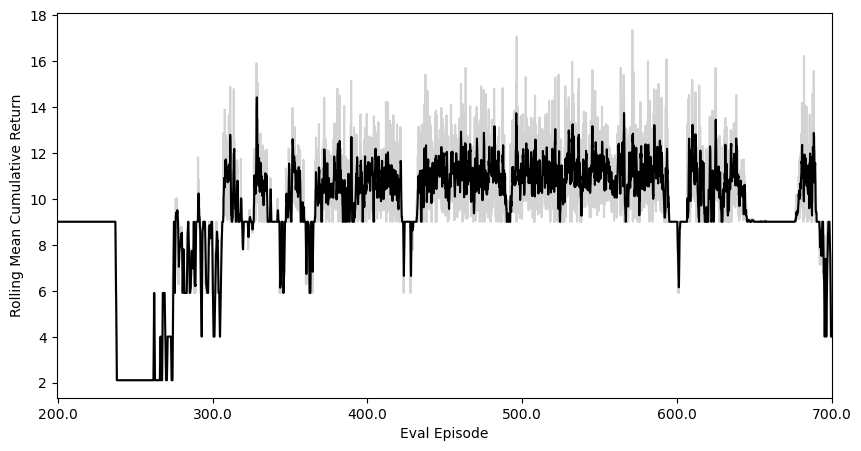

In [15]:
#Examining callback evaluation output
evaluation_log = np.load(eval_log_path + 'evaluations.npz')
evaluation_log_df = pd.DataFrame({item: [np.mean(ep) for ep in evaluation_log[item]] for item in evaluation_log.files})
ax = evaluation_log_df.loc[0:len(evaluation_log_df), 'results'].plot(color = 'lightgray', xlim = [-5, len(evaluation_log_df)], figsize = (10,5))
evaluation_log_df['results'].rolling(5).mean().plot(color = 'black', xlim = [-5, len(evaluation_log_df)])
ax.set_xticklabels(evaluation_log_df['timesteps'])
ax.set_xlabel("Eval Episode")
plt.ylabel("Rolling Mean Cumulative Return")
plt.show()

In [16]:
# saving agent
agent.save("./ppo_flappy_bird_vector_agent")

In [17]:
#deleting old agent and envorinment to free memory
del agent
del env
del eval_env

### Creating Image Stack Agent

Creating Using Flappy Bird-rgb-v0 env. and resizing imgs to 64*128 , changing to grey-scale and stacking to 4 frames together.

In [18]:
# Add code here
env2 = Monitor(gym.make('FlappyBird-rgb-v0', render_mode='human'))

/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(


In [19]:
env2.unwrapped.observation_space.shape

(288, 512, 3)

In [20]:
env2 = gym.wrappers.resize_observation.ResizeObservation(env2, (64, 128))
env2 = gym.wrappers.gray_scale_observation.GrayScaleObservation(env2, keep_dim = True)

In [21]:
env2.observation_space.shape

(64, 128, 1)

In [22]:
env2 = sb3.common.vec_env.DummyVecEnv([lambda: env2])
env2 = sb3.common.vec_env.VecFrameStack(env2, n_stack=4)

In [23]:
env2.observation_space.shape

(64, 128, 4)

Creating a PPO agent with CNN policy that controls the bird using a stack of input image frames & loading tensorboard to monitor training.

In [24]:
%reload_ext tensorboard

In [25]:
# Add code here
tb_log2 = './log_tb_flappy_bird_image/'
agent2 = sb3.PPO('CnnPolicy', 
                env2, 
                learning_rate = 3e-5,
                n_steps = 512,
                ent_coef = 0.001,
                batch_size = 128,
                gae_lambda = 0.9,
                n_epochs = 20,
                #use_sde = True,
                sde_sample_freq = 4,
                clip_range = 0.4,
                policy_kwargs = {'log_std_init': -2, 'ortho_init':False},
                verbose=1,
                tensorboard_log=tb_log2,)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [26]:
# Viewing the agent network.
print(agent2.policy)

ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3072, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3072, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (vf_features_extractor): NatureCNN(
    (cnn): 

In [27]:
# evaluation callback to renders the episode with regular intervals.
eval_log_path2 = './log_flappy_bird_image/'
eval_env2=Monitor(gym.make('FlappyBird-rgb-v0', render_mode='human'))
eval_env2 = gym.wrappers.resize_observation.ResizeObservation(eval_env2, (64, 128))
eval_env2 = gym.wrappers.gray_scale_observation.GrayScaleObservation(eval_env2, keep_dim = True)

eval_env2 = sb3.common.vec_env.DummyVecEnv([lambda: eval_env2])
eval_env2 = sb3.common.vec_env.VecFrameStack(eval_env2, n_stack=4)

eval_callback2 = sb3.common.callbacks.EvalCallback(eval_env2 , 
                                                  best_model_save_path=eval_log_path2 ,
                                                  log_path=eval_log_path2 , 
                                                  eval_freq=100,
                                                  render=True)

In [28]:
# Display TensorBoard
%tensorboard --logdir log_tb_flappy_bird_image

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [29]:
# training model for 500000 timestep
agent2.learn(total_timesteps=500000,
           callback = eval_callback2)

Logging to ./log_tb_flappy_bird_image/PPO_1


/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: uint8
  logger.warn(
/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/stable_baselines3/common/callbacks.py:403: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7fecf8682880> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x7fecf85831c0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")
/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: uint8
  logger.warn(


Eval num_timesteps=100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 100      |
---------------------------------
New best mean reward!
Eval num_timesteps=200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 200      |
---------------------------------
Eval num_timesteps=300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 300      |
---------------------------------
Eval num_

Eval num_timesteps=1900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 1900     |
---------------------------------
Eval num_timesteps=2000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 40       |
|    iterations      | 4        |
|    time_elapsed    | 50       |
|    total_timesteps | 2048     |
---------------------------------
Eval num_tim

Eval num_timesteps=3600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 3600        |
| train/                  |             |
|    approx_kl            | 0.012425861 |
|    clip_fraction        | 0.0514      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.46       |
|    explained_variance   | 0.683       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0817      |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00845    |
|    value_loss           | 0.3         |
-----------------------------------------
Eval num_timesteps=3700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|   

Eval num_timesteps=5300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 5300     |
---------------------------------
Eval num_timesteps=5400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 5400     |
---------------------------------
Eval num_timesteps=5500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 5500     |
---------------------------------
Eval num_timesteps=5600, epi

Eval num_timesteps=7100, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 7100     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 38       |
|    iterations      | 14       |
|    time_elapsed    | 186      |
|    total_timesteps | 7168     |
---------------------------------
Eval num_timesteps=7200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 101          |
|    mean_reward          | 9            |
| time/                   |              |
|    total_timesteps      | 7200   

Eval num_timesteps=8800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 8800        |
| train/                  |             |
|    approx_kl            | 0.015026875 |
|    clip_fraction        | 0.0332      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.523      |
|    explained_variance   | 0.954       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0739      |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00658    |
|    value_loss           | 0.207       |
-----------------------------------------
Eval num_timesteps=8900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|   

Eval num_timesteps=10400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 10400    |
---------------------------------
Eval num_timesteps=10500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 10500    |
---------------------------------
Eval num_timesteps=10600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 10600    |
---------------------------------
Eval num_timesteps=10700,

Eval num_timesteps=12200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 12200    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 37       |
|    iterations      | 24       |
|    time_elapsed    | 323      |
|    total_timesteps | 12288    |
---------------------------------
Eval num_timesteps=12300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 12300     

Eval num_timesteps=13900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 13900       |
| train/                  |             |
|    approx_kl            | 0.010749569 |
|    clip_fraction        | 0           |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.602      |
|    explained_variance   | 0.969       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0719      |
|    n_updates            | 540         |
|    policy_gradient_loss | -0.000614   |
|    value_loss           | 0.167       |
-----------------------------------------
Eval num_timesteps=14000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
| 

New best mean reward!
Eval num_timesteps=15500, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 15500    |
---------------------------------
Eval num_timesteps=15600, episode_reward=9.10 +/- 0.09
Episode length: 102.00 +/- 0.89
---------------------------------
| eval/              |          |
|    mean_ep_length  | 102      |
|    mean_reward     | 9.1      |
| time/              |          |
|    total_timesteps | 15600    |
---------------------------------
Eval num_timesteps=15700, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 15700    |
---------------------------------
Eva

Eval num_timesteps=17300, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 17300    |
---------------------------------
Eval num_timesteps=17400, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 17400    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9        |
| time/              |          |
|    fps             | 37       |
|    iterations      | 34       |
|    time_elapsed    | 458      |
|    total_timesteps | 17408    |
---------------------------------
Eval num_tim

Eval num_timesteps=19000, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 34          |
|    mean_reward          | 2.3         |
| time/                   |             |
|    total_timesteps      | 19000       |
| train/                  |             |
|    approx_kl            | 0.005181714 |
|    clip_fraction        | 0           |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.378      |
|    explained_variance   | 0.97        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0834      |
|    n_updates            | 740         |
|    policy_gradient_loss | -0.000154   |
|    value_loss           | 0.21        |
-----------------------------------------
Eval num_timesteps=19100, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|   

Eval num_timesteps=20600, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 20600    |
---------------------------------
Eval num_timesteps=20700, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 20700    |
---------------------------------
Eval num_timesteps=20800, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 20800    |
---------------------------------
Eval num_timesteps=20900, ep

Eval num_timesteps=22400, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 22400    |
---------------------------------
Eval num_timesteps=22500, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 22500    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | 8.91     |
| time/              |          |
|    fps             | 41       |
|    iterations      | 44       |
|    time_elapsed    | 544      |
|    total_timesteps | 22528    |
---------------------------------
Eval num_tim

Eval num_timesteps=24100, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 34            |
|    mean_reward          | 2.3           |
| time/                   |               |
|    total_timesteps      | 24100         |
| train/                  |               |
|    approx_kl            | 0.00044567988 |
|    clip_fraction        | 0.0164        |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.347        |
|    explained_variance   | 0.883         |
|    learning_rate        | 3e-05         |
|    loss                 | 0.352         |
|    n_updates            | 940           |
|    policy_gradient_loss | -0.00257      |
|    value_loss           | 0.544         |
-------------------------------------------
Eval num_timesteps=24200, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| 

Eval num_timesteps=25800, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 25800    |
---------------------------------
Eval num_timesteps=25900, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 25900    |
---------------------------------
Eval num_timesteps=26000, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 26000    |
---------------------------------
Eval num_timesteps=26100, ep

Eval num_timesteps=27600, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 27600    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 92.7     |
|    ep_rew_mean     | 8.2      |
| time/              |          |
|    fps             | 44       |
|    iterations      | 54       |
|    time_elapsed    | 618      |
|    total_timesteps | 27648    |
---------------------------------
Eval num_timesteps=27700, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 34           |
|    mean_reward          | 2.3          |
| time/                   |              |
|    total_timesteps      | 27700  

Eval num_timesteps=29300, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 29300    |
---------------------------------
Eval num_timesteps=29400, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 29400    |
---------------------------------
Eval num_timesteps=29500, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 29500    |
---------------------------------
Eval num_timesteps=29600, ep

Eval num_timesteps=31100, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 31100    |
---------------------------------
Eval num_timesteps=31200, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 31200    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 91.8     |
|    ep_rew_mean     | 8.11     |
| time/              |          |
|    fps             | 46       |
|    iterations      | 61       |
|    time_elapsed    | 676      |
|    total_timesteps | 31232    |
---------------------------------
Eval num_tim

Eval num_timesteps=32800, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 34           |
|    mean_reward          | 2.3          |
| time/                   |              |
|    total_timesteps      | 32800        |
| train/                  |              |
|    approx_kl            | 0.0067982613 |
|    clip_fraction        | 0.0759       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.367       |
|    explained_variance   | 0.931        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.103        |
|    n_updates            | 1280         |
|    policy_gradient_loss | -0.00874     |
|    value_loss           | 0.285        |
------------------------------------------
Eval num_timesteps=32900, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/             

Eval num_timesteps=34500, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 34500    |
---------------------------------
Eval num_timesteps=34600, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 34600    |
---------------------------------
Eval num_timesteps=34700, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 34700    |
---------------------------------
Eval num_timesteps=34800, ep

Eval num_timesteps=36300, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 36300    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.8     |
|    ep_rew_mean     | 8.4      |
| time/              |          |
|    fps             | 46       |
|    iterations      | 71       |
|    time_elapsed    | 783      |
|    total_timesteps | 36352    |
---------------------------------
Eval num_timesteps=36400, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 36           |
|    mean_reward          | 2.5          |
| time/                   |              |
|    total_timesteps      | 36400  

Eval num_timesteps=38000, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 38000    |
---------------------------------
Eval num_timesteps=38100, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 38100    |
---------------------------------
Eval num_timesteps=38200, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 38200    |
---------------------------------
Eval num_timesteps=38300, ep

Eval num_timesteps=39800, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 39800    |
---------------------------------
Eval num_timesteps=39900, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 39900    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 98.1     |
|    ep_rew_mean     | 8.73     |
| time/              |          |
|    fps             | 46       |
|    iterations      | 78       |
|    time_elapsed    | 853      |
|    total_timesteps | 39936    |
---------------------------------
Eval num_tim

Eval num_timesteps=41500, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 34          |
|    mean_reward          | 2.3         |
| time/                   |             |
|    total_timesteps      | 41500       |
| train/                  |             |
|    approx_kl            | 0.020163268 |
|    clip_fraction        | 0.0462      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.373      |
|    explained_variance   | 0.978       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0368      |
|    n_updates            | 1620        |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 0.132       |
-----------------------------------------
Eval num_timesteps=41600, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|   

Eval num_timesteps=43200, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 43200    |
---------------------------------
Eval num_timesteps=43300, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 43300    |
---------------------------------
Eval num_timesteps=43400, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 43400    |
---------------------------------
Eval num_timesteps=43500, ep

Eval num_timesteps=45000, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 45000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | 8.91     |
| time/              |          |
|    fps             | 47       |
|    iterations      | 88       |
|    time_elapsed    | 943      |
|    total_timesteps | 45056    |
---------------------------------
Eval num_timesteps=45100, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 36          |
|    mean_reward          | 2.5         |
| time/                   |             |
|    total_timesteps      | 45100       

Eval num_timesteps=46700, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 46700    |
---------------------------------
Eval num_timesteps=46800, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 46800    |
---------------------------------
Eval num_timesteps=46900, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 46900    |
---------------------------------
Eval num_timesteps=47000, ep

Eval num_timesteps=48500, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 48500    |
---------------------------------
Eval num_timesteps=48600, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 48600    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9.03     |
| time/              |          |
|    fps             | 47       |
|    iterations      | 95       |
|    time_elapsed    | 1014     |
|    total_timesteps | 48640    |
---------------------------------
Eval num_tim

Eval num_timesteps=50200, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 34          |
|    mean_reward          | 2.3         |
| time/                   |             |
|    total_timesteps      | 50200       |
| train/                  |             |
|    approx_kl            | 0.021715265 |
|    clip_fraction        | 0.0541      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.423      |
|    explained_variance   | 0.89        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.173       |
|    n_updates            | 1960        |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 0.42        |
-----------------------------------------
Eval num_timesteps=50300, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|   

Eval num_timesteps=51900, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 51900    |
---------------------------------
Eval num_timesteps=52000, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 52000    |
---------------------------------
Eval num_timesteps=52100, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 52100    |
---------------------------------
Eval num_timesteps=52200, ep

Eval num_timesteps=53700, episode_reward=7.96 +/- 0.08
Episode length: 90.60 +/- 0.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 90.6     |
|    mean_reward     | 7.96     |
| time/              |          |
|    total_timesteps | 53700    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | 8.92     |
| time/              |          |
|    fps             | 47       |
|    iterations      | 105      |
|    time_elapsed    | 1131     |
|    total_timesteps | 53760    |
---------------------------------
Eval num_timesteps=53800, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 36          |
|    mean_reward          | 2.5         |
| time/                   |             |
|    total_timesteps      | 53800       

Eval num_timesteps=55400, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 55400    |
---------------------------------
Eval num_timesteps=55500, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 55500    |
---------------------------------
Eval num_timesteps=55600, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 55600    |
---------------------------------
Eval num_timesteps=55700, ep

Eval num_timesteps=57200, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 57200    |
---------------------------------
Eval num_timesteps=57300, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 57300    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99.2     |
|    ep_rew_mean     | 8.84     |
| time/              |          |
|    fps             | 47       |
|    iterations      | 112      |
|    time_elapsed    | 1202     |
|    total_timesteps | 57344    |
---------------------------------
Eval num_tim

Eval num_timesteps=58900, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 36           |
|    mean_reward          | 2.5          |
| time/                   |              |
|    total_timesteps      | 58900        |
| train/                  |              |
|    approx_kl            | 0.0047802944 |
|    clip_fraction        | 0.0084       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.256       |
|    explained_variance   | 0.973        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0432       |
|    n_updates            | 2300         |
|    policy_gradient_loss | -0.000572    |
|    value_loss           | 0.109        |
------------------------------------------
Eval num_timesteps=59000, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/             

Eval num_timesteps=60600, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 60600    |
---------------------------------
Eval num_timesteps=60700, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 60700    |
---------------------------------
Eval num_timesteps=60800, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 60800    |
---------------------------------
Eval num_timesteps=60900, ep

Eval num_timesteps=62400, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 62400    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 98.9     |
|    ep_rew_mean     | 8.79     |
| time/              |          |
|    fps             | 47       |
|    iterations      | 122      |
|    time_elapsed    | 1303     |
|    total_timesteps | 62464    |
---------------------------------
Eval num_timesteps=62500, episode_reward=2.70 +/- 0.00
Episode length: 38.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 38           |
|    mean_reward          | 2.7          |
| time/                   |              |
|    total_timesteps      | 62500  

Eval num_timesteps=64100, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 36          |
|    mean_reward          | 2.5         |
| time/                   |             |
|    total_timesteps      | 64100       |
| train/                  |             |
|    approx_kl            | 0.006654949 |
|    clip_fraction        | 0.0715      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.3        |
|    explained_variance   | 0.98        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0258      |
|    n_updates            | 2500        |
|    policy_gradient_loss | -0.00825    |
|    value_loss           | 0.106       |
-----------------------------------------
Eval num_timesteps=64200, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|   

Eval num_timesteps=65700, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 65700    |
---------------------------------
Eval num_timesteps=65800, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 65800    |
---------------------------------
Eval num_timesteps=65900, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 65900    |
---------------------------------
Eval num_timesteps=66000, ep

Eval num_timesteps=67500, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 67500    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.7     |
|    ep_rew_mean     | 8.29     |
| time/              |          |
|    fps             | 48       |
|    iterations      | 132      |
|    time_elapsed    | 1399     |
|    total_timesteps | 67584    |
---------------------------------
Eval num_timesteps=67600, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 36         |
|    mean_reward          | 2.5        |
| time/                   |            |
|    total_timesteps      | 67600      |
| tr

Eval num_timesteps=69200, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 36          |
|    mean_reward          | 2.5         |
| time/                   |             |
|    total_timesteps      | 69200       |
| train/                  |             |
|    approx_kl            | 0.004463324 |
|    clip_fraction        | 0.0415      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.299      |
|    explained_variance   | 0.96        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0715      |
|    n_updates            | 2700        |
|    policy_gradient_loss | -0.0099     |
|    value_loss           | 0.154       |
-----------------------------------------
Eval num_timesteps=69300, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|   

Eval num_timesteps=70800, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 70800    |
---------------------------------
Eval num_timesteps=70900, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 70900    |
---------------------------------
Eval num_timesteps=71000, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 71000    |
---------------------------------
Eval num_timesteps=71100, ep

Eval num_timesteps=72600, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 72600    |
---------------------------------
Eval num_timesteps=72700, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 34       |
|    mean_reward     | 2.3      |
| time/              |          |
|    total_timesteps | 72700    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.8     |
|    ep_rew_mean     | 8.65     |
| time/              |          |
|    fps             | 48       |
|    iterations      | 142      |
|    time_elapsed    | 1497     |
|    total_timesteps | 72704    |
---------------------------------
Eval num_tim

Eval num_timesteps=74300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 101        |
|    mean_reward          | 9          |
| time/                   |            |
|    total_timesteps      | 74300      |
| train/                  |            |
|    approx_kl            | 0.01736873 |
|    clip_fraction        | 0.0591     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.47      |
|    explained_variance   | 0.971      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0284     |
|    n_updates            | 2900       |
|    policy_gradient_loss | -0.00573   |
|    value_loss           | 0.0901     |
----------------------------------------
Eval num_timesteps=74400, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length 

Eval num_timesteps=75900, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 75900    |
---------------------------------
Eval num_timesteps=76000, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 76000    |
---------------------------------
Eval num_timesteps=76100, episode_reward=2.50 +/- 0.00
Episode length: 36.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 36       |
|    mean_reward     | 2.5      |
| time/              |          |
|    total_timesteps | 76100    |
---------------------------------
Eval num_timesteps=76200, ep

Eval num_timesteps=77700, episode_reward=8.16 +/- 0.08
Episode length: 92.60 +/- 0.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 92.6     |
|    mean_reward     | 8.16     |
| time/              |          |
|    total_timesteps | 77700    |
---------------------------------
Eval num_timesteps=77800, episode_reward=8.16 +/- 0.08
Episode length: 92.60 +/- 0.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 92.6     |
|    mean_reward     | 8.16     |
| time/              |          |
|    total_timesteps | 77800    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 103      |
|    ep_rew_mean     | 9.29     |
| time/              |          |
|    fps             | 48       |
|    iterations      | 152      |
|    time_elapsed    | 1610     |
|    total_timesteps | 77824    |
---------------------------------
Eval num_tim

Eval num_timesteps=79400, episode_reward=7.40 +/- 0.00
Episode length: 85.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 85         |
|    mean_reward          | 7.4        |
| time/                   |            |
|    total_timesteps      | 79400      |
| train/                  |            |
|    approx_kl            | 0.00623406 |
|    clip_fraction        | 0.0353     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.365     |
|    explained_variance   | 0.963      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0864     |
|    n_updates            | 3100       |
|    policy_gradient_loss | -0.00227   |
|    value_loss           | 0.173      |
----------------------------------------
Eval num_timesteps=79500, episode_reward=7.40 +/- 0.00
Episode length: 85.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  |

Eval num_timesteps=81000, episode_reward=2.70 +/- 0.00
Episode length: 38.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 38       |
|    mean_reward     | 2.7      |
| time/              |          |
|    total_timesteps | 81000    |
---------------------------------
Eval num_timesteps=81100, episode_reward=2.70 +/- 0.00
Episode length: 38.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 38       |
|    mean_reward     | 2.7      |
| time/              |          |
|    total_timesteps | 81100    |
---------------------------------
Eval num_timesteps=81200, episode_reward=2.70 +/- 0.00
Episode length: 38.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 38       |
|    mean_reward     | 2.7      |
| time/              |          |
|    total_timesteps | 81200    |
---------------------------------
Eval num_timesteps=81300, ep

Eval num_timesteps=82800, episode_reward=2.70 +/- 0.00
Episode length: 38.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 38       |
|    mean_reward     | 2.7      |
| time/              |          |
|    total_timesteps | 82800    |
---------------------------------
Eval num_timesteps=82900, episode_reward=2.70 +/- 0.00
Episode length: 38.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 38       |
|    mean_reward     | 2.7      |
| time/              |          |
|    total_timesteps | 82900    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 103      |
|    ep_rew_mean     | 9.31     |
| time/              |          |
|    fps             | 48       |
|    iterations      | 162      |
|    time_elapsed    | 1718     |
|    total_timesteps | 82944    |
---------------------------------
Eval num_tim

Eval num_timesteps=84500, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 34          |
|    mean_reward          | 2.3         |
| time/                   |             |
|    total_timesteps      | 84500       |
| train/                  |             |
|    approx_kl            | 0.008205933 |
|    clip_fraction        | 0.029       |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.232      |
|    explained_variance   | 0.956       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.09        |
|    n_updates            | 3300        |
|    policy_gradient_loss | 0.000921    |
|    value_loss           | 0.178       |
-----------------------------------------
Eval num_timesteps=84600, episode_reward=2.30 +/- 0.00
Episode length: 34.00 +/- 0.00
---------------------------------
| eval/              |          |
|   

Eval num_timesteps=86200, episode_reward=8.00 +/- 0.00
Episode length: 91.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 91       |
|    mean_reward     | 8        |
| time/              |          |
|    total_timesteps | 86200    |
---------------------------------
Eval num_timesteps=86300, episode_reward=8.00 +/- 0.00
Episode length: 91.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 91       |
|    mean_reward     | 8        |
| time/              |          |
|    total_timesteps | 86300    |
---------------------------------
Eval num_timesteps=86400, episode_reward=8.00 +/- 0.00
Episode length: 91.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 91       |
|    mean_reward     | 8        |
| time/              |          |
|    total_timesteps | 86400    |
---------------------------------
Eval num_timesteps=86500, ep

Eval num_timesteps=88000, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 88000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 9.21     |
| time/              |          |
|    fps             | 48       |
|    iterations      | 172      |
|    time_elapsed    | 1820     |
|    total_timesteps | 88064    |
---------------------------------
Eval num_timesteps=88100, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 32         |
|    mean_reward          | 2.1        |
| time/                   |            |
|    total_timesteps      | 88100      |
| tr

Eval num_timesteps=89700, episode_reward=9.22 +/- 0.26
Episode length: 103.20 +/- 2.64
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 103        |
|    mean_reward          | 9.22       |
| time/                   |            |
|    total_timesteps      | 89700      |
| train/                  |            |
|    approx_kl            | 0.03004817 |
|    clip_fraction        | 0.0382     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.349     |
|    explained_variance   | 0.968      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0732     |
|    n_updates            | 3500       |
|    policy_gradient_loss | -0.00179   |
|    value_loss           | 0.154      |
----------------------------------------
Eval num_timesteps=89800, episode_reward=9.16 +/- 0.20
Episode length: 102.60 +/- 1.96
---------------------------------
| eval/              |          |
|    mean_ep_length 

Eval num_timesteps=91300, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 91300    |
---------------------------------
Eval num_timesteps=91400, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 91400    |
---------------------------------
Eval num_timesteps=91500, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 91500    |
---------------------------------
Eval num_timesteps=91600, ep

Eval num_timesteps=93100, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 93100    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99.5     |
|    ep_rew_mean     | 8.93     |
| time/              |          |
|    fps             | 48       |
|    iterations      | 182      |
|    time_elapsed    | 1935     |
|    total_timesteps | 93184    |
---------------------------------
Eval num_timesteps=93200, episode_reward=8.76 +/- 0.29
Episode length: 98.60 +/- 2.94
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 98.6        |
|    mean_reward          | 8.76        |
| time/                   |             |
|    total_timesteps      | 93200       

Eval num_timesteps=94800, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 32           |
|    mean_reward          | 2.1          |
| time/                   |              |
|    total_timesteps      | 94800        |
| train/                  |              |
|    approx_kl            | 0.0071137776 |
|    clip_fraction        | 0.0103       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.213       |
|    explained_variance   | 0.953        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0728       |
|    n_updates            | 3700         |
|    policy_gradient_loss | -0.0023      |
|    value_loss           | 0.201        |
------------------------------------------
Eval num_timesteps=94900, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/             

Eval num_timesteps=96400, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 96400    |
---------------------------------
Eval num_timesteps=96500, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 96500    |
---------------------------------
Eval num_timesteps=96600, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 96600    |
---------------------------------
Eval num_timesteps=96700, ep

Eval num_timesteps=98200, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 98200    |
---------------------------------
Eval num_timesteps=98300, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 98300    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 9.23     |
| time/              |          |
|    fps             | 48       |
|    iterations      | 192      |
|    time_elapsed    | 2027     |
|    total_timesteps | 98304    |
---------------------------------
Eval num_tim

Eval num_timesteps=99900, episode_reward=8.74 +/- 0.22
Episode length: 98.40 +/- 2.15
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 98.4        |
|    mean_reward          | 8.74        |
| time/                   |             |
|    total_timesteps      | 99900       |
| train/                  |             |
|    approx_kl            | 0.010146611 |
|    clip_fraction        | 0.0349      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.258      |
|    explained_variance   | 0.943       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.105       |
|    n_updates            | 3900        |
|    policy_gradient_loss | -0.00119    |
|    value_loss           | 0.22        |
-----------------------------------------
Eval num_timesteps=100000, episode_reward=8.52 +/- 0.04
Episode length: 96.20 +/- 0.40
---------------------------------
| eval/              |          |
|  

New best mean reward!
Eval num_timesteps=101500, episode_reward=8.94 +/- 0.05
Episode length: 100.40 +/- 0.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | 8.94     |
| time/              |          |
|    total_timesteps | 101500   |
---------------------------------
Eval num_timesteps=101600, episode_reward=8.92 +/- 0.04
Episode length: 100.20 +/- 0.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | 8.92     |
| time/              |          |
|    total_timesteps | 101600   |
---------------------------------
Eval num_timesteps=101700, episode_reward=9.02 +/- 0.15
Episode length: 101.20 +/- 1.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9.02     |
| time/              |          |
|    total_timesteps | 101700   |
---------------------------------


Eval num_timesteps=103300, episode_reward=9.08 +/- 0.16
Episode length: 101.80 +/- 1.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 102      |
|    mean_reward     | 9.08     |
| time/              |          |
|    total_timesteps | 103300   |
---------------------------------
Eval num_timesteps=103400, episode_reward=9.12 +/- 0.16
Episode length: 102.20 +/- 1.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 102      |
|    mean_reward     | 9.12     |
| time/              |          |
|    total_timesteps | 103400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | 9.49     |
| time/              |          |
|    fps             | 48       |
|    iterations      | 202      |
|    time_elapsed    | 2150     |
|    total_timesteps | 103424   |
---------------------------------
Eval num

Eval num_timesteps=105000, episode_reward=8.36 +/- 0.32
Episode length: 94.60 +/- 3.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 94.6         |
|    mean_reward          | 8.36         |
| time/                   |              |
|    total_timesteps      | 105000       |
| train/                  |              |
|    approx_kl            | 0.0033727193 |
|    clip_fraction        | 0.0124       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.214       |
|    explained_variance   | 0.944        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0874       |
|    n_updates            | 4100         |
|    policy_gradient_loss | -0.00176     |
|    value_loss           | 0.266        |
------------------------------------------
Eval num_timesteps=105100, episode_reward=8.84 +/- 0.32
Episode length: 99.40 +/- 3.20
---------------------------------
| eval/           

Eval num_timesteps=106600, episode_reward=8.78 +/- 0.19
Episode length: 98.80 +/- 1.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 98.8     |
|    mean_reward     | 8.78     |
| time/              |          |
|    total_timesteps | 106600   |
---------------------------------
Eval num_timesteps=106700, episode_reward=9.02 +/- 0.37
Episode length: 101.20 +/- 3.66
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9.02     |
| time/              |          |
|    total_timesteps | 106700   |
---------------------------------
Eval num_timesteps=106800, episode_reward=8.70 +/- 0.24
Episode length: 98.00 +/- 2.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 98       |
|    mean_reward     | 8.7      |
| time/              |          |
|    total_timesteps | 106800   |
---------------------------------
Eval num_timesteps=10690

Eval num_timesteps=108400, episode_reward=9.20 +/- 0.40
Episode length: 103.00 +/- 4.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 103      |
|    mean_reward     | 9.2      |
| time/              |          |
|    total_timesteps | 108400   |
---------------------------------
Eval num_timesteps=108500, episode_reward=8.56 +/- 0.54
Episode length: 96.60 +/- 5.39
---------------------------------
| eval/              |          |
|    mean_ep_length  | 96.6     |
|    mean_reward     | 8.56     |
| time/              |          |
|    total_timesteps | 108500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | 9.44     |
| time/              |          |
|    fps             | 47       |
|    iterations      | 212      |
|    time_elapsed    | 2299     |
|    total_timesteps | 108544   |
---------------------------------
Eval num_

Eval num_timesteps=110100, episode_reward=9.16 +/- 0.32
Episode length: 102.60 +/- 3.20
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 103         |
|    mean_reward          | 9.16        |
| time/                   |             |
|    total_timesteps      | 110100      |
| train/                  |             |
|    approx_kl            | 0.006389883 |
|    clip_fraction        | 0.0621      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.21       |
|    explained_variance   | 0.956       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.138       |
|    n_updates            | 4300        |
|    policy_gradient_loss | -0.00832    |
|    value_loss           | 0.3         |
-----------------------------------------
Eval num_timesteps=110200, episode_reward=8.96 +/- 0.08
Episode length: 100.60 +/- 0.80
---------------------------------
| eval/              |          |


Eval num_timesteps=111800, episode_reward=9.38 +/- 0.81
Episode length: 103.00 +/- 4.52
---------------------------------
| eval/              |          |
|    mean_ep_length  | 103      |
|    mean_reward     | 9.38     |
| time/              |          |
|    total_timesteps | 111800   |
---------------------------------
Eval num_timesteps=111900, episode_reward=9.52 +/- 0.86
Episode length: 104.40 +/- 5.54
---------------------------------
| eval/              |          |
|    mean_ep_length  | 104      |
|    mean_reward     | 9.52     |
| time/              |          |
|    total_timesteps | 111900   |
---------------------------------
Eval num_timesteps=112000, episode_reward=9.22 +/- 0.40
Episode length: 103.20 +/- 3.97
---------------------------------
| eval/              |          |
|    mean_ep_length  | 103      |
|    mean_reward     | 9.22     |
| time/              |          |
|    total_timesteps | 112000   |
---------------------------------
Eval num_timesteps=112

Eval num_timesteps=113600, episode_reward=8.94 +/- 0.05
Episode length: 100.40 +/- 0.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | 8.94     |
| time/              |          |
|    total_timesteps | 113600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 106      |
|    ep_rew_mean     | 9.62     |
| time/              |          |
|    fps             | 46       |
|    iterations      | 222      |
|    time_elapsed    | 2446     |
|    total_timesteps | 113664   |
---------------------------------
Eval num_timesteps=113700, episode_reward=9.12 +/- 0.45
Episode length: 102.20 +/- 4.49
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 102          |
|    mean_reward          | 9.12         |
| time/                   |              |
|    total_timesteps      | 113

Eval num_timesteps=115300, episode_reward=8.80 +/- 0.00
Episode length: 99.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 99          |
|    mean_reward          | 8.8         |
| time/                   |             |
|    total_timesteps      | 115300      |
| train/                  |             |
|    approx_kl            | 0.004406419 |
|    clip_fraction        | 0.0124      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 0.949       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0753      |
|    n_updates            | 4500        |
|    policy_gradient_loss | -0.000926   |
|    value_loss           | 0.218       |
-----------------------------------------
Eval num_timesteps=115400, episode_reward=8.80 +/- 0.00
Episode length: 99.00 +/- 0.00
---------------------------------
| eval/              |          |
| 

Eval num_timesteps=116900, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 116900   |
---------------------------------
Eval num_timesteps=117000, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 117000   |
---------------------------------
Eval num_timesteps=117100, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 117100   |
---------------------------------
Eval num_timesteps=117200

Eval num_timesteps=118700, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 118700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | 9.51     |
| time/              |          |
|    fps             | 46       |
|    iterations      | 232      |
|    time_elapsed    | 2577     |
|    total_timesteps | 118784   |
---------------------------------
Eval num_timesteps=118800, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 32          |
|    mean_reward          | 2.1         |
| time/                   |             |
|    total_timesteps      | 118800    

Eval num_timesteps=120400, episode_reward=7.92 +/- 0.88
Episode length: 90.20 +/- 8.82
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 90.2         |
|    mean_reward          | 7.92         |
| time/                   |              |
|    total_timesteps      | 120400       |
| train/                  |              |
|    approx_kl            | 0.0024077827 |
|    clip_fraction        | 0.0132       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.241       |
|    explained_variance   | 0.932        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0845       |
|    n_updates            | 4700         |
|    policy_gradient_loss | -0.00311     |
|    value_loss           | 0.194        |
------------------------------------------
Eval num_timesteps=120500, episode_reward=8.10 +/- 1.14
Episode length: 92.00 +/- 11.38
---------------------------------
| eval/          

Eval num_timesteps=122000, episode_reward=9.20 +/- 0.40
Episode length: 103.00 +/- 4.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 103      |
|    mean_reward     | 9.2      |
| time/              |          |
|    total_timesteps | 122000   |
---------------------------------
Eval num_timesteps=122100, episode_reward=9.42 +/- 0.84
Episode length: 103.40 +/- 4.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 103      |
|    mean_reward     | 9.42     |
| time/              |          |
|    total_timesteps | 122100   |
---------------------------------
Eval num_timesteps=122200, episode_reward=9.82 +/- 1.00
Episode length: 105.60 +/- 5.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.82     |
| time/              |          |
|    total_timesteps | 122200   |
---------------------------------
Eval num_timesteps=122

Eval num_timesteps=123800, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 123800   |
---------------------------------
Eval num_timesteps=123900, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 123900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 9.21     |
| time/              |          |
|    fps             | 45       |
|    iterations      | 242      |
|    time_elapsed    | 2701     |
|    total_timesteps | 123904   |
---------------------------------
Eval num_t

Eval num_timesteps=125500, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 32          |
|    mean_reward          | 2.1         |
| time/                   |             |
|    total_timesteps      | 125500      |
| train/                  |             |
|    approx_kl            | 0.015535486 |
|    clip_fraction        | 0.0298      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.152      |
|    explained_variance   | 0.959       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0872      |
|    n_updates            | 4900        |
|    policy_gradient_loss | -0.00547    |
|    value_loss           | 0.2         |
-----------------------------------------
Eval num_timesteps=125600, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
| 

Eval num_timesteps=127100, episode_reward=10.04 +/- 1.28
Episode length: 107.80 +/- 8.35
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 10       |
| time/              |          |
|    total_timesteps | 127100   |
---------------------------------
Eval num_timesteps=127200, episode_reward=10.00 +/- 1.23
Episode length: 107.40 +/- 7.86
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 10       |
| time/              |          |
|    total_timesteps | 127200   |
---------------------------------
Eval num_timesteps=127300, episode_reward=11.46 +/- 0.10
Episode length: 116.60 +/- 1.02
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11.5     |
| time/              |          |
|    total_timesteps | 127300   |
---------------------------------
New best mean rewar

Eval num_timesteps=128800, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 128800   |
---------------------------------
Eval num_timesteps=128900, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 128900   |
---------------------------------
Eval num_timesteps=129000, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 129000   |
---------------------------------
-------------------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | 9.56     |
| time/              |          |
|    fps             | 45       |
|    iterations      | 255      |
|    time_elapsed    | 2855     |
|    total_timesteps | 130560   |
---------------------------------
Eval num_timesteps=130600, episode_reward=10.30 +/- 0.89
Episode length: 110.40 +/- 5.12
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 110          |
|    mean_reward          | 10.3         |
| time/                   |              |
|    total_timesteps      | 130600       |
| train/                  |              |
|    approx_kl            | 0.0026143407 |
|    clip_fraction        | 0.0217       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.189       |
|    explained_variance   | 0.946        |
|    learning_rate        | 3e-05        |
|    loss   

Eval num_timesteps=132200, episode_reward=9.84 +/- 0.66
Episode length: 107.60 +/- 3.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.84     |
| time/              |          |
|    total_timesteps | 132200   |
---------------------------------
Eval num_timesteps=132300, episode_reward=9.74 +/- 0.79
Episode length: 106.60 +/- 4.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.74     |
| time/              |          |
|    total_timesteps | 132300   |
---------------------------------
Eval num_timesteps=132400, episode_reward=9.68 +/- 0.80
Episode length: 106.00 +/- 5.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.68     |
| time/              |          |
|    total_timesteps | 132400   |
---------------------------------
Eval num_timesteps=132

Eval num_timesteps=134000, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 134000   |
---------------------------------
Eval num_timesteps=134100, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 134100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 107      |
|    ep_rew_mean     | 9.81     |
| time/              |          |
|    fps             | 45       |
|    iterations      | 262      |
|    time_elapsed    | 2960     |
|    total_timesteps | 134144   |
---------------------------------
Eval num_t

Eval num_timesteps=135700, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 32         |
|    mean_reward          | 2.1        |
| time/                   |            |
|    total_timesteps      | 135700     |
| train/                  |            |
|    approx_kl            | 0.03187771 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.233     |
|    explained_variance   | 0.943      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.103      |
|    n_updates            | 5300       |
|    policy_gradient_loss | -0.0028    |
|    value_loss           | 0.208      |
----------------------------------------
Eval num_timesteps=135800, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length 

Eval num_timesteps=137400, episode_reward=7.10 +/- 0.00
Episode length: 82.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 82       |
|    mean_reward     | 7.1      |
| time/              |          |
|    total_timesteps | 137400   |
---------------------------------
Eval num_timesteps=137500, episode_reward=7.10 +/- 0.00
Episode length: 82.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 82       |
|    mean_reward     | 7.1      |
| time/              |          |
|    total_timesteps | 137500   |
---------------------------------
Eval num_timesteps=137600, episode_reward=7.10 +/- 0.00
Episode length: 82.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 82       |
|    mean_reward     | 7.1      |
| time/              |          |
|    total_timesteps | 137600   |
---------------------------------
Eval num_timesteps=137700

Eval num_timesteps=139200, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 139200   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 106      |
|    ep_rew_mean     | 9.79     |
| time/              |          |
|    fps             | 44       |
|    iterations      | 272      |
|    time_elapsed    | 3100     |
|    total_timesteps | 139264   |
---------------------------------
Eval num_timesteps=139300, episode_reward=7.40 +/- 0.80
Episode length: 85.00 +/- 8.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 85         |
|    mean_reward          | 7.4        |
| time/                   |            |
|    total_timesteps      | 139300     |
| 

Eval num_timesteps=140900, episode_reward=9.18 +/- 0.22
Episode length: 102.80 +/- 2.23
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 103         |
|    mean_reward          | 9.18        |
| time/                   |             |
|    total_timesteps      | 140900      |
| train/                  |             |
|    approx_kl            | 0.024036752 |
|    clip_fraction        | 0.0252      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.301      |
|    explained_variance   | 0.959       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0768      |
|    n_updates            | 5500        |
|    policy_gradient_loss | -0.0138     |
|    value_loss           | 0.182       |
-----------------------------------------
Eval num_timesteps=141000, episode_reward=10.08 +/- 1.17
Episode length: 108.20 +/- 7.36
---------------------------------
| eval/              |          |

Eval num_timesteps=142500, episode_reward=9.62 +/- 0.86
Episode length: 105.40 +/- 5.54
---------------------------------
| eval/              |          |
|    mean_ep_length  | 105      |
|    mean_reward     | 9.62     |
| time/              |          |
|    total_timesteps | 142500   |
---------------------------------
Eval num_timesteps=142600, episode_reward=12.90 +/- 0.95
Episode length: 131.00 +/- 9.53
---------------------------------
| eval/              |          |
|    mean_ep_length  | 131      |
|    mean_reward     | 12.9     |
| time/              |          |
|    total_timesteps | 142600   |
---------------------------------
Eval num_timesteps=142700, episode_reward=9.20 +/- 0.40
Episode length: 103.00 +/- 4.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 103      |
|    mean_reward     | 9.2      |
| time/              |          |
|    total_timesteps | 142700   |
---------------------------------
Eval num_timesteps=14

Eval num_timesteps=144300, episode_reward=10.48 +/- 1.22
Episode length: 110.40 +/- 7.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 144300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 106      |
|    ep_rew_mean     | 9.71     |
| time/              |          |
|    fps             | 44       |
|    iterations      | 282      |
|    time_elapsed    | 3254     |
|    total_timesteps | 144384   |
---------------------------------
Eval num_timesteps=144400, episode_reward=11.50 +/- 1.56
Episode length: 118.80 +/- 12.91
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 119         |
|    mean_reward          | 11.5        |
| time/                   |             |
|    total_timesteps      | 14440

Eval num_timesteps=146000, episode_reward=11.34 +/- 3.49
Episode length: 119.00 +/- 27.89
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 119         |
|    mean_reward          | 11.3        |
| time/                   |             |
|    total_timesteps      | 146000      |
| train/                  |             |
|    approx_kl            | 0.010261397 |
|    clip_fraction        | 0.0192      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 0.944       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.13        |
|    n_updates            | 5700        |
|    policy_gradient_loss | 0.00235     |
|    value_loss           | 0.234       |
-----------------------------------------
Eval num_timesteps=146100, episode_reward=11.80 +/- 1.67
Episode length: 121.80 +/- 13.85
---------------------------------
| eval/              |        

Eval num_timesteps=147600, episode_reward=9.80 +/- 0.74
Episode length: 107.20 +/- 4.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.8      |
| time/              |          |
|    total_timesteps | 147600   |
---------------------------------
Eval num_timesteps=147700, episode_reward=10.46 +/- 1.70
Episode length: 112.00 +/- 13.21
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 147700   |
---------------------------------
Eval num_timesteps=147800, episode_reward=10.14 +/- 1.75
Episode length: 110.60 +/- 14.05
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 147800   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=149400, episode_reward=10.08 +/- 1.42
Episode length: 108.20 +/- 10.07
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 149400   |
---------------------------------
Eval num_timesteps=149500, episode_reward=9.32 +/- 0.46
Episode length: 104.20 +/- 4.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 104      |
|    mean_reward     | 9.32     |
| time/              |          |
|    total_timesteps | 149500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 10       |
| time/              |          |
|    fps             | 43       |
|    iterations      | 292      |
|    time_elapsed    | 3403     |
|    total_timesteps | 149504   |
---------------------------------
Eval n

Eval num_timesteps=151100, episode_reward=9.06 +/- 0.12
Episode length: 101.60 +/- 1.20
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 9.06        |
| time/                   |             |
|    total_timesteps      | 151100      |
| train/                  |             |
|    approx_kl            | 0.007403032 |
|    clip_fraction        | 0.0178      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 0.955       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0731      |
|    n_updates            | 5900        |
|    policy_gradient_loss | -0.00358    |
|    value_loss           | 0.185       |
-----------------------------------------
Eval num_timesteps=151200, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |


Eval num_timesteps=152700, episode_reward=10.48 +/- 0.86
Episode length: 110.40 +/- 4.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 152700   |
---------------------------------
Eval num_timesteps=152800, episode_reward=11.26 +/- 1.69
Episode length: 116.40 +/- 14.44
---------------------------------
| eval/              |          |
|    mean_ep_length  | 116      |
|    mean_reward     | 11.3     |
| time/              |          |
|    total_timesteps | 152800   |
---------------------------------
Eval num_timesteps=152900, episode_reward=10.16 +/- 0.81
Episode length: 109.00 +/- 5.02
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 152900   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=154500, episode_reward=10.64 +/- 0.52
Episode length: 112.00 +/- 0.89
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.6     |
| time/              |          |
|    total_timesteps | 154500   |
---------------------------------
Eval num_timesteps=154600, episode_reward=11.06 +/- 1.41
Episode length: 116.20 +/- 10.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 116      |
|    mean_reward     | 11.1     |
| time/              |          |
|    total_timesteps | 154600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 111      |
|    ep_rew_mean     | 10.3     |
| time/              |          |
|    fps             | 43       |
|    iterations      | 302      |
|    time_elapsed    | 3550     |
|    total_timesteps | 154624   |
---------------------------------
Eval 

Eval num_timesteps=156200, episode_reward=9.56 +/- 0.36
Episode length: 106.60 +/- 3.61
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 107        |
|    mean_reward          | 9.56       |
| time/                   |            |
|    total_timesteps      | 156200     |
| train/                  |            |
|    approx_kl            | 0.03176714 |
|    clip_fraction        | 0.0267     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.224     |
|    explained_variance   | 0.952      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0759     |
|    n_updates            | 6100       |
|    policy_gradient_loss | -0.00605   |
|    value_loss           | 0.174      |
----------------------------------------
Eval num_timesteps=156300, episode_reward=9.72 +/- 0.71
Episode length: 106.40 +/- 4.22
---------------------------------
| eval/              |          |
|    mean_ep_lengt

Eval num_timesteps=157800, episode_reward=10.08 +/- 0.83
Episode length: 108.20 +/- 4.35
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 157800   |
---------------------------------
Eval num_timesteps=157900, episode_reward=9.70 +/- 0.73
Episode length: 106.20 +/- 4.07
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.7      |
| time/              |          |
|    total_timesteps | 157900   |
---------------------------------
Eval num_timesteps=158000, episode_reward=10.16 +/- 0.77
Episode length: 109.00 +/- 3.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 158000   |
---------------------------------
Eval num_timesteps=1

Eval num_timesteps=159600, episode_reward=10.12 +/- 1.37
Episode length: 108.60 +/- 9.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 159600   |
---------------------------------
Eval num_timesteps=159700, episode_reward=11.90 +/- 1.72
Episode length: 122.80 +/- 14.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 11.9     |
| time/              |          |
|    total_timesteps | 159700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | 10.6     |
| time/              |          |
|    fps             | 43       |
|    iterations      | 312      |
|    time_elapsed    | 3708     |
|    total_timesteps | 159744   |
---------------------------------
Eval 

Eval num_timesteps=161300, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 161300      |
| train/                  |             |
|    approx_kl            | 0.005736924 |
|    clip_fraction        | 0.0192      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 0.96        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0609      |
|    n_updates            | 6300        |
|    policy_gradient_loss | -0.00716    |
|    value_loss           | 0.147       |
-----------------------------------------
Eval num_timesteps=161400, episode_reward=11.46 +/- 2.19
Episode length: 120.20 +/- 17.96
---------------------------------
| eval/              |          

Eval num_timesteps=163000, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 163000   |
---------------------------------
Eval num_timesteps=163100, episode_reward=8.84 +/- 0.20
Episode length: 99.40 +/- 1.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 99.4     |
|    mean_reward     | 8.84     |
| time/              |          |
|    total_timesteps | 163100   |
---------------------------------
Eval num_timesteps=163200, episode_reward=9.10 +/- 0.43
Episode length: 102.00 +/- 4.29
---------------------------------
| eval/              |          |
|    mean_ep_length  | 102      |
|    mean_reward     | 9.1      |
| time/              |          |
|    total_timesteps | 163200   |
---------------------------------
Eval num_timesteps=1633

Eval num_timesteps=164800, episode_reward=9.98 +/- 1.20
Episode length: 107.20 +/- 7.65
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.98     |
| time/              |          |
|    total_timesteps | 164800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | 10.6     |
| time/              |          |
|    fps             | 42       |
|    iterations      | 322      |
|    time_elapsed    | 3875     |
|    total_timesteps | 164864   |
---------------------------------
Eval num_timesteps=164900, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | 9           |
| time/                   |             |
|    total_timesteps      | 164900  

Eval num_timesteps=166500, episode_reward=11.64 +/- 1.15
Episode length: 120.20 +/- 9.33
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 120         |
|    mean_reward          | 11.6        |
| time/                   |             |
|    total_timesteps      | 166500      |
| train/                  |             |
|    approx_kl            | 0.008091932 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 0.957       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0924      |
|    n_updates            | 6500        |
|    policy_gradient_loss | -0.00852    |
|    value_loss           | 0.188       |
-----------------------------------------
Eval num_timesteps=166600, episode_reward=11.66 +/- 0.34
Episode length: 118.60 +/- 3.38
---------------------------------
| eval/              |          

Eval num_timesteps=168100, episode_reward=9.48 +/- 0.35
Episode length: 105.80 +/- 3.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.48     |
| time/              |          |
|    total_timesteps | 168100   |
---------------------------------
Eval num_timesteps=168200, episode_reward=9.74 +/- 0.38
Episode length: 108.40 +/- 3.77
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.74     |
| time/              |          |
|    total_timesteps | 168200   |
---------------------------------
Eval num_timesteps=168300, episode_reward=9.56 +/- 0.29
Episode length: 106.60 +/- 2.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.56     |
| time/              |          |
|    total_timesteps | 168300   |
---------------------------------
Eval num_timesteps=168

Eval num_timesteps=169900, episode_reward=2.10 +/- 0.00
Episode length: 32.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 32       |
|    mean_reward     | 2.1      |
| time/              |          |
|    total_timesteps | 169900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 10.2     |
| time/              |          |
|    fps             | 42       |
|    iterations      | 332      |
|    time_elapsed    | 4031     |
|    total_timesteps | 169984   |
---------------------------------
Eval num_timesteps=170000, episode_reward=7.10 +/- 0.00
Episode length: 82.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 82          |
|    mean_reward          | 7.1         |
| time/                   |             |
|    total_timesteps      | 170000    

Eval num_timesteps=171600, episode_reward=11.30 +/- 0.95
Episode length: 116.80 +/- 5.98
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 117          |
|    mean_reward          | 11.3         |
| time/                   |              |
|    total_timesteps      | 171600       |
| train/                  |              |
|    approx_kl            | 0.0050410437 |
|    clip_fraction        | 0.0278       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.188       |
|    explained_variance   | 0.949        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0507       |
|    n_updates            | 6700         |
|    policy_gradient_loss | -0.00891     |
|    value_loss           | 0.174        |
------------------------------------------
Eval num_timesteps=171700, episode_reward=11.60 +/- 0.11
Episode length: 118.00 +/- 1.10
---------------------------------
| eval/       

Eval num_timesteps=173200, episode_reward=10.88 +/- 0.88
Episode length: 114.40 +/- 4.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 10.9     |
| time/              |          |
|    total_timesteps | 173200   |
---------------------------------
Eval num_timesteps=173300, episode_reward=11.32 +/- 1.50
Episode length: 118.80 +/- 11.36
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.3     |
| time/              |          |
|    total_timesteps | 173300   |
---------------------------------
Eval num_timesteps=173400, episode_reward=10.90 +/- 0.82
Episode length: 114.60 +/- 3.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 10.9     |
| time/              |          |
|    total_timesteps | 173400   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=175000, episode_reward=10.32 +/- 0.77
Episode length: 110.60 +/- 3.38
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 175000   |
---------------------------------
Eval num_timesteps=175100, episode_reward=11.40 +/- 0.30
Episode length: 116.00 +/- 3.03
---------------------------------
| eval/              |          |
|    mean_ep_length  | 116      |
|    mean_reward     | 11.4     |
| time/              |          |
|    total_timesteps | 175100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | 10       |
| time/              |          |
|    fps             | 41       |
|    iterations      | 342      |
|    time_elapsed    | 4197     |
|    total_timesteps | 175104   |
---------------------------------
Eval n

Eval num_timesteps=176700, episode_reward=10.64 +/- 1.14
Episode length: 112.00 +/- 7.01
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 112         |
|    mean_reward          | 10.6        |
| time/                   |             |
|    total_timesteps      | 176700      |
| train/                  |             |
|    approx_kl            | 0.015231637 |
|    clip_fraction        | 0.019       |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 0.956       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0445      |
|    n_updates            | 6900        |
|    policy_gradient_loss | -0.00506    |
|    value_loss           | 0.214       |
-----------------------------------------
Eval num_timesteps=176800, episode_reward=9.74 +/- 0.93
Episode length: 106.60 +/- 5.71
---------------------------------
| eval/              |          |

Eval num_timesteps=178300, episode_reward=11.78 +/- 0.07
Episode length: 119.80 +/- 0.75
---------------------------------
| eval/              |          |
|    mean_ep_length  | 120      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 178300   |
---------------------------------
Eval num_timesteps=178400, episode_reward=11.62 +/- 0.13
Episode length: 118.20 +/- 1.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 118      |
|    mean_reward     | 11.6     |
| time/              |          |
|    total_timesteps | 178400   |
---------------------------------
Eval num_timesteps=178500, episode_reward=10.94 +/- 0.86
Episode length: 115.00 +/- 4.38
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 10.9     |
| time/              |          |
|    total_timesteps | 178500   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=180100, episode_reward=9.78 +/- 0.94
Episode length: 107.00 +/- 6.03
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.78     |
| time/              |          |
|    total_timesteps | 180100   |
---------------------------------
Eval num_timesteps=180200, episode_reward=9.02 +/- 0.04
Episode length: 101.20 +/- 0.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9.02     |
| time/              |          |
|    total_timesteps | 180200   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 10.2     |
| time/              |          |
|    fps             | 41       |
|    iterations      | 352      |
|    time_elapsed    | 4354     |
|    total_timesteps | 180224   |
---------------------------------
Eval num

Eval num_timesteps=181800, episode_reward=11.36 +/- 0.14
Episode length: 115.60 +/- 1.36
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 116          |
|    mean_reward          | 11.4         |
| time/                   |              |
|    total_timesteps      | 181800       |
| train/                  |              |
|    approx_kl            | 0.0055355225 |
|    clip_fraction        | 0.0195       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.211       |
|    explained_variance   | 0.947        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0738       |
|    n_updates            | 7100         |
|    policy_gradient_loss | -0.00458     |
|    value_loss           | 0.181        |
------------------------------------------
Eval num_timesteps=181900, episode_reward=11.92 +/- 1.92
Episode length: 121.20 +/- 14.06
---------------------------------
| eval/      

Eval num_timesteps=183400, episode_reward=9.48 +/- 0.29
Episode length: 105.80 +/- 2.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.48     |
| time/              |          |
|    total_timesteps | 183400   |
---------------------------------
Eval num_timesteps=183500, episode_reward=9.72 +/- 0.77
Episode length: 106.40 +/- 4.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.72     |
| time/              |          |
|    total_timesteps | 183500   |
---------------------------------
Eval num_timesteps=183600, episode_reward=10.68 +/- 0.89
Episode length: 112.40 +/- 4.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.7     |
| time/              |          |
|    total_timesteps | 183600   |
---------------------------------
Eval num_timesteps=18

Eval num_timesteps=185200, episode_reward=9.90 +/- 1.03
Episode length: 108.20 +/- 7.08
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.9      |
| time/              |          |
|    total_timesteps | 185200   |
---------------------------------
Eval num_timesteps=185300, episode_reward=10.10 +/- 0.76
Episode length: 110.20 +/- 4.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 185300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 10.1     |
| time/              |          |
|    fps             | 41       |
|    iterations      | 362      |
|    time_elapsed    | 4516     |
|    total_timesteps | 185344   |
---------------------------------
Eval nu

Eval num_timesteps=186900, episode_reward=9.16 +/- 0.14
Episode length: 102.60 +/- 1.36
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 103         |
|    mean_reward          | 9.16        |
| time/                   |             |
|    total_timesteps      | 186900      |
| train/                  |             |
|    approx_kl            | 0.006746757 |
|    clip_fraction        | 0.0479      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 0.967       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0295      |
|    n_updates            | 7300        |
|    policy_gradient_loss | -0.0157     |
|    value_loss           | 0.136       |
-----------------------------------------
Eval num_timesteps=187000, episode_reward=9.32 +/- 0.33
Episode length: 104.20 +/- 3.31
---------------------------------
| eval/              |          |


Eval num_timesteps=188600, episode_reward=9.28 +/- 0.34
Episode length: 103.80 +/- 3.43
---------------------------------
| eval/              |          |
|    mean_ep_length  | 104      |
|    mean_reward     | 9.28     |
| time/              |          |
|    total_timesteps | 188600   |
---------------------------------
Eval num_timesteps=188700, episode_reward=10.46 +/- 1.19
Episode length: 110.20 +/- 7.55
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 188700   |
---------------------------------
Eval num_timesteps=188800, episode_reward=9.72 +/- 1.02
Episode length: 106.40 +/- 6.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.72     |
| time/              |          |
|    total_timesteps | 188800   |
---------------------------------
Eval num_timesteps=18

Eval num_timesteps=190400, episode_reward=9.74 +/- 1.00
Episode length: 106.60 +/- 6.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.74     |
| time/              |          |
|    total_timesteps | 190400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | 9.88     |
| time/              |          |
|    fps             | 40       |
|    iterations      | 372      |
|    time_elapsed    | 4680     |
|    total_timesteps | 190464   |
---------------------------------
Eval num_timesteps=190500, episode_reward=9.58 +/- 1.01
Episode length: 105.00 +/- 6.54
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 105         |
|    mean_reward          | 9.58        |
| time/                   |             |
|    total_timesteps      | 190500  

Eval num_timesteps=192100, episode_reward=10.70 +/- 0.71
Episode length: 112.60 +/- 3.01
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 113         |
|    mean_reward          | 10.7        |
| time/                   |             |
|    total_timesteps      | 192100      |
| train/                  |             |
|    approx_kl            | 0.019717213 |
|    clip_fraction        | 0.0271      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 0.945       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0699      |
|    n_updates            | 7500        |
|    policy_gradient_loss | -0.0133     |
|    value_loss           | 0.167       |
-----------------------------------------
Eval num_timesteps=192200, episode_reward=11.08 +/- 0.56
Episode length: 114.60 +/- 2.33
---------------------------------
| eval/              |          

Eval num_timesteps=193700, episode_reward=9.42 +/- 0.36
Episode length: 105.20 +/- 3.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 105      |
|    mean_reward     | 9.42     |
| time/              |          |
|    total_timesteps | 193700   |
---------------------------------
Eval num_timesteps=193800, episode_reward=9.48 +/- 0.26
Episode length: 105.80 +/- 2.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.48     |
| time/              |          |
|    total_timesteps | 193800   |
---------------------------------
Eval num_timesteps=193900, episode_reward=9.52 +/- 0.36
Episode length: 106.20 +/- 3.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.52     |
| time/              |          |
|    total_timesteps | 193900   |
---------------------------------
Eval num_timesteps=194

Eval num_timesteps=195500, episode_reward=9.72 +/- 0.83
Episode length: 106.40 +/- 5.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.72     |
| time/              |          |
|    total_timesteps | 195500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | 9.94     |
| time/              |          |
|    fps             | 40       |
|    iterations      | 382      |
|    time_elapsed    | 4833     |
|    total_timesteps | 195584   |
---------------------------------
Eval num_timesteps=195600, episode_reward=9.64 +/- 0.16
Episode length: 107.40 +/- 1.62
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 107         |
|    mean_reward          | 9.64        |
| time/                   |             |
|    total_timesteps      | 195600  

Eval num_timesteps=197200, episode_reward=9.54 +/- 0.32
Episode length: 106.40 +/- 3.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 106          |
|    mean_reward          | 9.54         |
| time/                   |              |
|    total_timesteps      | 197200       |
| train/                  |              |
|    approx_kl            | 0.0037983642 |
|    clip_fraction        | 0.0294       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.169       |
|    explained_variance   | 0.967        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0779       |
|    n_updates            | 7700         |
|    policy_gradient_loss | -0.00475     |
|    value_loss           | 0.138        |
------------------------------------------
Eval num_timesteps=197300, episode_reward=9.62 +/- 0.33
Episode length: 107.20 +/- 3.31
---------------------------------
| eval/         

Eval num_timesteps=198800, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9        |
| time/              |          |
|    total_timesteps | 198800   |
---------------------------------
Eval num_timesteps=198900, episode_reward=9.20 +/- 0.17
Episode length: 103.00 +/- 1.67
---------------------------------
| eval/              |          |
|    mean_ep_length  | 103      |
|    mean_reward     | 9.2      |
| time/              |          |
|    total_timesteps | 198900   |
---------------------------------
Eval num_timesteps=199000, episode_reward=9.04 +/- 0.08
Episode length: 101.40 +/- 0.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9.04     |
| time/              |          |
|    total_timesteps | 199000   |
---------------------------------
Eval num_timesteps=199

Eval num_timesteps=200600, episode_reward=9.04 +/- 0.08
Episode length: 101.40 +/- 0.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 9.04     |
| time/              |          |
|    total_timesteps | 200600   |
---------------------------------
Eval num_timesteps=200700, episode_reward=9.40 +/- 0.37
Episode length: 105.00 +/- 3.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 105      |
|    mean_reward     | 9.4      |
| time/              |          |
|    total_timesteps | 200700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | 9.91     |
| time/              |          |
|    fps             | 40       |
|    iterations      | 392      |
|    time_elapsed    | 4978     |
|    total_timesteps | 200704   |
---------------------------------
Eval num

Eval num_timesteps=202300, episode_reward=11.22 +/- 0.17
Episode length: 114.20 +/- 1.72
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 114         |
|    mean_reward          | 11.2        |
| time/                   |             |
|    total_timesteps      | 202300      |
| train/                  |             |
|    approx_kl            | 0.029650714 |
|    clip_fraction        | 0.0602      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.121      |
|    explained_variance   | 0.97        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0458      |
|    n_updates            | 7900        |
|    policy_gradient_loss | -0.0123     |
|    value_loss           | 0.137       |
-----------------------------------------
Eval num_timesteps=202400, episode_reward=10.94 +/- 0.53
Episode length: 113.20 +/- 1.94
---------------------------------
| eval/              |          

Eval num_timesteps=203900, episode_reward=10.72 +/- 0.72
Episode length: 112.80 +/- 2.99
---------------------------------
| eval/              |          |
|    mean_ep_length  | 113      |
|    mean_reward     | 10.7     |
| time/              |          |
|    total_timesteps | 203900   |
---------------------------------
Eval num_timesteps=204000, episode_reward=10.76 +/- 0.71
Episode length: 113.20 +/- 2.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 113      |
|    mean_reward     | 10.8     |
| time/              |          |
|    total_timesteps | 204000   |
---------------------------------
Eval num_timesteps=204100, episode_reward=10.58 +/- 0.89
Episode length: 113.20 +/- 4.66
---------------------------------
| eval/              |          |
|    mean_ep_length  | 113      |
|    mean_reward     | 10.6     |
| time/              |          |
|    total_timesteps | 204100   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=205700, episode_reward=10.02 +/- 0.70
Episode length: 109.40 +/- 4.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10       |
| time/              |          |
|    total_timesteps | 205700   |
---------------------------------
Eval num_timesteps=205800, episode_reward=9.72 +/- 0.37
Episode length: 108.20 +/- 3.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.72     |
| time/              |          |
|    total_timesteps | 205800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | 9.96     |
| time/              |          |
|    fps             | 40       |
|    iterations      | 402      |
|    time_elapsed    | 5121     |
|    total_timesteps | 205824   |
---------------------------------
Eval nu

Eval num_timesteps=207400, episode_reward=10.80 +/- 0.86
Episode length: 111.80 +/- 5.04
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 112         |
|    mean_reward          | 10.8        |
| time/                   |             |
|    total_timesteps      | 207400      |
| train/                  |             |
|    approx_kl            | 0.012668733 |
|    clip_fraction        | 0.0223      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.167      |
|    explained_variance   | 0.965       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.061       |
|    n_updates            | 8100        |
|    policy_gradient_loss | -0.0155     |
|    value_loss           | 0.127       |
-----------------------------------------
Eval num_timesteps=207500, episode_reward=10.74 +/- 0.61
Episode length: 113.00 +/- 1.79
---------------------------------
| eval/              |          

Eval num_timesteps=209000, episode_reward=10.64 +/- 0.66
Episode length: 112.00 +/- 2.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.6     |
| time/              |          |
|    total_timesteps | 209000   |
---------------------------------
Eval num_timesteps=209100, episode_reward=10.46 +/- 0.86
Episode length: 110.20 +/- 4.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 209100   |
---------------------------------
Eval num_timesteps=209200, episode_reward=10.38 +/- 0.64
Episode length: 111.20 +/- 2.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 209200   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=210800, episode_reward=11.48 +/- 0.07
Episode length: 116.80 +/- 0.75
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11.5     |
| time/              |          |
|    total_timesteps | 210800   |
---------------------------------
Eval num_timesteps=210900, episode_reward=10.58 +/- 1.00
Episode length: 111.40 +/- 5.89
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.6     |
| time/              |          |
|    total_timesteps | 210900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | 9.96     |
| time/              |          |
|    fps             | 39       |
|    iterations      | 412      |
|    time_elapsed    | 5281     |
|    total_timesteps | 210944   |
---------------------------------
Eval n

Eval num_timesteps=212500, episode_reward=9.64 +/- 0.75
Episode length: 105.60 +/- 4.08
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 106         |
|    mean_reward          | 9.64        |
| time/                   |             |
|    total_timesteps      | 212500      |
| train/                  |             |
|    approx_kl            | 0.007145221 |
|    clip_fraction        | 0.0272      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.129      |
|    explained_variance   | 0.95        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.107       |
|    n_updates            | 8300        |
|    policy_gradient_loss | -0.00602    |
|    value_loss           | 0.192       |
-----------------------------------------
Eval num_timesteps=212600, episode_reward=9.00 +/- 0.00
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |


Eval num_timesteps=214200, episode_reward=10.62 +/- 0.59
Episode length: 111.80 +/- 1.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.6     |
| time/              |          |
|    total_timesteps | 214200   |
---------------------------------
Eval num_timesteps=214300, episode_reward=10.94 +/- 0.48
Episode length: 113.20 +/- 1.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 113      |
|    mean_reward     | 10.9     |
| time/              |          |
|    total_timesteps | 214300   |
---------------------------------
Eval num_timesteps=214400, episode_reward=10.22 +/- 0.87
Episode length: 109.60 +/- 4.92
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 214400   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=216000, episode_reward=9.72 +/- 0.83
Episode length: 106.40 +/- 5.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.72     |
| time/              |          |
|    total_timesteps | 216000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | 10.1     |
| time/              |          |
|    fps             | 39       |
|    iterations      | 422      |
|    time_elapsed    | 5445     |
|    total_timesteps | 216064   |
---------------------------------
Eval num_timesteps=216100, episode_reward=10.22 +/- 0.86
Episode length: 109.60 +/- 4.80
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 110          |
|    mean_reward          | 10.2         |
| time/                   |              |
|    total_timesteps      | 21

Eval num_timesteps=217700, episode_reward=9.94 +/- 0.73
Episode length: 108.60 +/- 3.77
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 109        |
|    mean_reward          | 9.94       |
| time/                   |            |
|    total_timesteps      | 217700     |
| train/                  |            |
|    approx_kl            | 0.05065432 |
|    clip_fraction        | 0.057      |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.154     |
|    explained_variance   | 0.968      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.04       |
|    n_updates            | 8500       |
|    policy_gradient_loss | -0.00777   |
|    value_loss           | 0.109      |
----------------------------------------
Eval num_timesteps=217800, episode_reward=10.18 +/- 0.90
Episode length: 109.20 +/- 4.87
---------------------------------
| eval/              |          |
|    mean_ep_leng

Eval num_timesteps=219300, episode_reward=10.24 +/- 0.78
Episode length: 109.80 +/- 3.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 219300   |
---------------------------------
Eval num_timesteps=219400, episode_reward=10.16 +/- 0.77
Episode length: 109.00 +/- 3.29
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 219400   |
---------------------------------
Eval num_timesteps=219500, episode_reward=9.94 +/- 0.68
Episode length: 108.60 +/- 3.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 9.94     |
| time/              |          |
|    total_timesteps | 219500   |
---------------------------------
Eval num_timesteps=2

Eval num_timesteps=221100, episode_reward=11.50 +/- 0.17
Episode length: 117.00 +/- 1.67
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11.5     |
| time/              |          |
|    total_timesteps | 221100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 110      |
|    ep_rew_mean     | 10.3     |
| time/              |          |
|    fps             | 39       |
|    iterations      | 432      |
|    time_elapsed    | 5601     |
|    total_timesteps | 221184   |
---------------------------------
Eval num_timesteps=221200, episode_reward=10.80 +/- 0.98
Episode length: 113.60 +/- 5.68
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 114         |
|    mean_reward          | 10.8        |
| time/                   |             |
|    total_timesteps      | 221200

Eval num_timesteps=222800, episode_reward=9.24 +/- 0.35
Episode length: 103.40 +/- 3.50
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 103         |
|    mean_reward          | 9.24        |
| time/                   |             |
|    total_timesteps      | 222800      |
| train/                  |             |
|    approx_kl            | 0.028790008 |
|    clip_fraction        | 0.0584      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.179      |
|    explained_variance   | 0.967       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0366      |
|    n_updates            | 8700        |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 0.134       |
-----------------------------------------
Eval num_timesteps=222900, episode_reward=9.26 +/- 0.34
Episode length: 103.60 +/- 3.38
---------------------------------
| eval/              |          |


Eval num_timesteps=224400, episode_reward=10.54 +/- 1.14
Episode length: 111.00 +/- 7.01
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 224400   |
---------------------------------
Eval num_timesteps=224500, episode_reward=10.12 +/- 1.03
Episode length: 108.60 +/- 6.05
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 224500   |
---------------------------------
Eval num_timesteps=224600, episode_reward=10.14 +/- 0.98
Episode length: 108.80 +/- 5.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 224600   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=226200, episode_reward=10.48 +/- 1.05
Episode length: 110.40 +/- 6.18
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 226200   |
---------------------------------
Eval num_timesteps=226300, episode_reward=10.98 +/- 0.63
Episode length: 113.60 +/- 3.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 226300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 111      |
|    ep_rew_mean     | 10.4     |
| time/              |          |
|    fps             | 39       |
|    iterations      | 442      |
|    time_elapsed    | 5757     |
|    total_timesteps | 226304   |
---------------------------------
Eval n

Eval num_timesteps=227900, episode_reward=10.02 +/- 1.13
Episode length: 107.60 +/- 6.89
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 108        |
|    mean_reward          | 10         |
| time/                   |            |
|    total_timesteps      | 227900     |
| train/                  |            |
|    approx_kl            | 0.01868866 |
|    clip_fraction        | 0.0365     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.156     |
|    explained_variance   | 0.959      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0439     |
|    n_updates            | 8900       |
|    policy_gradient_loss | -0.00914   |
|    value_loss           | 0.151      |
----------------------------------------
Eval num_timesteps=228000, episode_reward=11.62 +/- 2.16
Episode length: 118.20 +/- 16.18
---------------------------------
| eval/              |          |
|    mean_ep_le

Eval num_timesteps=229500, episode_reward=9.38 +/- 0.43
Episode length: 104.80 +/- 4.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 105      |
|    mean_reward     | 9.38     |
| time/              |          |
|    total_timesteps | 229500   |
---------------------------------
Eval num_timesteps=229600, episode_reward=9.60 +/- 0.80
Episode length: 105.20 +/- 5.15
---------------------------------
| eval/              |          |
|    mean_ep_length  | 105      |
|    mean_reward     | 9.6      |
| time/              |          |
|    total_timesteps | 229600   |
---------------------------------
Eval num_timesteps=229700, episode_reward=9.24 +/- 0.27
Episode length: 103.40 +/- 2.73
---------------------------------
| eval/              |          |
|    mean_ep_length  | 103      |
|    mean_reward     | 9.24     |
| time/              |          |
|    total_timesteps | 229700   |
---------------------------------
Eval num_timesteps=229

Eval num_timesteps=231300, episode_reward=9.18 +/- 0.18
Episode length: 102.80 +/- 1.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 103      |
|    mean_reward     | 9.18     |
| time/              |          |
|    total_timesteps | 231300   |
---------------------------------
Eval num_timesteps=231400, episode_reward=9.06 +/- 0.12
Episode length: 101.60 +/- 1.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 102      |
|    mean_reward     | 9.06     |
| time/              |          |
|    total_timesteps | 231400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 10.1     |
| time/              |          |
|    fps             | 39       |
|    iterations      | 452      |
|    time_elapsed    | 5918     |
|    total_timesteps | 231424   |
---------------------------------
Eval num

Eval num_timesteps=233000, episode_reward=9.84 +/- 0.88
Episode length: 107.60 +/- 5.82
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 108         |
|    mean_reward          | 9.84        |
| time/                   |             |
|    total_timesteps      | 233000      |
| train/                  |             |
|    approx_kl            | 0.021470014 |
|    clip_fraction        | 0.0605      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.145      |
|    explained_variance   | 0.957       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0788      |
|    n_updates            | 9100        |
|    policy_gradient_loss | -0.00292    |
|    value_loss           | 0.194       |
-----------------------------------------
Eval num_timesteps=233100, episode_reward=10.34 +/- 0.93
Episode length: 110.80 +/- 5.49
---------------------------------
| eval/              |          |

Eval num_timesteps=234600, episode_reward=9.88 +/- 0.83
Episode length: 108.00 +/- 5.51
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.88     |
| time/              |          |
|    total_timesteps | 234600   |
---------------------------------
Eval num_timesteps=234700, episode_reward=10.70 +/- 0.86
Episode length: 110.80 +/- 5.04
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.7     |
| time/              |          |
|    total_timesteps | 234700   |
---------------------------------
Eval num_timesteps=234800, episode_reward=9.74 +/- 0.80
Episode length: 106.60 +/- 5.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.74     |
| time/              |          |
|    total_timesteps | 234800   |
---------------------------------
Eval num_timesteps=23

Eval num_timesteps=236400, episode_reward=9.98 +/- 0.79
Episode length: 109.00 +/- 4.86
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 9.98     |
| time/              |          |
|    total_timesteps | 236400   |
---------------------------------
Eval num_timesteps=236500, episode_reward=9.76 +/- 0.85
Episode length: 106.80 +/- 5.38
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.76     |
| time/              |          |
|    total_timesteps | 236500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 107      |
|    ep_rew_mean     | 9.79     |
| time/              |          |
|    fps             | 38       |
|    iterations      | 462      |
|    time_elapsed    | 6068     |
|    total_timesteps | 236544   |
---------------------------------
Eval num

Eval num_timesteps=238100, episode_reward=9.74 +/- 0.92
Episode length: 106.60 +/- 5.85
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 107        |
|    mean_reward          | 9.74       |
| time/                   |            |
|    total_timesteps      | 238100     |
| train/                  |            |
|    approx_kl            | 0.01901485 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.114     |
|    explained_variance   | 0.967      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0553     |
|    n_updates            | 9300       |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 0.122      |
----------------------------------------
Eval num_timesteps=238200, episode_reward=10.38 +/- 1.13
Episode length: 109.40 +/- 6.89
---------------------------------
| eval/              |          |
|    mean_ep_leng

Eval num_timesteps=239800, episode_reward=10.22 +/- 0.84
Episode length: 109.60 +/- 4.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 239800   |
---------------------------------
Eval num_timesteps=239900, episode_reward=9.66 +/- 0.86
Episode length: 105.80 +/- 5.27
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.66     |
| time/              |          |
|    total_timesteps | 239900   |
---------------------------------
Eval num_timesteps=240000, episode_reward=10.66 +/- 0.55
Episode length: 112.20 +/- 1.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.7     |
| time/              |          |
|    total_timesteps | 240000   |
---------------------------------
Eval num_timesteps=2

Eval num_timesteps=241600, episode_reward=10.06 +/- 0.97
Episode length: 108.00 +/- 5.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 241600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 107      |
|    ep_rew_mean     | 9.79     |
| time/              |          |
|    fps             | 38       |
|    iterations      | 472      |
|    time_elapsed    | 6224     |
|    total_timesteps | 241664   |
---------------------------------
Eval num_timesteps=241700, episode_reward=9.74 +/- 0.95
Episode length: 106.60 +/- 6.02
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 107          |
|    mean_reward          | 9.74         |
| time/                   |              |
|    total_timesteps      | 24

Eval num_timesteps=243300, episode_reward=10.66 +/- 0.76
Episode length: 112.20 +/- 3.37
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 112          |
|    mean_reward          | 10.7         |
| time/                   |              |
|    total_timesteps      | 243300       |
| train/                  |              |
|    approx_kl            | 0.0079566995 |
|    clip_fraction        | 0.0421       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.114       |
|    explained_variance   | 0.967        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0443       |
|    n_updates            | 9500         |
|    policy_gradient_loss | -0.0092      |
|    value_loss           | 0.132        |
------------------------------------------
Eval num_timesteps=243400, episode_reward=11.34 +/- 0.10
Episode length: 115.40 +/- 1.02
---------------------------------
| eval/       

Eval num_timesteps=244900, episode_reward=10.28 +/- 0.87
Episode length: 110.20 +/- 4.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 244900   |
---------------------------------
Eval num_timesteps=245000, episode_reward=10.80 +/- 0.93
Episode length: 111.80 +/- 5.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.8     |
| time/              |          |
|    total_timesteps | 245000   |
---------------------------------
Eval num_timesteps=245100, episode_reward=11.14 +/- 0.59
Episode length: 115.20 +/- 2.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 11.1     |
| time/              |          |
|    total_timesteps | 245100   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=246700, episode_reward=9.62 +/- 0.74
Episode length: 105.40 +/- 4.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 105      |
|    mean_reward     | 9.62     |
| time/              |          |
|    total_timesteps | 246700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | 10       |
| time/              |          |
|    fps             | 38       |
|    iterations      | 482      |
|    time_elapsed    | 6371     |
|    total_timesteps | 246784   |
---------------------------------
Eval num_timesteps=246800, episode_reward=10.68 +/- 0.64
Episode length: 112.40 +/- 2.06
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 112         |
|    mean_reward          | 10.7        |
| time/                   |             |
|    total_timesteps      | 246800 

Eval num_timesteps=248400, episode_reward=10.94 +/- 0.49
Episode length: 113.20 +/- 1.72
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 113         |
|    mean_reward          | 10.9        |
| time/                   |             |
|    total_timesteps      | 248400      |
| train/                  |             |
|    approx_kl            | 0.008700398 |
|    clip_fraction        | 0.0293      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.117      |
|    explained_variance   | 0.951       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0496      |
|    n_updates            | 9700        |
|    policy_gradient_loss | -0.00316    |
|    value_loss           | 0.175       |
-----------------------------------------
Eval num_timesteps=248500, episode_reward=9.90 +/- 0.11
Episode length: 110.00 +/- 1.10
---------------------------------
| eval/              |          |

Eval num_timesteps=250000, episode_reward=11.32 +/- 0.12
Episode length: 115.20 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 11.3     |
| time/              |          |
|    total_timesteps | 250000   |
---------------------------------
Eval num_timesteps=250100, episode_reward=10.98 +/- 0.99
Episode length: 113.60 +/- 6.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 250100   |
---------------------------------
Eval num_timesteps=250200, episode_reward=10.80 +/- 0.91
Episode length: 111.80 +/- 5.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.8     |
| time/              |          |
|    total_timesteps | 250200   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=251800, episode_reward=9.38 +/- 0.36
Episode length: 104.80 +/- 3.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 105      |
|    mean_reward     | 9.38     |
| time/              |          |
|    total_timesteps | 251800   |
---------------------------------
Eval num_timesteps=251900, episode_reward=9.92 +/- 0.95
Episode length: 108.40 +/- 6.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.92     |
| time/              |          |
|    total_timesteps | 251900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 110      |
|    ep_rew_mean     | 10.3     |
| time/              |          |
|    fps             | 38       |
|    iterations      | 492      |
|    time_elapsed    | 6540     |
|    total_timesteps | 251904   |
---------------------------------
Eval num

Eval num_timesteps=253500, episode_reward=11.44 +/- 0.33
Episode length: 116.40 +/- 3.26
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 116          |
|    mean_reward          | 11.4         |
| time/                   |              |
|    total_timesteps      | 253500       |
| train/                  |              |
|    approx_kl            | 0.0043640737 |
|    clip_fraction        | 0.0106       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.126       |
|    explained_variance   | 0.967        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0485       |
|    n_updates            | 9900         |
|    policy_gradient_loss | -0.00669     |
|    value_loss           | 0.104        |
------------------------------------------
Eval num_timesteps=253600, episode_reward=10.96 +/- 1.00
Episode length: 113.40 +/- 6.50
---------------------------------
| eval/       

Eval num_timesteps=255100, episode_reward=11.46 +/- 0.08
Episode length: 116.60 +/- 0.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11.5     |
| time/              |          |
|    total_timesteps | 255100   |
---------------------------------
Eval num_timesteps=255200, episode_reward=10.84 +/- 0.72
Episode length: 114.00 +/- 3.35
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 10.8     |
| time/              |          |
|    total_timesteps | 255200   |
---------------------------------
Eval num_timesteps=255300, episode_reward=11.20 +/- 0.14
Episode length: 114.00 +/- 1.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 11.2     |
| time/              |          |
|    total_timesteps | 255300   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=256900, episode_reward=10.36 +/- 1.12
Episode length: 109.20 +/- 6.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 256900   |
---------------------------------
Eval num_timesteps=257000, episode_reward=10.14 +/- 0.97
Episode length: 108.80 +/- 5.81
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 257000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 110      |
|    ep_rew_mean     | 10.3     |
| time/              |          |
|    fps             | 38       |
|    iterations      | 502      |
|    time_elapsed    | 6701     |
|    total_timesteps | 257024   |
---------------------------------
Eval n

Eval num_timesteps=258600, episode_reward=10.44 +/- 1.15
Episode length: 110.00 +/- 7.18
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 110         |
|    mean_reward          | 10.4        |
| time/                   |             |
|    total_timesteps      | 258600      |
| train/                  |             |
|    approx_kl            | 0.021595778 |
|    clip_fraction        | 0.0291      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.122      |
|    explained_variance   | 0.97        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0649      |
|    n_updates            | 10100       |
|    policy_gradient_loss | -0.00366    |
|    value_loss           | 0.154       |
-----------------------------------------
Eval num_timesteps=258700, episode_reward=9.98 +/- 0.92
Episode length: 109.00 +/- 6.03
---------------------------------
| eval/              |          |

Eval num_timesteps=260200, episode_reward=10.44 +/- 0.88
Episode length: 111.80 +/- 4.58
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 260200   |
---------------------------------
Eval num_timesteps=260300, episode_reward=10.48 +/- 1.01
Episode length: 110.40 +/- 6.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 260300   |
---------------------------------
Eval num_timesteps=260400, episode_reward=11.40 +/- 0.14
Episode length: 116.00 +/- 1.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 116      |
|    mean_reward     | 11.4     |
| time/              |          |
|    total_timesteps | 260400   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=262000, episode_reward=10.28 +/- 1.04
Episode length: 110.20 +/- 6.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 262000   |
---------------------------------
Eval num_timesteps=262100, episode_reward=10.30 +/- 0.91
Episode length: 110.40 +/- 5.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 110      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 262100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 110      |
|    ep_rew_mean     | 10.3     |
| time/              |          |
|    fps             | 38       |
|    iterations      | 512      |
|    time_elapsed    | 6859     |
|    total_timesteps | 262144   |
---------------------------------
Eval n

Eval num_timesteps=263700, episode_reward=10.42 +/- 0.74
Episode length: 111.60 +/- 3.38
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 112          |
|    mean_reward          | 10.4         |
| time/                   |              |
|    total_timesteps      | 263700       |
| train/                  |              |
|    approx_kl            | 0.0070097595 |
|    clip_fraction        | 0.0381       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.129       |
|    explained_variance   | 0.973        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0457       |
|    n_updates            | 10300        |
|    policy_gradient_loss | -0.00699     |
|    value_loss           | 0.124        |
------------------------------------------
Eval num_timesteps=263800, episode_reward=10.66 +/- 0.68
Episode length: 112.20 +/- 2.71
---------------------------------
| eval/       

Eval num_timesteps=265400, episode_reward=9.50 +/- 0.77
Episode length: 104.20 +/- 4.35
---------------------------------
| eval/              |          |
|    mean_ep_length  | 104      |
|    mean_reward     | 9.5      |
| time/              |          |
|    total_timesteps | 265400   |
---------------------------------
Eval num_timesteps=265500, episode_reward=10.06 +/- 0.88
Episode length: 108.00 +/- 4.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 265500   |
---------------------------------
Eval num_timesteps=265600, episode_reward=9.64 +/- 1.05
Episode length: 105.60 +/- 6.97
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.64     |
| time/              |          |
|    total_timesteps | 265600   |
---------------------------------
Eval num_timesteps=26

Eval num_timesteps=267200, episode_reward=10.60 +/- 0.66
Episode length: 111.60 +/- 2.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.6     |
| time/              |          |
|    total_timesteps | 267200   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 10.3     |
| time/              |          |
|    fps             | 38       |
|    iterations      | 522      |
|    time_elapsed    | 7025     |
|    total_timesteps | 267264   |
---------------------------------
Eval num_timesteps=267300, episode_reward=10.46 +/- 0.65
Episode length: 112.00 +/- 2.19
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 112          |
|    mean_reward          | 10.5         |
| time/                   |              |
|    total_timesteps      | 2

Eval num_timesteps=268900, episode_reward=10.68 +/- 1.05
Episode length: 112.40 +/- 6.34
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 112         |
|    mean_reward          | 10.7        |
| time/                   |             |
|    total_timesteps      | 268900      |
| train/                  |             |
|    approx_kl            | 0.010160524 |
|    clip_fraction        | 0.0335      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.102      |
|    explained_variance   | 0.951       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0414      |
|    n_updates            | 10500       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 0.136       |
-----------------------------------------
Eval num_timesteps=269000, episode_reward=10.46 +/- 1.21
Episode length: 110.20 +/- 7.76
---------------------------------
| eval/              |          

Eval num_timesteps=270500, episode_reward=11.02 +/- 1.81
Episode length: 115.80 +/- 14.55
---------------------------------
| eval/              |          |
|    mean_ep_length  | 116      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 270500   |
---------------------------------
Eval num_timesteps=270600, episode_reward=11.16 +/- 0.68
Episode length: 115.40 +/- 3.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 11.2     |
| time/              |          |
|    total_timesteps | 270600   |
---------------------------------
Eval num_timesteps=270700, episode_reward=9.80 +/- 0.91
Episode length: 107.20 +/- 5.84
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.8      |
| time/              |          |
|    total_timesteps | 270700   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=272300, episode_reward=12.10 +/- 2.25
Episode length: 123.00 +/- 17.01
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 12.1     |
| time/              |          |
|    total_timesteps | 272300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.9     |
| time/              |          |
|    fps             | 37       |
|    iterations      | 532      |
|    time_elapsed    | 7199     |
|    total_timesteps | 272384   |
---------------------------------
Eval num_timesteps=272400, episode_reward=10.62 +/- 1.12
Episode length: 111.80 +/- 6.82
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 112         |
|    mean_reward          | 10.6        |
| time/                   |             |
|    total_timesteps      | 27240

Eval num_timesteps=274000, episode_reward=10.32 +/- 1.79
Episode length: 110.60 +/- 13.99
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 111          |
|    mean_reward          | 10.3         |
| time/                   |              |
|    total_timesteps      | 274000       |
| train/                  |              |
|    approx_kl            | 0.0084054265 |
|    clip_fraction        | 0.0206       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.128       |
|    explained_variance   | 0.965        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0517       |
|    n_updates            | 10700        |
|    policy_gradient_loss | -0.00826     |
|    value_loss           | 0.122        |
------------------------------------------
Eval num_timesteps=274100, episode_reward=13.04 +/- 1.76
Episode length: 130.60 +/- 14.35
---------------------------------
| eval/     

Eval num_timesteps=275600, episode_reward=10.98 +/- 1.75
Episode length: 115.40 +/- 13.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 275600   |
---------------------------------
Eval num_timesteps=275700, episode_reward=10.18 +/- 1.36
Episode length: 109.20 +/- 9.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 275700   |
---------------------------------
Eval num_timesteps=275800, episode_reward=9.84 +/- 0.96
Episode length: 107.60 +/- 6.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.84     |
| time/              |          |
|    total_timesteps | 275800   |
---------------------------------
Eval num_timesteps=

Eval num_timesteps=277400, episode_reward=9.76 +/- 1.03
Episode length: 106.80 +/- 6.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.76     |
| time/              |          |
|    total_timesteps | 277400   |
---------------------------------
Eval num_timesteps=277500, episode_reward=9.94 +/- 0.95
Episode length: 106.80 +/- 5.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.94     |
| time/              |          |
|    total_timesteps | 277500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 115      |
|    ep_rew_mean     | 11.1     |
| time/              |          |
|    fps             | 37       |
|    iterations      | 542      |
|    time_elapsed    | 7376     |
|    total_timesteps | 277504   |
---------------------------------
Eval num

Eval num_timesteps=279100, episode_reward=10.80 +/- 0.89
Episode length: 113.60 +/- 4.76
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 114         |
|    mean_reward          | 10.8        |
| time/                   |             |
|    total_timesteps      | 279100      |
| train/                  |             |
|    approx_kl            | 0.020524098 |
|    clip_fraction        | 0.0444      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.115      |
|    explained_variance   | 0.957       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0445      |
|    n_updates            | 10900       |
|    policy_gradient_loss | -0.00763    |
|    value_loss           | 0.146       |
-----------------------------------------
Eval num_timesteps=279200, episode_reward=10.46 +/- 0.89
Episode length: 112.00 +/- 4.52
---------------------------------
| eval/              |          

Eval num_timesteps=280700, episode_reward=11.12 +/- 1.07
Episode length: 115.00 +/- 7.16
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 11.1     |
| time/              |          |
|    total_timesteps | 280700   |
---------------------------------
Eval num_timesteps=280800, episode_reward=9.70 +/- 0.96
Episode length: 106.20 +/- 6.01
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.7      |
| time/              |          |
|    total_timesteps | 280800   |
---------------------------------
Eval num_timesteps=280900, episode_reward=9.92 +/- 0.85
Episode length: 108.40 +/- 5.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.92     |
| time/              |          |
|    total_timesteps | 280900   |
---------------------------------
Eval num_timesteps=28

Eval num_timesteps=282500, episode_reward=9.60 +/- 0.23
Episode length: 107.00 +/- 2.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.6      |
| time/              |          |
|    total_timesteps | 282500   |
---------------------------------
Eval num_timesteps=282600, episode_reward=10.38 +/- 0.99
Episode length: 111.20 +/- 5.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 282600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 10.9     |
| time/              |          |
|    fps             | 37       |
|    iterations      | 552      |
|    time_elapsed    | 7545     |
|    total_timesteps | 282624   |
---------------------------------
Eval nu

Eval num_timesteps=284200, episode_reward=10.20 +/- 1.84
Episode length: 111.20 +/- 14.86
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 111        |
|    mean_reward          | 10.2       |
| time/                   |            |
|    total_timesteps      | 284200     |
| train/                  |            |
|    approx_kl            | 0.08002101 |
|    clip_fraction        | 0.062      |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.889      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0586     |
|    n_updates            | 11100      |
|    policy_gradient_loss | -0.0351    |
|    value_loss           | 0.215      |
----------------------------------------
Eval num_timesteps=284300, episode_reward=10.46 +/- 1.70
Episode length: 112.00 +/- 13.30
---------------------------------
| eval/              |          |
|    mean_ep_l

Eval num_timesteps=285800, episode_reward=11.28 +/- 1.09
Episode length: 116.60 +/- 7.34
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11.3     |
| time/              |          |
|    total_timesteps | 285800   |
---------------------------------
Eval num_timesteps=285900, episode_reward=10.82 +/- 1.09
Episode length: 113.80 +/- 6.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 10.8     |
| time/              |          |
|    total_timesteps | 285900   |
---------------------------------
Eval num_timesteps=286000, episode_reward=11.64 +/- 1.31
Episode length: 120.20 +/- 10.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 120      |
|    mean_reward     | 11.6     |
| time/              |          |
|    total_timesteps | 286000   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=287600, episode_reward=10.18 +/- 1.14
Episode length: 109.20 +/- 7.08
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 287600   |
---------------------------------
Eval num_timesteps=287700, episode_reward=11.54 +/- 1.46
Episode length: 119.20 +/- 12.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.5     |
| time/              |          |
|    total_timesteps | 287700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | 10.6     |
| time/              |          |
|    fps             | 37       |
|    iterations      | 562      |
|    time_elapsed    | 7710     |
|    total_timesteps | 287744   |
---------------------------------
Eval 

Eval num_timesteps=289300, episode_reward=10.74 +/- 0.92
Episode length: 113.00 +/- 5.14
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 113         |
|    mean_reward          | 10.7        |
| time/                   |             |
|    total_timesteps      | 289300      |
| train/                  |             |
|    approx_kl            | 0.009110533 |
|    clip_fraction        | 0.0255      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.119      |
|    explained_variance   | 0.958       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0791      |
|    n_updates            | 11300       |
|    policy_gradient_loss | -0.0034     |
|    value_loss           | 0.131       |
-----------------------------------------
Eval num_timesteps=289400, episode_reward=11.48 +/- 1.42
Episode length: 118.60 +/- 11.32
---------------------------------
| eval/              |         

Eval num_timesteps=291000, episode_reward=11.22 +/- 0.91
Episode length: 116.00 +/- 5.55
---------------------------------
| eval/              |          |
|    mean_ep_length  | 116      |
|    mean_reward     | 11.2     |
| time/              |          |
|    total_timesteps | 291000   |
---------------------------------
Eval num_timesteps=291100, episode_reward=12.96 +/- 1.87
Episode length: 129.80 +/- 15.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 130      |
|    mean_reward     | 13       |
| time/              |          |
|    total_timesteps | 291100   |
---------------------------------
Eval num_timesteps=291200, episode_reward=12.08 +/- 1.53
Episode length: 124.60 +/- 12.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 125      |
|    mean_reward     | 12.1     |
| time/              |          |
|    total_timesteps | 291200   |
---------------------------------
Eval num_timestep

Eval num_timesteps=292800, episode_reward=13.00 +/- 3.27
Episode length: 132.00 +/- 27.36
---------------------------------
| eval/              |          |
|    mean_ep_length  | 132      |
|    mean_reward     | 13       |
| time/              |          |
|    total_timesteps | 292800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 115      |
|    ep_rew_mean     | 10.9     |
| time/              |          |
|    fps             | 37       |
|    iterations      | 572      |
|    time_elapsed    | 7886     |
|    total_timesteps | 292864   |
---------------------------------
Eval num_timesteps=292900, episode_reward=13.78 +/- 1.89
Episode length: 136.20 +/- 14.82
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 136        |
|    mean_reward          | 13.8       |
| time/                   |            |
|    total_timesteps      | 292900   

Eval num_timesteps=294500, episode_reward=10.66 +/- 1.10
Episode length: 112.20 +/- 6.73
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 112        |
|    mean_reward          | 10.7       |
| time/                   |            |
|    total_timesteps      | 294500     |
| train/                  |            |
|    approx_kl            | 0.00751439 |
|    clip_fraction        | 0.0138     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.0921    |
|    explained_variance   | 0.967      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0291     |
|    n_updates            | 11500      |
|    policy_gradient_loss | -0.00561   |
|    value_loss           | 0.102      |
----------------------------------------
Eval num_timesteps=294600, episode_reward=11.60 +/- 1.38
Episode length: 119.80 +/- 10.76
---------------------------------
| eval/              |          |
|    mean_ep_le

Eval num_timesteps=296100, episode_reward=11.72 +/- 1.78
Episode length: 122.80 +/- 14.09
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 296100   |
---------------------------------
Eval num_timesteps=296200, episode_reward=11.10 +/- 0.85
Episode length: 114.80 +/- 5.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 11.1     |
| time/              |          |
|    total_timesteps | 296200   |
---------------------------------
Eval num_timesteps=296300, episode_reward=12.56 +/- 1.08
Episode length: 127.60 +/- 10.78
---------------------------------
| eval/              |          |
|    mean_ep_length  | 128      |
|    mean_reward     | 12.6     |
| time/              |          |
|    total_timesteps | 296300   |
---------------------------------
Eval num_timestep

Eval num_timesteps=297900, episode_reward=11.72 +/- 0.18
Episode length: 119.20 +/- 1.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 297900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 115      |
|    ep_rew_mean     | 10.9     |
| time/              |          |
|    fps             | 36       |
|    iterations      | 582      |
|    time_elapsed    | 8056     |
|    total_timesteps | 297984   |
---------------------------------
Eval num_timesteps=298000, episode_reward=12.02 +/- 2.31
Episode length: 122.20 +/- 17.63
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 122         |
|    mean_reward          | 12          |
| time/                   |             |
|    total_timesteps      | 29800

Eval num_timesteps=299600, episode_reward=11.18 +/- 0.96
Episode length: 115.60 +/- 6.09
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 116         |
|    mean_reward          | 11.2        |
| time/                   |             |
|    total_timesteps      | 299600      |
| train/                  |             |
|    approx_kl            | 0.009055159 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.066      |
|    explained_variance   | 0.953       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0649      |
|    n_updates            | 11700       |
|    policy_gradient_loss | -0.00526    |
|    value_loss           | 0.156       |
-----------------------------------------
Eval num_timesteps=299700, episode_reward=11.10 +/- 1.62
Episode length: 116.60 +/- 12.37
---------------------------------
| eval/              |         

Eval num_timesteps=301200, episode_reward=11.76 +/- 2.66
Episode length: 121.40 +/- 20.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 121      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 301200   |
---------------------------------
Eval num_timesteps=301300, episode_reward=12.64 +/- 2.85
Episode length: 126.60 +/- 22.04
---------------------------------
| eval/              |          |
|    mean_ep_length  | 127      |
|    mean_reward     | 12.6     |
| time/              |          |
|    total_timesteps | 301300   |
---------------------------------
Eval num_timesteps=301400, episode_reward=10.14 +/- 1.19
Episode length: 108.80 +/- 7.55
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 301400   |
---------------------------------
Eval num_timestep

Eval num_timesteps=303000, episode_reward=13.32 +/- 1.62
Episode length: 133.40 +/- 13.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 133      |
|    mean_reward     | 13.3     |
| time/              |          |
|    total_timesteps | 303000   |
---------------------------------
Eval num_timesteps=303100, episode_reward=11.36 +/- 1.24
Episode length: 117.40 +/- 10.21
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11.4     |
| time/              |          |
|    total_timesteps | 303100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 117      |
|    ep_rew_mean     | 11.2     |
| time/              |          |
|    fps             | 36       |
|    iterations      | 592      |
|    time_elapsed    | 8232     |
|    total_timesteps | 303104   |
---------------------------------
Eval

Eval num_timesteps=304700, episode_reward=11.54 +/- 1.16
Episode length: 119.20 +/- 8.57
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 119         |
|    mean_reward          | 11.5        |
| time/                   |             |
|    total_timesteps      | 304700      |
| train/                  |             |
|    approx_kl            | 0.014643614 |
|    clip_fraction        | 0.038       |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0979     |
|    explained_variance   | 0.943       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0399      |
|    n_updates            | 11900       |
|    policy_gradient_loss | -0.0033     |
|    value_loss           | 0.185       |
-----------------------------------------
Eval num_timesteps=304800, episode_reward=12.08 +/- 2.48
Episode length: 124.60 +/- 18.38
---------------------------------
| eval/              |         

Eval num_timesteps=306300, episode_reward=10.36 +/- 1.11
Episode length: 111.00 +/- 6.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 306300   |
---------------------------------
Eval num_timesteps=306400, episode_reward=10.84 +/- 1.70
Episode length: 115.80 +/- 12.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 116      |
|    mean_reward     | 10.8     |
| time/              |          |
|    total_timesteps | 306400   |
---------------------------------
Eval num_timesteps=306500, episode_reward=10.68 +/- 1.64
Episode length: 114.20 +/- 12.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 10.7     |
| time/              |          |
|    total_timesteps | 306500   |
---------------------------------
Eval num_timestep

Eval num_timesteps=308100, episode_reward=10.16 +/- 1.15
Episode length: 109.00 +/- 7.13
---------------------------------
| eval/              |          |
|    mean_ep_length  | 109      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 308100   |
---------------------------------
Eval num_timesteps=308200, episode_reward=10.14 +/- 1.88
Episode length: 110.60 +/- 15.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 308200   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 118      |
|    ep_rew_mean     | 11.4     |
| time/              |          |
|    fps             | 36       |
|    iterations      | 602      |
|    time_elapsed    | 8407     |
|    total_timesteps | 308224   |
---------------------------------
Eval 

Eval num_timesteps=309800, episode_reward=10.62 +/- 1.99
Episode length: 113.60 +/- 15.91
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 114         |
|    mean_reward          | 10.6        |
| time/                   |             |
|    total_timesteps      | 309800      |
| train/                  |             |
|    approx_kl            | 0.008771652 |
|    clip_fraction        | 0.026       |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0953     |
|    explained_variance   | 0.977       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0376      |
|    n_updates            | 12100       |
|    policy_gradient_loss | -0.00834    |
|    value_loss           | 0.124       |
-----------------------------------------
Eval num_timesteps=309900, episode_reward=9.58 +/- 0.92
Episode length: 105.00 +/- 5.62
---------------------------------
| eval/              |          

Eval num_timesteps=311400, episode_reward=9.70 +/- 0.66
Episode length: 106.20 +/- 3.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 106      |
|    mean_reward     | 9.7      |
| time/              |          |
|    total_timesteps | 311400   |
---------------------------------
Eval num_timesteps=311500, episode_reward=9.20 +/- 0.06
Episode length: 103.00 +/- 0.63
---------------------------------
| eval/              |          |
|    mean_ep_length  | 103      |
|    mean_reward     | 9.2      |
| time/              |          |
|    total_timesteps | 311500   |
---------------------------------
Eval num_timesteps=311600, episode_reward=10.32 +/- 2.04
Episode length: 112.40 +/- 16.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 311600   |
---------------------------------
Eval num_timesteps=3

Eval num_timesteps=313200, episode_reward=9.78 +/- 0.82
Episode length: 107.00 +/- 4.69
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 9.78     |
| time/              |          |
|    total_timesteps | 313200   |
---------------------------------
Eval num_timesteps=313300, episode_reward=10.00 +/- 1.03
Episode length: 107.40 +/- 5.95
---------------------------------
| eval/              |          |
|    mean_ep_length  | 107      |
|    mean_reward     | 10       |
| time/              |          |
|    total_timesteps | 313300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    fps             | 36       |
|    iterations      | 612      |
|    time_elapsed    | 8574     |
|    total_timesteps | 313344   |
---------------------------------
Eval nu

Eval num_timesteps=314900, episode_reward=10.16 +/- 1.11
Episode length: 109.00 +/- 6.81
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 109        |
|    mean_reward          | 10.2       |
| time/                   |            |
|    total_timesteps      | 314900     |
| train/                  |            |
|    approx_kl            | 0.01056753 |
|    clip_fraction        | 0.0294     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.078     |
|    explained_variance   | 0.949      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0457     |
|    n_updates            | 12300      |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 0.16       |
----------------------------------------
Eval num_timesteps=315000, episode_reward=10.54 +/- 1.06
Episode length: 111.00 +/- 6.26
---------------------------------
| eval/              |          |
|    mean_ep_len

Eval num_timesteps=316600, episode_reward=11.68 +/- 0.12
Episode length: 118.80 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 316600   |
---------------------------------
Eval num_timesteps=316700, episode_reward=11.68 +/- 0.17
Episode length: 118.80 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 316700   |
---------------------------------
Eval num_timesteps=316800, episode_reward=12.52 +/- 1.94
Episode length: 125.40 +/- 15.81
---------------------------------
| eval/              |          |
|    mean_ep_length  | 125      |
|    mean_reward     | 12.5     |
| time/              |          |
|    total_timesteps | 316800   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=318400, episode_reward=13.34 +/- 3.68
Episode length: 131.80 +/- 29.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 132      |
|    mean_reward     | 13.3     |
| time/              |          |
|    total_timesteps | 318400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 113      |
|    ep_rew_mean     | 10.6     |
| time/              |          |
|    fps             | 36       |
|    iterations      | 622      |
|    time_elapsed    | 8752     |
|    total_timesteps | 318464   |
---------------------------------
Eval num_timesteps=318500, episode_reward=13.36 +/- 2.12
Episode length: 132.00 +/- 16.75
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 132          |
|    mean_reward          | 13.4         |
| time/                   |              |
|    total_timesteps      |

Eval num_timesteps=320100, episode_reward=10.90 +/- 2.29
Episode length: 116.40 +/- 18.50
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 116         |
|    mean_reward          | 10.9        |
| time/                   |             |
|    total_timesteps      | 320100      |
| train/                  |             |
|    approx_kl            | 0.022087673 |
|    clip_fraction        | 0.0396      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0937     |
|    explained_variance   | 0.943       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0292      |
|    n_updates            | 12500       |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 0.146       |
-----------------------------------------
Eval num_timesteps=320200, episode_reward=10.66 +/- 2.01
Episode length: 114.00 +/- 16.30
---------------------------------
| eval/              |        

Eval num_timesteps=321700, episode_reward=11.96 +/- 1.66
Episode length: 123.40 +/- 13.54
---------------------------------
| eval/              |          |
|    mean_ep_length  | 123      |
|    mean_reward     | 12       |
| time/              |          |
|    total_timesteps | 321700   |
---------------------------------
Eval num_timesteps=321800, episode_reward=13.66 +/- 0.93
Episode length: 138.60 +/- 9.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 139      |
|    mean_reward     | 13.7     |
| time/              |          |
|    total_timesteps | 321800   |
---------------------------------
Eval num_timesteps=321900, episode_reward=13.20 +/- 0.77
Episode length: 134.00 +/- 7.69
---------------------------------
| eval/              |          |
|    mean_ep_length  | 134      |
|    mean_reward     | 13.2     |
| time/              |          |
|    total_timesteps | 321900   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=323500, episode_reward=14.82 +/- 2.14
Episode length: 146.60 +/- 17.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 147      |
|    mean_reward     | 14.8     |
| time/              |          |
|    total_timesteps | 323500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 122      |
|    ep_rew_mean     | 11.7     |
| time/              |          |
|    fps             | 36       |
|    iterations      | 632      |
|    time_elapsed    | 8935     |
|    total_timesteps | 323584   |
---------------------------------
Eval num_timesteps=323600, episode_reward=12.00 +/- 1.56
Episode length: 123.80 +/- 12.62
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 124         |
|    mean_reward          | 12          |
| time/                   |             |
|    total_timesteps      | 3236

Eval num_timesteps=325200, episode_reward=11.82 +/- 2.54
Episode length: 122.00 +/- 18.97
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 122         |
|    mean_reward          | 11.8        |
| time/                   |             |
|    total_timesteps      | 325200      |
| train/                  |             |
|    approx_kl            | 0.026016016 |
|    clip_fraction        | 0.0407      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0871     |
|    explained_variance   | 0.934       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0413      |
|    n_updates            | 12700       |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 0.186       |
-----------------------------------------
Eval num_timesteps=325300, episode_reward=14.94 +/- 4.00
Episode length: 147.80 +/- 31.30
---------------------------------
| eval/              |        

Eval num_timesteps=326800, episode_reward=12.68 +/- 1.04
Episode length: 128.80 +/- 10.44
---------------------------------
| eval/              |          |
|    mean_ep_length  | 129      |
|    mean_reward     | 12.7     |
| time/              |          |
|    total_timesteps | 326800   |
---------------------------------
Eval num_timesteps=326900, episode_reward=13.68 +/- 0.36
Episode length: 138.80 +/- 3.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 139      |
|    mean_reward     | 13.7     |
| time/              |          |
|    total_timesteps | 326900   |
---------------------------------
Eval num_timesteps=327000, episode_reward=14.60 +/- 2.73
Episode length: 144.40 +/- 23.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 144      |
|    mean_reward     | 14.6     |
| time/              |          |
|    total_timesteps | 327000   |
---------------------------------
Eval num_timestep

Eval num_timesteps=328600, episode_reward=13.08 +/- 2.14
Episode length: 132.80 +/- 16.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 133      |
|    mean_reward     | 13.1     |
| time/              |          |
|    total_timesteps | 328600   |
---------------------------------
Eval num_timesteps=328700, episode_reward=11.72 +/- 1.15
Episode length: 119.20 +/- 11.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 328700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 128      |
|    ep_rew_mean     | 12.6     |
| time/              |          |
|    fps             | 36       |
|    iterations      | 642      |
|    time_elapsed    | 9116     |
|    total_timesteps | 328704   |
---------------------------------
Eval

Eval num_timesteps=330300, episode_reward=11.74 +/- 1.89
Episode length: 123.00 +/- 15.45
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 123         |
|    mean_reward          | 11.7        |
| time/                   |             |
|    total_timesteps      | 330300      |
| train/                  |             |
|    approx_kl            | 0.015425013 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0749     |
|    explained_variance   | 0.959       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.00214     |
|    n_updates            | 12900       |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 0.0971      |
-----------------------------------------
Eval num_timesteps=330400, episode_reward=14.12 +/- 0.93
Episode length: 141.40 +/- 5.95
---------------------------------
| eval/              |         

Eval num_timesteps=331900, episode_reward=12.52 +/- 1.96
Episode length: 129.00 +/- 16.70
---------------------------------
| eval/              |          |
|    mean_ep_length  | 129      |
|    mean_reward     | 12.5     |
| time/              |          |
|    total_timesteps | 331900   |
---------------------------------
Eval num_timesteps=332000, episode_reward=13.78 +/- 1.48
Episode length: 138.00 +/- 12.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 138      |
|    mean_reward     | 13.8     |
| time/              |          |
|    total_timesteps | 332000   |
---------------------------------
Eval num_timesteps=332100, episode_reward=13.56 +/- 2.00
Episode length: 134.00 +/- 16.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 134      |
|    mean_reward     | 13.6     |
| time/              |          |
|    total_timesteps | 332100   |
---------------------------------
Eval num_timeste

Eval num_timesteps=333700, episode_reward=12.46 +/- 1.21
Episode length: 126.60 +/- 12.08
---------------------------------
| eval/              |          |
|    mean_ep_length  | 127      |
|    mean_reward     | 12.5     |
| time/              |          |
|    total_timesteps | 333700   |
---------------------------------
Eval num_timesteps=333800, episode_reward=12.20 +/- 2.30
Episode length: 125.80 +/- 16.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 126      |
|    mean_reward     | 12.2     |
| time/              |          |
|    total_timesteps | 333800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 129      |
|    ep_rew_mean     | 12.6     |
| time/              |          |
|    fps             | 35       |
|    iterations      | 652      |
|    time_elapsed    | 9300     |
|    total_timesteps | 333824   |
---------------------------------
Eval

Eval num_timesteps=335400, episode_reward=12.18 +/- 3.09
Episode length: 125.60 +/- 24.57
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 126         |
|    mean_reward          | 12.2        |
| time/                   |             |
|    total_timesteps      | 335400      |
| train/                  |             |
|    approx_kl            | 0.013369182 |
|    clip_fraction        | 0.0373      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.103      |
|    explained_variance   | 0.936       |
|    learning_rate        | 3e-05       |
|    loss                 | -0.00853    |
|    n_updates            | 13100       |
|    policy_gradient_loss | -0.0278     |
|    value_loss           | 0.143       |
-----------------------------------------
Eval num_timesteps=335500, episode_reward=12.42 +/- 3.19
Episode length: 128.00 +/- 25.41
---------------------------------
| eval/              |        

Eval num_timesteps=337000, episode_reward=12.80 +/- 1.37
Episode length: 130.00 +/- 13.65
---------------------------------
| eval/              |          |
|    mean_ep_length  | 130      |
|    mean_reward     | 12.8     |
| time/              |          |
|    total_timesteps | 337000   |
---------------------------------
Eval num_timesteps=337100, episode_reward=12.34 +/- 1.37
Episode length: 125.40 +/- 13.69
---------------------------------
| eval/              |          |
|    mean_ep_length  | 125      |
|    mean_reward     | 12.3     |
| time/              |          |
|    total_timesteps | 337100   |
---------------------------------
Eval num_timesteps=337200, episode_reward=12.22 +/- 1.84
Episode length: 126.00 +/- 15.39
---------------------------------
| eval/              |          |
|    mean_ep_length  | 126      |
|    mean_reward     | 12.2     |
| time/              |          |
|    total_timesteps | 337200   |
---------------------------------
Eval num_timeste

Eval num_timesteps=338800, episode_reward=15.60 +/- 7.09
Episode length: 150.80 +/- 56.59
---------------------------------
| eval/              |          |
|    mean_ep_length  | 151      |
|    mean_reward     | 15.6     |
| time/              |          |
|    total_timesteps | 338800   |
---------------------------------
Eval num_timesteps=338900, episode_reward=20.28 +/- 5.17
Episode length: 188.60 +/- 43.07
---------------------------------
| eval/              |          |
|    mean_ep_length  | 189      |
|    mean_reward     | 20.3     |
| time/              |          |
|    total_timesteps | 338900   |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 130      |
|    ep_rew_mean     | 12.8     |
| time/              |          |
|    fps             | 35       |
|    iterations      | 662      |
|    time_elapsed    | 9483     |
|    total_timesteps | 338944   |
----------------

Eval num_timesteps=340500, episode_reward=14.36 +/- 3.55
Episode length: 142.00 +/- 28.87
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 142         |
|    mean_reward          | 14.4        |
| time/                   |             |
|    total_timesteps      | 340500      |
| train/                  |             |
|    approx_kl            | 0.016015612 |
|    clip_fraction        | 0.016       |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.065      |
|    explained_variance   | 0.863       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0875      |
|    n_updates            | 13300       |
|    policy_gradient_loss | -0.0042     |
|    value_loss           | 0.332       |
-----------------------------------------
Eval num_timesteps=340600, episode_reward=14.32 +/- 2.93
Episode length: 143.40 +/- 22.91
---------------------------------
| eval/              |        

Eval num_timesteps=342200, episode_reward=10.90 +/- 2.28
Episode length: 116.40 +/- 18.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 116      |
|    mean_reward     | 10.9     |
| time/              |          |
|    total_timesteps | 342200   |
---------------------------------
Eval num_timesteps=342300, episode_reward=10.32 +/- 2.10
Episode length: 110.60 +/- 16.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.3     |
| time/              |          |
|    total_timesteps | 342300   |
---------------------------------
Eval num_timesteps=342400, episode_reward=11.56 +/- 1.77
Episode length: 119.40 +/- 14.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.6     |
| time/              |          |
|    total_timesteps | 342400   |
---------------------------------
Eval num_timeste

Eval num_timesteps=344000, episode_reward=11.96 +/- 2.11
Episode length: 121.60 +/- 15.78
---------------------------------
| eval/              |          |
|    mean_ep_length  | 122      |
|    mean_reward     | 12       |
| time/              |          |
|    total_timesteps | 344000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 130      |
|    ep_rew_mean     | 12.7     |
| time/              |          |
|    fps             | 35       |
|    iterations      | 672      |
|    time_elapsed    | 9654     |
|    total_timesteps | 344064   |
---------------------------------
Eval num_timesteps=344100, episode_reward=11.64 +/- 1.71
Episode length: 122.00 +/- 13.15
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 122         |
|    mean_reward          | 11.6        |
| time/                   |             |
|    total_timesteps      | 3441

Eval num_timesteps=345700, episode_reward=12.10 +/- 2.09
Episode length: 123.00 +/- 15.75
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 123         |
|    mean_reward          | 12.1        |
| time/                   |             |
|    total_timesteps      | 345700      |
| train/                  |             |
|    approx_kl            | 0.009072164 |
|    clip_fraction        | 0.0433      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.127      |
|    explained_variance   | 0.966       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0317      |
|    n_updates            | 13500       |
|    policy_gradient_loss | -0.0121     |
|    value_loss           | 0.138       |
-----------------------------------------
Eval num_timesteps=345800, episode_reward=11.10 +/- 0.61
Episode length: 114.80 +/- 2.56
---------------------------------
| eval/              |         

Eval num_timesteps=347300, episode_reward=10.58 +/- 0.89
Episode length: 111.40 +/- 4.59
---------------------------------
| eval/              |          |
|    mean_ep_length  | 111      |
|    mean_reward     | 10.6     |
| time/              |          |
|    total_timesteps | 347300   |
---------------------------------
Eval num_timesteps=347400, episode_reward=11.40 +/- 1.74
Episode length: 119.60 +/- 13.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 120      |
|    mean_reward     | 11.4     |
| time/              |          |
|    total_timesteps | 347400   |
---------------------------------
Eval num_timesteps=347500, episode_reward=11.52 +/- 2.23
Episode length: 119.00 +/- 15.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.5     |
| time/              |          |
|    total_timesteps | 347500   |
---------------------------------
Eval num_timestep

Eval num_timesteps=349100, episode_reward=11.32 +/- 1.72
Episode length: 118.80 +/- 13.70
---------------------------------
| eval/              |          |
|    mean_ep_length  | 119      |
|    mean_reward     | 11.3     |
| time/              |          |
|    total_timesteps | 349100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 122      |
|    ep_rew_mean     | 11.8     |
| time/              |          |
|    fps             | 35       |
|    iterations      | 682      |
|    time_elapsed    | 9806     |
|    total_timesteps | 349184   |
---------------------------------
Eval num_timesteps=349200, episode_reward=11.12 +/- 0.88
Episode length: 115.00 +/- 5.33
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 115         |
|    mean_reward          | 11.1        |
| time/                   |             |
|    total_timesteps      | 34920

Eval num_timesteps=350800, episode_reward=11.40 +/- 0.22
Episode length: 116.00 +/- 2.19
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 116         |
|    mean_reward          | 11.4        |
| time/                   |             |
|    total_timesteps      | 350800      |
| train/                  |             |
|    approx_kl            | 0.002793935 |
|    clip_fraction        | 0.00898     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.081      |
|    explained_variance   | 0.955       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0196      |
|    n_updates            | 13700       |
|    policy_gradient_loss | -0.00347    |
|    value_loss           | 0.151       |
-----------------------------------------
Eval num_timesteps=350900, episode_reward=11.48 +/- 0.25
Episode length: 116.80 +/- 2.48
---------------------------------
| eval/              |          

Eval num_timesteps=352400, episode_reward=12.34 +/- 1.83
Episode length: 123.60 +/- 14.75
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 12.3     |
| time/              |          |
|    total_timesteps | 352400   |
---------------------------------
Eval num_timesteps=352500, episode_reward=11.02 +/- 1.02
Episode length: 114.00 +/- 6.69
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 352500   |
---------------------------------
Eval num_timesteps=352600, episode_reward=11.56 +/- 0.12
Episode length: 117.60 +/- 1.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 118      |
|    mean_reward     | 11.6     |
| time/              |          |
|    total_timesteps | 352600   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=354200, episode_reward=12.54 +/- 1.78
Episode length: 125.60 +/- 14.22
---------------------------------
| eval/              |          |
|    mean_ep_length  | 126      |
|    mean_reward     | 12.5     |
| time/              |          |
|    total_timesteps | 354200   |
---------------------------------
Eval num_timesteps=354300, episode_reward=11.04 +/- 1.02
Episode length: 114.20 +/- 6.68
---------------------------------
| eval/              |          |
|    mean_ep_length  | 114      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 354300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 116      |
|    ep_rew_mean     | 11.1     |
| time/              |          |
|    fps             | 35       |
|    iterations      | 692      |
|    time_elapsed    | 9963     |
|    total_timesteps | 354304   |
---------------------------------
Eval 

Eval num_timesteps=355900, episode_reward=10.20 +/- 1.27
Episode length: 109.40 +/- 8.36
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 109         |
|    mean_reward          | 10.2        |
| time/                   |             |
|    total_timesteps      | 355900      |
| train/                  |             |
|    approx_kl            | 0.010896107 |
|    clip_fraction        | 0.021       |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0838     |
|    explained_variance   | 0.953       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0487      |
|    n_updates            | 13900       |
|    policy_gradient_loss | -0.00971    |
|    value_loss           | 0.14        |
-----------------------------------------
Eval num_timesteps=356000, episode_reward=12.44 +/- 0.88
Episode length: 126.40 +/- 8.75
---------------------------------
| eval/              |          

Eval num_timesteps=357500, episode_reward=13.38 +/- 3.49
Episode length: 135.80 +/- 26.98
---------------------------------
| eval/              |          |
|    mean_ep_length  | 136      |
|    mean_reward     | 13.4     |
| time/              |          |
|    total_timesteps | 357500   |
---------------------------------
Eval num_timesteps=357600, episode_reward=10.74 +/- 1.03
Episode length: 113.00 +/- 6.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 113      |
|    mean_reward     | 10.7     |
| time/              |          |
|    total_timesteps | 357600   |
---------------------------------
Eval num_timesteps=357700, episode_reward=12.56 +/- 1.92
Episode length: 129.40 +/- 16.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 129      |
|    mean_reward     | 12.6     |
| time/              |          |
|    total_timesteps | 357700   |
---------------------------------
Eval num_timestep

Eval num_timesteps=359300, episode_reward=14.60 +/- 2.86
Episode length: 144.40 +/- 24.36
---------------------------------
| eval/              |          |
|    mean_ep_length  | 144      |
|    mean_reward     | 14.6     |
| time/              |          |
|    total_timesteps | 359300   |
---------------------------------
Eval num_timesteps=359400, episode_reward=13.68 +/- 2.56
Episode length: 137.00 +/- 22.13
---------------------------------
| eval/              |          |
|    mean_ep_length  | 137      |
|    mean_reward     | 13.7     |
| time/              |          |
|    total_timesteps | 359400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 121      |
|    ep_rew_mean     | 11.7     |
| time/              |          |
|    fps             | 35       |
|    iterations      | 702      |
|    time_elapsed    | 10129    |
|    total_timesteps | 359424   |
---------------------------------
Eval

Eval num_timesteps=361000, episode_reward=18.62 +/- 6.85
Episode length: 175.60 +/- 54.06
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 176          |
|    mean_reward          | 18.6         |
| time/                   |              |
|    total_timesteps      | 361000       |
| train/                  |              |
|    approx_kl            | 0.0050794315 |
|    clip_fraction        | 0.013        |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0693      |
|    explained_variance   | 0.931        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0401       |
|    n_updates            | 14100        |
|    policy_gradient_loss | -0.0089      |
|    value_loss           | 0.171        |
------------------------------------------
Eval num_timesteps=361100, episode_reward=17.02 +/- 5.32
Episode length: 165.00 +/- 42.94
---------------------------------
| eval/     

Eval num_timesteps=362600, episode_reward=12.32 +/- 2.18
Episode length: 128.80 +/- 17.43
---------------------------------
| eval/              |          |
|    mean_ep_length  | 129      |
|    mean_reward     | 12.3     |
| time/              |          |
|    total_timesteps | 362600   |
---------------------------------
Eval num_timesteps=362700, episode_reward=10.76 +/- 1.12
Episode length: 113.20 +/- 6.91
---------------------------------
| eval/              |          |
|    mean_ep_length  | 113      |
|    mean_reward     | 10.8     |
| time/              |          |
|    total_timesteps | 362700   |
---------------------------------
Eval num_timesteps=362800, episode_reward=11.66 +/- 2.07
Episode length: 122.20 +/- 16.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 122      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 362800   |
---------------------------------
Eval num_timestep

Eval num_timesteps=364400, episode_reward=9.88 +/- 0.91
Episode length: 108.00 +/- 5.76
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.88     |
| time/              |          |
|    total_timesteps | 364400   |
---------------------------------
Eval num_timesteps=364500, episode_reward=11.16 +/- 0.89
Episode length: 115.40 +/- 5.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 11.2     |
| time/              |          |
|    total_timesteps | 364500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 122      |
|    ep_rew_mean     | 11.9     |
| time/              |          |
|    fps             | 35       |
|    iterations      | 712      |
|    time_elapsed    | 10300    |
|    total_timesteps | 364544   |
---------------------------------
Eval nu

Eval num_timesteps=366100, episode_reward=12.20 +/- 1.86
Episode length: 122.20 +/- 14.97
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 122         |
|    mean_reward          | 12.2        |
| time/                   |             |
|    total_timesteps      | 366100      |
| train/                  |             |
|    approx_kl            | 0.037529856 |
|    clip_fraction        | 0.0559      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.067      |
|    explained_variance   | 0.916       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0515      |
|    n_updates            | 14300       |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 0.215       |
-----------------------------------------
Eval num_timesteps=366200, episode_reward=12.08 +/- 1.12
Episode length: 122.80 +/- 11.18
---------------------------------
| eval/              |        

Eval num_timesteps=367800, episode_reward=13.24 +/- 2.50
Episode length: 132.60 +/- 21.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 133      |
|    mean_reward     | 13.2     |
| time/              |          |
|    total_timesteps | 367800   |
---------------------------------
Eval num_timesteps=367900, episode_reward=12.46 +/- 1.77
Episode length: 124.80 +/- 14.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 125      |
|    mean_reward     | 12.5     |
| time/              |          |
|    total_timesteps | 367900   |
---------------------------------
Eval num_timesteps=368000, episode_reward=13.42 +/- 1.70
Episode length: 134.40 +/- 14.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 134      |
|    mean_reward     | 13.4     |
| time/              |          |
|    total_timesteps | 368000   |
---------------------------------
Eval num_timeste

Eval num_timesteps=369600, episode_reward=13.86 +/- 5.91
Episode length: 137.00 +/- 46.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 137      |
|    mean_reward     | 13.9     |
| time/              |          |
|    total_timesteps | 369600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 122      |
|    ep_rew_mean     | 11.7     |
| time/              |          |
|    fps             | 35       |
|    iterations      | 722      |
|    time_elapsed    | 10466    |
|    total_timesteps | 369664   |
---------------------------------
Eval num_timesteps=369700, episode_reward=20.44 +/- 5.92
Episode length: 190.20 +/- 48.87
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 190         |
|    mean_reward          | 20.4        |
| time/                   |             |
|    total_timesteps      | 3697

Eval num_timesteps=371300, episode_reward=15.46 +/- 5.35
Episode length: 151.20 +/- 41.31
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 151          |
|    mean_reward          | 15.5         |
| time/                   |              |
|    total_timesteps      | 371300       |
| train/                  |              |
|    approx_kl            | 0.0025784594 |
|    clip_fraction        | 0.0147       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0478      |
|    explained_variance   | 0.862        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.071        |
|    n_updates            | 14500        |
|    policy_gradient_loss | -0.000841    |
|    value_loss           | 0.213        |
------------------------------------------
Eval num_timesteps=371400, episode_reward=12.42 +/- 3.19
Episode length: 126.20 +/- 23.85
---------------------------------
| eval/     

Eval num_timesteps=372900, episode_reward=12.76 +/- 5.40
Episode length: 131.40 +/- 43.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 131      |
|    mean_reward     | 12.8     |
| time/              |          |
|    total_timesteps | 372900   |
---------------------------------
Eval num_timesteps=373000, episode_reward=17.20 +/- 6.05
Episode length: 166.80 +/- 50.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 167      |
|    mean_reward     | 17.2     |
| time/              |          |
|    total_timesteps | 373000   |
---------------------------------
Eval num_timesteps=373100, episode_reward=16.38 +/- 2.49
Episode length: 158.60 +/- 18.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 159      |
|    mean_reward     | 16.4     |
| time/              |          |
|    total_timesteps | 373100   |
---------------------------------
Eval num_timeste

Eval num_timesteps=374700, episode_reward=12.76 +/- 1.22
Episode length: 129.60 +/- 12.21
---------------------------------
| eval/              |          |
|    mean_ep_length  | 130      |
|    mean_reward     | 12.8     |
| time/              |          |
|    total_timesteps | 374700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 126      |
|    ep_rew_mean     | 12.2     |
| time/              |          |
|    fps             | 35       |
|    iterations      | 732      |
|    time_elapsed    | 10651    |
|    total_timesteps | 374784   |
---------------------------------
Eval num_timesteps=374800, episode_reward=15.06 +/- 3.64
Episode length: 147.20 +/- 27.30
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 147         |
|    mean_reward          | 15.1        |
| time/                   |             |
|    total_timesteps      | 3748

Eval num_timesteps=376400, episode_reward=16.46 +/- 4.80
Episode length: 161.20 +/- 38.80
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 161         |
|    mean_reward          | 16.5        |
| time/                   |             |
|    total_timesteps      | 376400      |
| train/                  |             |
|    approx_kl            | 0.012492547 |
|    clip_fraction        | 0.0269      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0757     |
|    explained_variance   | 0.927       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0429      |
|    n_updates            | 14700       |
|    policy_gradient_loss | -0.0139     |
|    value_loss           | 0.172       |
-----------------------------------------
Eval num_timesteps=376500, episode_reward=15.52 +/- 2.37
Episode length: 153.60 +/- 19.28
---------------------------------
| eval/              |        

Eval num_timesteps=378000, episode_reward=14.14 +/- 2.44
Episode length: 139.80 +/- 20.65
---------------------------------
| eval/              |          |
|    mean_ep_length  | 140      |
|    mean_reward     | 14.1     |
| time/              |          |
|    total_timesteps | 378000   |
---------------------------------
Eval num_timesteps=378100, episode_reward=15.18 +/- 2.77
Episode length: 148.40 +/- 23.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 148      |
|    mean_reward     | 15.2     |
| time/              |          |
|    total_timesteps | 378100   |
---------------------------------
Eval num_timesteps=378200, episode_reward=15.96 +/- 1.90
Episode length: 156.20 +/- 15.21
---------------------------------
| eval/              |          |
|    mean_ep_length  | 156      |
|    mean_reward     | 16       |
| time/              |          |
|    total_timesteps | 378200   |
---------------------------------
Eval num_timeste

Eval num_timesteps=379800, episode_reward=22.92 +/- 8.00
Episode length: 213.20 +/- 64.98
---------------------------------
| eval/              |          |
|    mean_ep_length  | 213      |
|    mean_reward     | 22.9     |
| time/              |          |
|    total_timesteps | 379800   |
---------------------------------
New best mean reward!
Eval num_timesteps=379900, episode_reward=13.86 +/- 1.43
Episode length: 138.80 +/- 11.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 139      |
|    mean_reward     | 13.9     |
| time/              |          |
|    total_timesteps | 379900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 135      |
|    ep_rew_mean     | 13.4     |
| time/              |          |
|    fps             | 35       |
|    iterations      | 742      |
|    time_elapsed    | 10847    |
|    total_timesteps | 379904   |
----------------

Eval num_timesteps=381500, episode_reward=14.98 +/- 2.53
Episode length: 148.20 +/- 21.08
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 148         |
|    mean_reward          | 15          |
| time/                   |             |
|    total_timesteps      | 381500      |
| train/                  |             |
|    approx_kl            | 0.012092923 |
|    clip_fraction        | 0.0253      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0748     |
|    explained_variance   | 0.922       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0801      |
|    n_updates            | 14900       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 0.199       |
-----------------------------------------
Eval num_timesteps=381600, episode_reward=15.30 +/- 2.20
Episode length: 151.40 +/- 17.64
---------------------------------
| eval/              |        

Eval num_timesteps=383100, episode_reward=16.46 +/- 6.10
Episode length: 161.20 +/- 48.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 161      |
|    mean_reward     | 16.5     |
| time/              |          |
|    total_timesteps | 383100   |
---------------------------------
Eval num_timesteps=383200, episode_reward=16.28 +/- 1.60
Episode length: 157.60 +/- 13.63
---------------------------------
| eval/              |          |
|    mean_ep_length  | 158      |
|    mean_reward     | 16.3     |
| time/              |          |
|    total_timesteps | 383200   |
---------------------------------
Eval num_timesteps=383300, episode_reward=14.98 +/- 1.10
Episode length: 148.20 +/- 6.73
---------------------------------
| eval/              |          |
|    mean_ep_length  | 148      |
|    mean_reward     | 15       |
| time/              |          |
|    total_timesteps | 383300   |
---------------------------------
Eval num_timestep

Eval num_timesteps=384900, episode_reward=9.84 +/- 0.75
Episode length: 107.60 +/- 4.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 9.84     |
| time/              |          |
|    total_timesteps | 384900   |
---------------------------------
Eval num_timesteps=385000, episode_reward=10.10 +/- 1.04
Episode length: 108.40 +/- 6.15
---------------------------------
| eval/              |          |
|    mean_ep_length  | 108      |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 385000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 137      |
|    ep_rew_mean     | 13.7     |
| time/              |          |
|    fps             | 34       |
|    iterations      | 752      |
|    time_elapsed    | 11028    |
|    total_timesteps | 385024   |
---------------------------------
Eval nu

Eval num_timesteps=386600, episode_reward=11.52 +/- 1.39
Episode length: 119.00 +/- 11.54
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 119         |
|    mean_reward          | 11.5        |
| time/                   |             |
|    total_timesteps      | 386600      |
| train/                  |             |
|    approx_kl            | 0.009001967 |
|    clip_fraction        | 0.0268      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.11       |
|    explained_variance   | 0.94        |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0887      |
|    n_updates            | 15100       |
|    policy_gradient_loss | -0.0128     |
|    value_loss           | 0.22        |
-----------------------------------------
Eval num_timesteps=386700, episode_reward=11.18 +/- 1.44
Episode length: 117.40 +/- 10.82
---------------------------------
| eval/              |        

Eval num_timesteps=388200, episode_reward=16.92 +/- 5.68
Episode length: 164.00 +/- 46.39
---------------------------------
| eval/              |          |
|    mean_ep_length  | 164      |
|    mean_reward     | 16.9     |
| time/              |          |
|    total_timesteps | 388200   |
---------------------------------
Eval num_timesteps=388300, episode_reward=15.56 +/- 6.03
Episode length: 152.20 +/- 49.69
---------------------------------
| eval/              |          |
|    mean_ep_length  | 152      |
|    mean_reward     | 15.6     |
| time/              |          |
|    total_timesteps | 388300   |
---------------------------------
Eval num_timesteps=388400, episode_reward=14.72 +/- 5.50
Episode length: 143.80 +/- 44.30
---------------------------------
| eval/              |          |
|    mean_ep_length  | 144      |
|    mean_reward     | 14.7     |
| time/              |          |
|    total_timesteps | 388400   |
---------------------------------
Eval num_timeste

Eval num_timesteps=390000, episode_reward=12.34 +/- 1.70
Episode length: 123.60 +/- 13.44
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 12.3     |
| time/              |          |
|    total_timesteps | 390000   |
---------------------------------
Eval num_timesteps=390100, episode_reward=12.40 +/- 1.80
Episode length: 124.20 +/- 14.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 12.4     |
| time/              |          |
|    total_timesteps | 390100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 131      |
|    ep_rew_mean     | 12.8     |
| time/              |          |
|    fps             | 34       |
|    iterations      | 762      |
|    time_elapsed    | 11205    |
|    total_timesteps | 390144   |
---------------------------------
Eval

Eval num_timesteps=391700, episode_reward=10.46 +/- 0.85
Episode length: 112.00 +/- 4.10
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 112         |
|    mean_reward          | 10.5        |
| time/                   |             |
|    total_timesteps      | 391700      |
| train/                  |             |
|    approx_kl            | 0.093013555 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.107      |
|    explained_variance   | 0.891       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0175      |
|    n_updates            | 15300       |
|    policy_gradient_loss | -0.0214     |
|    value_loss           | 0.194       |
-----------------------------------------
Eval num_timesteps=391800, episode_reward=10.88 +/- 0.97
Episode length: 114.40 +/- 5.35
---------------------------------
| eval/              |          

Eval num_timesteps=393400, episode_reward=11.86 +/- 2.37
Episode length: 124.20 +/- 16.73
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 11.9     |
| time/              |          |
|    total_timesteps | 393400   |
---------------------------------
Eval num_timesteps=393500, episode_reward=12.56 +/- 2.05
Episode length: 127.60 +/- 15.34
---------------------------------
| eval/              |          |
|    mean_ep_length  | 128      |
|    mean_reward     | 12.6     |
| time/              |          |
|    total_timesteps | 393500   |
---------------------------------
Eval num_timesteps=393600, episode_reward=11.94 +/- 3.31
Episode length: 125.00 +/- 26.27
---------------------------------
| eval/              |          |
|    mean_ep_length  | 125      |
|    mean_reward     | 11.9     |
| time/              |          |
|    total_timesteps | 393600   |
---------------------------------
Eval num_timeste

Eval num_timesteps=395200, episode_reward=10.44 +/- 1.00
Episode length: 111.80 +/- 5.67
---------------------------------
| eval/              |          |
|    mean_ep_length  | 112      |
|    mean_reward     | 10.4     |
| time/              |          |
|    total_timesteps | 395200   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | 11.4     |
| time/              |          |
|    fps             | 34       |
|    iterations      | 772      |
|    time_elapsed    | 11392    |
|    total_timesteps | 395264   |
---------------------------------
Eval num_timesteps=395300, episode_reward=12.16 +/- 2.12
Episode length: 123.60 +/- 15.69
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 124         |
|    mean_reward          | 12.2        |
| time/                   |             |
|    total_timesteps      | 39530

Eval num_timesteps=396900, episode_reward=12.16 +/- 1.95
Episode length: 123.60 +/- 14.14
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 124         |
|    mean_reward          | 12.2        |
| time/                   |             |
|    total_timesteps      | 396900      |
| train/                  |             |
|    approx_kl            | 0.018159147 |
|    clip_fraction        | 0.0341      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.101      |
|    explained_variance   | 0.946       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0718      |
|    n_updates            | 15500       |
|    policy_gradient_loss | -0.0121     |
|    value_loss           | 0.19        |
-----------------------------------------
Eval num_timesteps=397000, episode_reward=13.86 +/- 3.07
Episode length: 138.80 +/- 24.38
---------------------------------
| eval/              |        

Eval num_timesteps=398500, episode_reward=16.70 +/- 5.34
Episode length: 161.80 +/- 41.52
---------------------------------
| eval/              |          |
|    mean_ep_length  | 162      |
|    mean_reward     | 16.7     |
| time/              |          |
|    total_timesteps | 398500   |
---------------------------------
Eval num_timesteps=398600, episode_reward=15.64 +/- 4.94
Episode length: 154.80 +/- 40.22
---------------------------------
| eval/              |          |
|    mean_ep_length  | 155      |
|    mean_reward     | 15.6     |
| time/              |          |
|    total_timesteps | 398600   |
---------------------------------
Eval num_timesteps=398700, episode_reward=13.54 +/- 2.50
Episode length: 135.60 +/- 18.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 136      |
|    mean_reward     | 13.5     |
| time/              |          |
|    total_timesteps | 398700   |
---------------------------------
Eval num_timeste

Eval num_timesteps=400300, episode_reward=13.66 +/- 1.28
Episode length: 136.80 +/- 9.81
---------------------------------
| eval/              |          |
|    mean_ep_length  | 137      |
|    mean_reward     | 13.7     |
| time/              |          |
|    total_timesteps | 400300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 122      |
|    ep_rew_mean     | 11.8     |
| time/              |          |
|    fps             | 34       |
|    iterations      | 782      |
|    time_elapsed    | 11605    |
|    total_timesteps | 400384   |
---------------------------------
Eval num_timesteps=400400, episode_reward=13.78 +/- 2.24
Episode length: 138.00 +/- 18.99
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 138         |
|    mean_reward          | 13.8        |
| time/                   |             |
|    total_timesteps      | 40040

Eval num_timesteps=402000, episode_reward=11.64 +/- 0.33
Episode length: 118.40 +/- 3.26
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 118         |
|    mean_reward          | 11.6        |
| time/                   |             |
|    total_timesteps      | 402000      |
| train/                  |             |
|    approx_kl            | 0.024207355 |
|    clip_fraction        | 0.0288      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0997     |
|    explained_variance   | 0.911       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.139       |
|    n_updates            | 15700       |
|    policy_gradient_loss | -0.00469    |
|    value_loss           | 0.189       |
-----------------------------------------
Eval num_timesteps=402100, episode_reward=12.74 +/- 0.94
Episode length: 129.40 +/- 9.39
---------------------------------
| eval/              |          

Eval num_timesteps=403600, episode_reward=11.94 +/- 2.62
Episode length: 125.00 +/- 19.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 125      |
|    mean_reward     | 11.9     |
| time/              |          |
|    total_timesteps | 403600   |
---------------------------------
Eval num_timesteps=403700, episode_reward=10.96 +/- 0.88
Episode length: 115.20 +/- 4.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | 11       |
| time/              |          |
|    total_timesteps | 403700   |
---------------------------------
Eval num_timesteps=403800, episode_reward=13.18 +/- 1.88
Episode length: 133.80 +/- 13.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 134      |
|    mean_reward     | 13.2     |
| time/              |          |
|    total_timesteps | 403800   |
---------------------------------
Eval num_timestep

Eval num_timesteps=405400, episode_reward=15.06 +/- 2.01
Episode length: 149.00 +/- 16.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 149      |
|    mean_reward     | 15.1     |
| time/              |          |
|    total_timesteps | 405400   |
---------------------------------
Eval num_timesteps=405500, episode_reward=14.62 +/- 2.18
Episode length: 144.60 +/- 17.82
---------------------------------
| eval/              |          |
|    mean_ep_length  | 145      |
|    mean_reward     | 14.6     |
| time/              |          |
|    total_timesteps | 405500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 124      |
|    ep_rew_mean     | 12       |
| time/              |          |
|    fps             | 34       |
|    iterations      | 792      |
|    time_elapsed    | 11797    |
|    total_timesteps | 405504   |
---------------------------------
Eval

Eval num_timesteps=407100, episode_reward=13.34 +/- 0.85
Episode length: 135.40 +/- 8.45
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 135         |
|    mean_reward          | 13.3        |
| time/                   |             |
|    total_timesteps      | 407100      |
| train/                  |             |
|    approx_kl            | 0.013591606 |
|    clip_fraction        | 0.0398      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0998     |
|    explained_variance   | 0.899       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0434      |
|    n_updates            | 15900       |
|    policy_gradient_loss | 0.0183      |
|    value_loss           | 0.193       |
-----------------------------------------
Eval num_timesteps=407200, episode_reward=15.46 +/- 3.41
Episode length: 149.40 +/- 27.38
---------------------------------
| eval/              |         

Eval num_timesteps=408700, episode_reward=14.84 +/- 2.53
Episode length: 145.00 +/- 21.02
---------------------------------
| eval/              |          |
|    mean_ep_length  | 145      |
|    mean_reward     | 14.8     |
| time/              |          |
|    total_timesteps | 408700   |
---------------------------------
Eval num_timesteps=408800, episode_reward=13.90 +/- 1.38
Episode length: 139.20 +/- 11.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 139      |
|    mean_reward     | 13.9     |
| time/              |          |
|    total_timesteps | 408800   |
---------------------------------
Eval num_timesteps=408900, episode_reward=13.46 +/- 2.40
Episode length: 134.80 +/- 20.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 135      |
|    mean_reward     | 13.5     |
| time/              |          |
|    total_timesteps | 408900   |
---------------------------------
Eval num_timeste

Eval num_timesteps=410500, episode_reward=13.88 +/- 3.53
Episode length: 137.20 +/- 28.29
---------------------------------
| eval/              |          |
|    mean_ep_length  | 137      |
|    mean_reward     | 13.9     |
| time/              |          |
|    total_timesteps | 410500   |
---------------------------------
Eval num_timesteps=410600, episode_reward=15.42 +/- 5.53
Episode length: 149.00 +/- 44.77
---------------------------------
| eval/              |          |
|    mean_ep_length  | 149      |
|    mean_reward     | 15.4     |
| time/              |          |
|    total_timesteps | 410600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 129      |
|    ep_rew_mean     | 12.6     |
| time/              |          |
|    fps             | 34       |
|    iterations      | 802      |
|    time_elapsed    | 12029    |
|    total_timesteps | 410624   |
---------------------------------
Eval

Eval num_timesteps=412200, episode_reward=12.08 +/- 1.99
Episode length: 122.80 +/- 14.33
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 123        |
|    mean_reward          | 12.1       |
| time/                   |            |
|    total_timesteps      | 412200     |
| train/                  |            |
|    approx_kl            | 0.03232827 |
|    clip_fraction        | 0.0326     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.107     |
|    explained_variance   | 0.932      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0259     |
|    n_updates            | 16100      |
|    policy_gradient_loss | -0.00275   |
|    value_loss           | 0.114      |
----------------------------------------
Eval num_timesteps=412300, episode_reward=11.50 +/- 2.17
Episode length: 122.40 +/- 17.28
---------------------------------
| eval/              |          |
|    mean_ep_l

Eval num_timesteps=413800, episode_reward=13.40 +/- 2.00
Episode length: 132.40 +/- 15.63
---------------------------------
| eval/              |          |
|    mean_ep_length  | 132      |
|    mean_reward     | 13.4     |
| time/              |          |
|    total_timesteps | 413800   |
---------------------------------
Eval num_timesteps=413900, episode_reward=11.54 +/- 0.21
Episode length: 117.40 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 117      |
|    mean_reward     | 11.5     |
| time/              |          |
|    total_timesteps | 413900   |
---------------------------------
Eval num_timesteps=414000, episode_reward=12.00 +/- 0.81
Episode length: 122.00 +/- 8.07
---------------------------------
| eval/              |          |
|    mean_ep_length  | 122      |
|    mean_reward     | 12       |
| time/              |          |
|    total_timesteps | 414000   |
---------------------------------
Eval num_timesteps

Eval num_timesteps=415600, episode_reward=13.34 +/- 1.58
Episode length: 133.60 +/- 12.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 134      |
|    mean_reward     | 13.3     |
| time/              |          |
|    total_timesteps | 415600   |
---------------------------------
Eval num_timesteps=415700, episode_reward=12.64 +/- 1.12
Episode length: 128.40 +/- 11.18
---------------------------------
| eval/              |          |
|    mean_ep_length  | 128      |
|    mean_reward     | 12.6     |
| time/              |          |
|    total_timesteps | 415700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 123      |
|    ep_rew_mean     | 11.9     |
| time/              |          |
|    fps             | 34       |
|    iterations      | 812      |
|    time_elapsed    | 12212    |
|    total_timesteps | 415744   |
---------------------------------
Eval

Eval num_timesteps=417300, episode_reward=14.80 +/- 4.45
Episode length: 148.20 +/- 35.67
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 148        |
|    mean_reward          | 14.8       |
| time/                   |            |
|    total_timesteps      | 417300     |
| train/                  |            |
|    approx_kl            | 0.01818072 |
|    clip_fraction        | 0.0393     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.0939    |
|    explained_variance   | 0.954      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0385     |
|    n_updates            | 16300      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 0.142      |
----------------------------------------
Eval num_timesteps=417400, episode_reward=16.42 +/- 1.65
Episode length: 159.00 +/- 13.37
---------------------------------
| eval/              |          |
|    mean_ep_l

Eval num_timesteps=419000, episode_reward=13.50 +/- 1.98
Episode length: 133.40 +/- 15.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 133      |
|    mean_reward     | 13.5     |
| time/              |          |
|    total_timesteps | 419000   |
---------------------------------
Eval num_timesteps=419100, episode_reward=12.54 +/- 2.16
Episode length: 127.40 +/- 16.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 127      |
|    mean_reward     | 12.5     |
| time/              |          |
|    total_timesteps | 419100   |
---------------------------------
Eval num_timesteps=419200, episode_reward=15.06 +/- 3.55
Episode length: 147.20 +/- 26.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 147      |
|    mean_reward     | 15.1     |
| time/              |          |
|    total_timesteps | 419200   |
---------------------------------
Eval num_timeste

Eval num_timesteps=420800, episode_reward=14.00 +/- 2.84
Episode length: 140.20 +/- 21.97
---------------------------------
| eval/              |          |
|    mean_ep_length  | 140      |
|    mean_reward     | 14       |
| time/              |          |
|    total_timesteps | 420800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 123      |
|    ep_rew_mean     | 11.9     |
| time/              |          |
|    fps             | 33       |
|    iterations      | 822      |
|    time_elapsed    | 12403    |
|    total_timesteps | 420864   |
---------------------------------
Eval num_timesteps=420900, episode_reward=11.14 +/- 1.93
Episode length: 118.80 +/- 14.92
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 119         |
|    mean_reward          | 11.1        |
| time/                   |             |
|    total_timesteps      | 4209

Eval num_timesteps=422500, episode_reward=15.98 +/- 6.28
Episode length: 156.40 +/- 50.74
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 156       |
|    mean_reward          | 16        |
| time/                   |           |
|    total_timesteps      | 422500    |
| train/                  |           |
|    approx_kl            | 0.0304218 |
|    clip_fraction        | 0.0376    |
|    clip_range           | 0.4       |
|    entropy_loss         | -0.0853   |
|    explained_variance   | 0.895     |
|    learning_rate        | 3e-05     |
|    loss                 | 0.0945    |
|    n_updates            | 16500     |
|    policy_gradient_loss | -0.0131   |
|    value_loss           | 0.278     |
---------------------------------------
Eval num_timesteps=422600, episode_reward=17.80 +/- 7.86
Episode length: 169.20 +/- 63.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 169      

Eval num_timesteps=424100, episode_reward=14.96 +/- 2.97
Episode length: 146.20 +/- 22.78
---------------------------------
| eval/              |          |
|    mean_ep_length  | 146      |
|    mean_reward     | 15       |
| time/              |          |
|    total_timesteps | 424100   |
---------------------------------
Eval num_timesteps=424200, episode_reward=16.88 +/- 3.30
Episode length: 160.00 +/- 26.29
---------------------------------
| eval/              |          |
|    mean_ep_length  | 160      |
|    mean_reward     | 16.9     |
| time/              |          |
|    total_timesteps | 424200   |
---------------------------------
Eval num_timesteps=424300, episode_reward=14.90 +/- 1.80
Episode length: 147.40 +/- 14.01
---------------------------------
| eval/              |          |
|    mean_ep_length  | 147      |
|    mean_reward     | 14.9     |
| time/              |          |
|    total_timesteps | 424300   |
---------------------------------
Eval num_timeste

Eval num_timesteps=425900, episode_reward=14.94 +/- 2.88
Episode length: 146.00 +/- 21.89
---------------------------------
| eval/              |          |
|    mean_ep_length  | 146      |
|    mean_reward     | 14.9     |
| time/              |          |
|    total_timesteps | 425900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 130      |
|    ep_rew_mean     | 12.7     |
| time/              |          |
|    fps             | 33       |
|    iterations      | 832      |
|    time_elapsed    | 12575    |
|    total_timesteps | 425984   |
---------------------------------
Eval num_timesteps=426000, episode_reward=14.82 +/- 2.28
Episode length: 146.60 +/- 18.90
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 147         |
|    mean_reward          | 14.8        |
| time/                   |             |
|    total_timesteps      | 4260

Eval num_timesteps=427600, episode_reward=12.52 +/- 4.21
Episode length: 129.00 +/- 31.62
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 129         |
|    mean_reward          | 12.5        |
| time/                   |             |
|    total_timesteps      | 427600      |
| train/                  |             |
|    approx_kl            | 0.034076005 |
|    clip_fraction        | 0.063       |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.113      |
|    explained_variance   | 0.934       |
|    learning_rate        | 3e-05       |
|    loss                 | -0.0137     |
|    n_updates            | 16700       |
|    policy_gradient_loss | -0.0295     |
|    value_loss           | 0.158       |
-----------------------------------------
Eval num_timesteps=427700, episode_reward=12.10 +/- 3.48
Episode length: 126.60 +/- 27.58
---------------------------------
| eval/              |        

Eval num_timesteps=429200, episode_reward=15.08 +/- 4.76
Episode length: 149.20 +/- 38.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 149      |
|    mean_reward     | 15.1     |
| time/              |          |
|    total_timesteps | 429200   |
---------------------------------
Eval num_timesteps=429300, episode_reward=12.48 +/- 2.60
Episode length: 128.60 +/- 19.55
---------------------------------
| eval/              |          |
|    mean_ep_length  | 129      |
|    mean_reward     | 12.5     |
| time/              |          |
|    total_timesteps | 429300   |
---------------------------------
Eval num_timesteps=429400, episode_reward=14.32 +/- 3.01
Episode length: 143.40 +/- 23.63
---------------------------------
| eval/              |          |
|    mean_ep_length  | 143      |
|    mean_reward     | 14.3     |
| time/              |          |
|    total_timesteps | 429400   |
---------------------------------
Eval num_timeste

Eval num_timesteps=431000, episode_reward=11.86 +/- 1.53
Episode length: 122.40 +/- 12.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 122      |
|    mean_reward     | 11.9     |
| time/              |          |
|    total_timesteps | 431000   |
---------------------------------
Eval num_timesteps=431100, episode_reward=15.82 +/- 4.56
Episode length: 154.80 +/- 36.97
---------------------------------
| eval/              |          |
|    mean_ep_length  | 155      |
|    mean_reward     | 15.8     |
| time/              |          |
|    total_timesteps | 431100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 133      |
|    ep_rew_mean     | 13       |
| time/              |          |
|    fps             | 33       |
|    iterations      | 842      |
|    time_elapsed    | 12760    |
|    total_timesteps | 431104   |
---------------------------------
Eval

Eval num_timesteps=432700, episode_reward=15.94 +/- 3.02
Episode length: 154.20 +/- 23.79
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 154        |
|    mean_reward          | 15.9       |
| time/                   |            |
|    total_timesteps      | 432700     |
| train/                  |            |
|    approx_kl            | 0.01589216 |
|    clip_fraction        | 0.0421     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.0984    |
|    explained_variance   | 0.866      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.0677     |
|    n_updates            | 16900      |
|    policy_gradient_loss | -0.00887   |
|    value_loss           | 0.256      |
----------------------------------------
Eval num_timesteps=432800, episode_reward=18.98 +/- 9.09
Episode length: 181.00 +/- 73.59
---------------------------------
| eval/              |          |
|    mean_ep_l

Eval num_timesteps=434300, episode_reward=19.14 +/- 6.80
Episode length: 180.80 +/- 55.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 181      |
|    mean_reward     | 19.1     |
| time/              |          |
|    total_timesteps | 434300   |
---------------------------------
Eval num_timesteps=434400, episode_reward=17.76 +/- 6.19
Episode length: 170.60 +/- 47.99
---------------------------------
| eval/              |          |
|    mean_ep_length  | 171      |
|    mean_reward     | 17.8     |
| time/              |          |
|    total_timesteps | 434400   |
---------------------------------
Eval num_timesteps=434500, episode_reward=18.04 +/- 3.19
Episode length: 173.40 +/- 26.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 18       |
| time/              |          |
|    total_timesteps | 434500   |
---------------------------------
Eval num_timeste

Eval num_timesteps=436100, episode_reward=16.18 +/- 2.22
Episode length: 158.40 +/- 18.30
---------------------------------
| eval/              |          |
|    mean_ep_length  | 158      |
|    mean_reward     | 16.2     |
| time/              |          |
|    total_timesteps | 436100   |
---------------------------------
Eval num_timesteps=436200, episode_reward=17.00 +/- 4.78
Episode length: 163.00 +/- 38.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 163      |
|    mean_reward     | 17       |
| time/              |          |
|    total_timesteps | 436200   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 138      |
|    ep_rew_mean     | 13.6     |
| time/              |          |
|    fps             | 33       |
|    iterations      | 852      |
|    time_elapsed    | 12947    |
|    total_timesteps | 436224   |
---------------------------------
Eval

Eval num_timesteps=437800, episode_reward=22.66 +/- 11.54
Episode length: 210.60 +/- 91.99
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 211         |
|    mean_reward          | 22.7        |
| time/                   |             |
|    total_timesteps      | 437800      |
| train/                  |             |
|    approx_kl            | 0.025629826 |
|    clip_fraction        | 0.0549      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.106      |
|    explained_variance   | 0.916       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0634      |
|    n_updates            | 17100       |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 0.243       |
-----------------------------------------
Eval num_timesteps=437900, episode_reward=16.42 +/- 6.02
Episode length: 159.00 +/- 49.86
---------------------------------
| eval/              |       

Eval num_timesteps=439400, episode_reward=11.42 +/- 2.19
Episode length: 121.60 +/- 17.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 122      |
|    mean_reward     | 11.4     |
| time/              |          |
|    total_timesteps | 439400   |
---------------------------------
Eval num_timesteps=439500, episode_reward=12.66 +/- 2.80
Episode length: 128.60 +/- 22.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 129      |
|    mean_reward     | 12.7     |
| time/              |          |
|    total_timesteps | 439500   |
---------------------------------
Eval num_timesteps=439600, episode_reward=13.32 +/- 2.72
Episode length: 135.20 +/- 21.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 135      |
|    mean_reward     | 13.3     |
| time/              |          |
|    total_timesteps | 439600   |
---------------------------------
Eval num_timeste

Eval num_timesteps=441200, episode_reward=14.84 +/- 3.87
Episode length: 145.00 +/- 31.67
---------------------------------
| eval/              |          |
|    mean_ep_length  | 145      |
|    mean_reward     | 14.8     |
| time/              |          |
|    total_timesteps | 441200   |
---------------------------------
Eval num_timesteps=441300, episode_reward=11.76 +/- 2.25
Episode length: 121.40 +/- 15.91
---------------------------------
| eval/              |          |
|    mean_ep_length  | 121      |
|    mean_reward     | 11.8     |
| time/              |          |
|    total_timesteps | 441300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 137      |
|    ep_rew_mean     | 13.6     |
| time/              |          |
|    fps             | 33       |
|    iterations      | 862      |
|    time_elapsed    | 13127    |
|    total_timesteps | 441344   |
---------------------------------
Eval

Eval num_timesteps=442900, episode_reward=15.22 +/- 2.20
Episode length: 148.80 +/- 17.98
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 149         |
|    mean_reward          | 15.2        |
| time/                   |             |
|    total_timesteps      | 442900      |
| train/                  |             |
|    approx_kl            | 0.008933389 |
|    clip_fraction        | 0.0262      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0824     |
|    explained_variance   | 0.945       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.00746     |
|    n_updates            | 17300       |
|    policy_gradient_loss | -0.0168     |
|    value_loss           | 0.114       |
-----------------------------------------
Eval num_timesteps=443000, episode_reward=14.08 +/- 2.06
Episode length: 141.00 +/- 17.16
---------------------------------
| eval/              |        

Eval num_timesteps=444600, episode_reward=14.64 +/- 2.81
Episode length: 144.80 +/- 23.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 145      |
|    mean_reward     | 14.6     |
| time/              |          |
|    total_timesteps | 444600   |
---------------------------------
Eval num_timesteps=444700, episode_reward=13.52 +/- 2.41
Episode length: 135.40 +/- 17.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 135      |
|    mean_reward     | 13.5     |
| time/              |          |
|    total_timesteps | 444700   |
---------------------------------
Eval num_timesteps=444800, episode_reward=15.08 +/- 4.10
Episode length: 149.20 +/- 34.13
---------------------------------
| eval/              |          |
|    mean_ep_length  | 149      |
|    mean_reward     | 15.1     |
| time/              |          |
|    total_timesteps | 444800   |
---------------------------------
Eval num_timeste

Eval num_timesteps=446400, episode_reward=12.60 +/- 2.25
Episode length: 128.00 +/- 17.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 128      |
|    mean_reward     | 12.6     |
| time/              |          |
|    total_timesteps | 446400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 134      |
|    ep_rew_mean     | 13.3     |
| time/              |          |
|    fps             | 33       |
|    iterations      | 872      |
|    time_elapsed    | 13304    |
|    total_timesteps | 446464   |
---------------------------------
Eval num_timesteps=446500, episode_reward=9.46 +/- 0.05
Episode length: 105.60 +/- 0.49
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 106        |
|    mean_reward          | 9.46       |
| time/                   |            |
|    total_timesteps      | 446500     

Eval num_timesteps=448100, episode_reward=14.62 +/- 3.40
Episode length: 146.40 +/- 27.26
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 146         |
|    mean_reward          | 14.6        |
| time/                   |             |
|    total_timesteps      | 448100      |
| train/                  |             |
|    approx_kl            | 0.010879399 |
|    clip_fraction        | 0.0442      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.09       |
|    explained_variance   | 0.967       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0103      |
|    n_updates            | 17500       |
|    policy_gradient_loss | -0.0125     |
|    value_loss           | 0.137       |
-----------------------------------------
Eval num_timesteps=448200, episode_reward=13.20 +/- 5.00
Episode length: 134.00 +/- 40.42
---------------------------------
| eval/              |        

Eval num_timesteps=449700, episode_reward=12.16 +/- 2.18
Episode length: 123.60 +/- 16.70
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 12.2     |
| time/              |          |
|    total_timesteps | 449700   |
---------------------------------
Eval num_timesteps=449800, episode_reward=13.12 +/- 2.59
Episode length: 131.40 +/- 22.58
---------------------------------
| eval/              |          |
|    mean_ep_length  | 131      |
|    mean_reward     | 13.1     |
| time/              |          |
|    total_timesteps | 449800   |
---------------------------------
Eval num_timesteps=449900, episode_reward=11.06 +/- 0.91
Episode length: 116.20 +/- 4.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 116      |
|    mean_reward     | 11.1     |
| time/              |          |
|    total_timesteps | 449900   |
---------------------------------
Eval num_timestep

Eval num_timesteps=451500, episode_reward=12.78 +/- 0.88
Episode length: 129.80 +/- 8.82
---------------------------------
| eval/              |          |
|    mean_ep_length  | 130      |
|    mean_reward     | 12.8     |
| time/              |          |
|    total_timesteps | 451500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 122      |
|    ep_rew_mean     | 11.7     |
| time/              |          |
|    fps             | 33       |
|    iterations      | 882      |
|    time_elapsed    | 13485    |
|    total_timesteps | 451584   |
---------------------------------
Eval num_timesteps=451600, episode_reward=13.94 +/- 1.89
Episode length: 137.80 +/- 15.22
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 138          |
|    mean_reward          | 13.9         |
| time/                   |              |
|    total_timesteps      | 

Eval num_timesteps=453200, episode_reward=14.40 +/- 1.80
Episode length: 144.20 +/- 14.40
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 144         |
|    mean_reward          | 14.4        |
| time/                   |             |
|    total_timesteps      | 453200      |
| train/                  |             |
|    approx_kl            | 0.057978336 |
|    clip_fraction        | 0.0741      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0779     |
|    explained_variance   | 0.984       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.00213     |
|    n_updates            | 17700       |
|    policy_gradient_loss | -0.0227     |
|    value_loss           | 0.0499      |
-----------------------------------------
Eval num_timesteps=453300, episode_reward=16.24 +/- 2.24
Episode length: 159.00 +/- 17.98
---------------------------------
| eval/              |        

Eval num_timesteps=454800, episode_reward=13.00 +/- 1.79
Episode length: 130.20 +/- 15.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 130      |
|    mean_reward     | 13       |
| time/              |          |
|    total_timesteps | 454800   |
---------------------------------
Eval num_timesteps=454900, episode_reward=14.58 +/- 4.43
Episode length: 144.20 +/- 37.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 144      |
|    mean_reward     | 14.6     |
| time/              |          |
|    total_timesteps | 454900   |
---------------------------------
Eval num_timesteps=455000, episode_reward=18.18 +/- 5.04
Episode length: 174.80 +/- 40.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 175      |
|    mean_reward     | 18.2     |
| time/              |          |
|    total_timesteps | 455000   |
---------------------------------
Eval num_timeste

Eval num_timesteps=456600, episode_reward=16.12 +/- 5.78
Episode length: 157.80 +/- 47.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 158      |
|    mean_reward     | 16.1     |
| time/              |          |
|    total_timesteps | 456600   |
---------------------------------
Eval num_timesteps=456700, episode_reward=16.42 +/- 5.75
Episode length: 159.00 +/- 47.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 159      |
|    mean_reward     | 16.4     |
| time/              |          |
|    total_timesteps | 456700   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 125      |
|    ep_rew_mean     | 12.1     |
| time/              |          |
|    fps             | 33       |
|    iterations      | 892      |
|    time_elapsed    | 13678    |
|    total_timesteps | 456704   |
---------------------------------
Eval

Eval num_timesteps=458300, episode_reward=12.48 +/- 0.83
Episode length: 126.80 +/- 8.33
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 127         |
|    mean_reward          | 12.5        |
| time/                   |             |
|    total_timesteps      | 458300      |
| train/                  |             |
|    approx_kl            | 0.047136243 |
|    clip_fraction        | 0.0302      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0596     |
|    explained_variance   | 0.929       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0218      |
|    n_updates            | 17900       |
|    policy_gradient_loss | -0.0207     |
|    value_loss           | 0.225       |
-----------------------------------------
Eval num_timesteps=458400, episode_reward=13.94 +/- 2.64
Episode length: 139.60 +/- 22.92
---------------------------------
| eval/              |         

Eval num_timesteps=459900, episode_reward=12.88 +/- 2.98
Episode length: 130.80 +/- 24.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 131      |
|    mean_reward     | 12.9     |
| time/              |          |
|    total_timesteps | 459900   |
---------------------------------
Eval num_timesteps=460000, episode_reward=13.30 +/- 3.30
Episode length: 133.20 +/- 26.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 133      |
|    mean_reward     | 13.3     |
| time/              |          |
|    total_timesteps | 460000   |
---------------------------------
Eval num_timesteps=460100, episode_reward=14.08 +/- 2.06
Episode length: 141.00 +/- 17.16
---------------------------------
| eval/              |          |
|    mean_ep_length  | 141      |
|    mean_reward     | 14.1     |
| time/              |          |
|    total_timesteps | 460100   |
---------------------------------
Eval num_timeste

Eval num_timesteps=461700, episode_reward=12.84 +/- 0.81
Episode length: 130.40 +/- 8.09
---------------------------------
| eval/              |          |
|    mean_ep_length  | 130      |
|    mean_reward     | 12.8     |
| time/              |          |
|    total_timesteps | 461700   |
---------------------------------
Eval num_timesteps=461800, episode_reward=12.34 +/- 1.50
Episode length: 127.20 +/- 12.43
---------------------------------
| eval/              |          |
|    mean_ep_length  | 127      |
|    mean_reward     | 12.3     |
| time/              |          |
|    total_timesteps | 461800   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 130      |
|    ep_rew_mean     | 12.9     |
| time/              |          |
|    fps             | 33       |
|    iterations      | 902      |
|    time_elapsed    | 13859    |
|    total_timesteps | 461824   |
---------------------------------
Eval 

Eval num_timesteps=463400, episode_reward=16.54 +/- 6.08
Episode length: 160.20 +/- 50.42
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 160          |
|    mean_reward          | 16.5         |
| time/                   |              |
|    total_timesteps      | 463400       |
| train/                  |              |
|    approx_kl            | 0.0047457973 |
|    clip_fraction        | 0.0118       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0533      |
|    explained_variance   | 0.938        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0288       |
|    n_updates            | 18100        |
|    policy_gradient_loss | -0.00964     |
|    value_loss           | 0.145        |
------------------------------------------
Eval num_timesteps=463500, episode_reward=12.82 +/- 2.43
Episode length: 130.20 +/- 18.91
---------------------------------
| eval/     

Eval num_timesteps=465000, episode_reward=14.18 +/- 2.04
Episode length: 142.00 +/- 17.04
---------------------------------
| eval/              |          |
|    mean_ep_length  | 142      |
|    mean_reward     | 14.2     |
| time/              |          |
|    total_timesteps | 465000   |
---------------------------------
Eval num_timesteps=465100, episode_reward=15.56 +/- 2.49
Episode length: 154.00 +/- 20.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 154      |
|    mean_reward     | 15.6     |
| time/              |          |
|    total_timesteps | 465100   |
---------------------------------
Eval num_timesteps=465200, episode_reward=16.18 +/- 5.00
Episode length: 156.60 +/- 39.69
---------------------------------
| eval/              |          |
|    mean_ep_length  | 157      |
|    mean_reward     | 16.2     |
| time/              |          |
|    total_timesteps | 465200   |
---------------------------------
Eval num_timeste

Eval num_timesteps=466800, episode_reward=16.28 +/- 2.27
Episode length: 159.40 +/- 18.30
---------------------------------
| eval/              |          |
|    mean_ep_length  | 159      |
|    mean_reward     | 16.3     |
| time/              |          |
|    total_timesteps | 466800   |
---------------------------------
Eval num_timesteps=466900, episode_reward=16.34 +/- 2.11
Episode length: 160.00 +/- 17.23
---------------------------------
| eval/              |          |
|    mean_ep_length  | 160      |
|    mean_reward     | 16.3     |
| time/              |          |
|    total_timesteps | 466900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 139      |
|    ep_rew_mean     | 14       |
| time/              |          |
|    fps             | 33       |
|    iterations      | 912      |
|    time_elapsed    | 14059    |
|    total_timesteps | 466944   |
---------------------------------
Eval

Eval num_timesteps=468500, episode_reward=13.66 +/- 0.21
Episode length: 138.60 +/- 2.06
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 139         |
|    mean_reward          | 13.7        |
| time/                   |             |
|    total_timesteps      | 468500      |
| train/                  |             |
|    approx_kl            | 0.008496856 |
|    clip_fraction        | 0.0295      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0559     |
|    explained_variance   | 0.972       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.03        |
|    n_updates            | 18300       |
|    policy_gradient_loss | -0.0092     |
|    value_loss           | 0.0526      |
-----------------------------------------
Eval num_timesteps=468600, episode_reward=13.50 +/- 0.00
Episode length: 137.00 +/- 0.00
---------------------------------
| eval/              |          

Eval num_timesteps=470200, episode_reward=14.54 +/- 1.74
Episode length: 145.60 +/- 13.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 146      |
|    mean_reward     | 14.5     |
| time/              |          |
|    total_timesteps | 470200   |
---------------------------------
Eval num_timesteps=470300, episode_reward=14.18 +/- 0.95
Episode length: 142.00 +/- 6.07
---------------------------------
| eval/              |          |
|    mean_ep_length  | 142      |
|    mean_reward     | 14.2     |
| time/              |          |
|    total_timesteps | 470300   |
---------------------------------
Eval num_timesteps=470400, episode_reward=15.08 +/- 3.97
Episode length: 149.20 +/- 30.58
---------------------------------
| eval/              |          |
|    mean_ep_length  | 149      |
|    mean_reward     | 15.1     |
| time/              |          |
|    total_timesteps | 470400   |
---------------------------------
Eval num_timestep

Eval num_timesteps=472000, episode_reward=21.14 +/- 4.20
Episode length: 199.00 +/- 34.77
---------------------------------
| eval/              |          |
|    mean_ep_length  | 199      |
|    mean_reward     | 21.1     |
| time/              |          |
|    total_timesteps | 472000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 142      |
|    ep_rew_mean     | 14.2     |
| time/              |          |
|    fps             | 33       |
|    iterations      | 922      |
|    time_elapsed    | 14277    |
|    total_timesteps | 472064   |
---------------------------------
Eval num_timesteps=472100, episode_reward=14.42 +/- 1.79
Episode length: 144.40 +/- 14.31
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 144          |
|    mean_reward          | 14.4         |
| time/                   |              |
|    total_timesteps      |

Eval num_timesteps=473700, episode_reward=17.88 +/- 3.34
Episode length: 170.00 +/- 26.95
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 170         |
|    mean_reward          | 17.9        |
| time/                   |             |
|    total_timesteps      | 473700      |
| train/                  |             |
|    approx_kl            | 0.013224518 |
|    clip_fraction        | 0.0185      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0728     |
|    explained_variance   | 0.947       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0121      |
|    n_updates            | 18500       |
|    policy_gradient_loss | -0.0185     |
|    value_loss           | 0.151       |
-----------------------------------------
Eval num_timesteps=473800, episode_reward=14.28 +/- 3.40
Episode length: 141.20 +/- 27.06
---------------------------------
| eval/              |        

Eval num_timesteps=475300, episode_reward=18.52 +/- 5.25
Episode length: 176.40 +/- 43.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 176      |
|    mean_reward     | 18.5     |
| time/              |          |
|    total_timesteps | 475300   |
---------------------------------
Eval num_timesteps=475400, episode_reward=16.22 +/- 4.76
Episode length: 157.00 +/- 39.01
---------------------------------
| eval/              |          |
|    mean_ep_length  | 157      |
|    mean_reward     | 16.2     |
| time/              |          |
|    total_timesteps | 475400   |
---------------------------------
Eval num_timesteps=475500, episode_reward=21.16 +/- 9.66
Episode length: 197.40 +/- 77.46
---------------------------------
| eval/              |          |
|    mean_ep_length  | 197      |
|    mean_reward     | 21.2     |
| time/              |          |
|    total_timesteps | 475500   |
---------------------------------
Eval num_timeste

Eval num_timesteps=477100, episode_reward=17.56 +/- 5.81
Episode length: 168.60 +/- 48.38
---------------------------------
| eval/              |          |
|    mean_ep_length  | 169      |
|    mean_reward     | 17.6     |
| time/              |          |
|    total_timesteps | 477100   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 148      |
|    ep_rew_mean     | 15       |
| time/              |          |
|    fps             | 32       |
|    iterations      | 932      |
|    time_elapsed    | 14488    |
|    total_timesteps | 477184   |
---------------------------------
Eval num_timesteps=477200, episode_reward=17.60 +/- 7.49
Episode length: 167.20 +/- 61.67
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 167         |
|    mean_reward          | 17.6        |
| time/                   |             |
|    total_timesteps      | 4772

Eval num_timesteps=478800, episode_reward=15.74 +/- 4.49
Episode length: 154.00 +/- 37.74
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 154         |
|    mean_reward          | 15.7        |
| time/                   |             |
|    total_timesteps      | 478800      |
| train/                  |             |
|    approx_kl            | 0.022068366 |
|    clip_fraction        | 0.0233      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0572     |
|    explained_variance   | 0.961       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.026       |
|    n_updates            | 18700       |
|    policy_gradient_loss | -0.00764    |
|    value_loss           | 0.17        |
-----------------------------------------
Eval num_timesteps=478900, episode_reward=19.78 +/- 4.18
Episode length: 187.20 +/- 32.73
---------------------------------
| eval/              |        

Eval num_timesteps=480400, episode_reward=13.72 +/- 5.04
Episode length: 139.20 +/- 40.55
---------------------------------
| eval/              |          |
|    mean_ep_length  | 139      |
|    mean_reward     | 13.7     |
| time/              |          |
|    total_timesteps | 480400   |
---------------------------------
Eval num_timesteps=480500, episode_reward=11.86 +/- 2.30
Episode length: 124.20 +/- 18.65
---------------------------------
| eval/              |          |
|    mean_ep_length  | 124      |
|    mean_reward     | 11.9     |
| time/              |          |
|    total_timesteps | 480500   |
---------------------------------
Eval num_timesteps=480600, episode_reward=13.36 +/- 1.19
Episode length: 135.60 +/- 11.89
---------------------------------
| eval/              |          |
|    mean_ep_length  | 136      |
|    mean_reward     | 13.4     |
| time/              |          |
|    total_timesteps | 480600   |
---------------------------------
Eval num_timeste

Eval num_timesteps=482200, episode_reward=22.04 +/- 8.66
Episode length: 204.40 +/- 67.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 204      |
|    mean_reward     | 22       |
| time/              |          |
|    total_timesteps | 482200   |
---------------------------------
Eval num_timesteps=482300, episode_reward=21.44 +/- 13.15
Episode length: 196.60 +/- 105.77
---------------------------------
| eval/              |          |
|    mean_ep_length  | 197      |
|    mean_reward     | 21.4     |
| time/              |          |
|    total_timesteps | 482300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 147      |
|    ep_rew_mean     | 14.9     |
| time/              |          |
|    fps             | 32       |
|    iterations      | 942      |
|    time_elapsed    | 14701    |
|    total_timesteps | 482304   |
---------------------------------
Ev

Eval num_timesteps=483900, episode_reward=15.98 +/- 4.79
Episode length: 154.60 +/- 37.59
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 155         |
|    mean_reward          | 16          |
| time/                   |             |
|    total_timesteps      | 483900      |
| train/                  |             |
|    approx_kl            | 0.012684345 |
|    clip_fraction        | 0.0257      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.084      |
|    explained_variance   | 0.938       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.00964     |
|    n_updates            | 18900       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 0.135       |
-----------------------------------------
Eval num_timesteps=484000, episode_reward=14.28 +/- 2.67
Episode length: 141.20 +/- 22.66
---------------------------------
| eval/              |        

Eval num_timesteps=485500, episode_reward=12.08 +/- 1.68
Episode length: 124.60 +/- 13.95
---------------------------------
| eval/              |          |
|    mean_ep_length  | 125      |
|    mean_reward     | 12.1     |
| time/              |          |
|    total_timesteps | 485500   |
---------------------------------
Eval num_timesteps=485600, episode_reward=16.14 +/- 2.07
Episode length: 158.00 +/- 16.70
---------------------------------
| eval/              |          |
|    mean_ep_length  | 158      |
|    mean_reward     | 16.1     |
| time/              |          |
|    total_timesteps | 485600   |
---------------------------------
Eval num_timesteps=485700, episode_reward=16.76 +/- 5.94
Episode length: 162.40 +/- 49.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 162      |
|    mean_reward     | 16.8     |
| time/              |          |
|    total_timesteps | 485700   |
---------------------------------
Eval num_timeste

Eval num_timesteps=487300, episode_reward=13.14 +/- 1.20
Episode length: 133.40 +/- 11.98
---------------------------------
| eval/              |          |
|    mean_ep_length  | 133      |
|    mean_reward     | 13.1     |
| time/              |          |
|    total_timesteps | 487300   |
---------------------------------
Eval num_timesteps=487400, episode_reward=15.14 +/- 2.49
Episode length: 148.00 +/- 21.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 148      |
|    mean_reward     | 15.1     |
| time/              |          |
|    total_timesteps | 487400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 147      |
|    ep_rew_mean     | 14.8     |
| time/              |          |
|    fps             | 32       |
|    iterations      | 952      |
|    time_elapsed    | 14909    |
|    total_timesteps | 487424   |
---------------------------------
Eval

Eval num_timesteps=489000, episode_reward=12.10 +/- 1.71
Episode length: 121.20 +/- 13.47
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 121         |
|    mean_reward          | 12.1        |
| time/                   |             |
|    total_timesteps      | 489000      |
| train/                  |             |
|    approx_kl            | 0.047200315 |
|    clip_fraction        | 0.0371      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.0622     |
|    explained_variance   | 0.972       |
|    learning_rate        | 3e-05       |
|    loss                 | 0.0102      |
|    n_updates            | 19100       |
|    policy_gradient_loss | -0.011      |
|    value_loss           | 0.0762      |
-----------------------------------------
Eval num_timesteps=489100, episode_reward=11.32 +/- 0.24
Episode length: 115.20 +/- 2.40
---------------------------------
| eval/              |         

Eval num_timesteps=490600, episode_reward=14.16 +/- 3.49
Episode length: 141.80 +/- 26.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 142      |
|    mean_reward     | 14.2     |
| time/              |          |
|    total_timesteps | 490600   |
---------------------------------
Eval num_timesteps=490700, episode_reward=13.48 +/- 1.84
Episode length: 138.60 +/- 14.84
---------------------------------
| eval/              |          |
|    mean_ep_length  | 139      |
|    mean_reward     | 13.5     |
| time/              |          |
|    total_timesteps | 490700   |
---------------------------------
Eval num_timesteps=490800, episode_reward=13.16 +/- 3.09
Episode length: 133.60 +/- 25.86
---------------------------------
| eval/              |          |
|    mean_ep_length  | 134      |
|    mean_reward     | 13.2     |
| time/              |          |
|    total_timesteps | 490800   |
---------------------------------
Eval num_timeste

Eval num_timesteps=492400, episode_reward=15.22 +/- 3.30
Episode length: 148.80 +/- 24.15
---------------------------------
| eval/              |          |
|    mean_ep_length  | 149      |
|    mean_reward     | 15.2     |
| time/              |          |
|    total_timesteps | 492400   |
---------------------------------
Eval num_timesteps=492500, episode_reward=15.24 +/- 5.86
Episode length: 149.00 +/- 45.29
---------------------------------
| eval/              |          |
|    mean_ep_length  | 149      |
|    mean_reward     | 15.2     |
| time/              |          |
|    total_timesteps | 492500   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 136      |
|    ep_rew_mean     | 13.6     |
| time/              |          |
|    fps             | 32       |
|    iterations      | 962      |
|    time_elapsed    | 15071    |
|    total_timesteps | 492544   |
---------------------------------
Eval

Eval num_timesteps=494100, episode_reward=13.68 +/- 3.80
Episode length: 137.00 +/- 29.72
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 137          |
|    mean_reward          | 13.7         |
| time/                   |              |
|    total_timesteps      | 494100       |
| train/                  |              |
|    approx_kl            | 0.0070361067 |
|    clip_fraction        | 0.0101       |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.0566      |
|    explained_variance   | 0.964        |
|    learning_rate        | 3e-05        |
|    loss                 | 0.027        |
|    n_updates            | 19300        |
|    policy_gradient_loss | -0.00765     |
|    value_loss           | 0.108        |
------------------------------------------
Eval num_timesteps=494200, episode_reward=15.54 +/- 6.25
Episode length: 150.20 +/- 49.35
---------------------------------
| eval/     

Eval num_timesteps=495800, episode_reward=13.58 +/- 3.88
Episode length: 136.00 +/- 30.57
---------------------------------
| eval/              |          |
|    mean_ep_length  | 136      |
|    mean_reward     | 13.6     |
| time/              |          |
|    total_timesteps | 495800   |
---------------------------------
Eval num_timesteps=495900, episode_reward=11.86 +/- 0.87
Episode length: 120.60 +/- 8.69
---------------------------------
| eval/              |          |
|    mean_ep_length  | 121      |
|    mean_reward     | 11.9     |
| time/              |          |
|    total_timesteps | 495900   |
---------------------------------
Eval num_timesteps=496000, episode_reward=15.78 +/- 6.55
Episode length: 154.40 +/- 53.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 154      |
|    mean_reward     | 15.8     |
| time/              |          |
|    total_timesteps | 496000   |
---------------------------------
Eval num_timestep

Eval num_timesteps=497600, episode_reward=11.72 +/- 1.42
Episode length: 121.00 +/- 12.35
---------------------------------
| eval/              |          |
|    mean_ep_length  | 121      |
|    mean_reward     | 11.7     |
| time/              |          |
|    total_timesteps | 497600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 129      |
|    ep_rew_mean     | 12.7     |
| time/              |          |
|    fps             | 32       |
|    iterations      | 972      |
|    time_elapsed    | 15238    |
|    total_timesteps | 497664   |
---------------------------------
Eval num_timesteps=497700, episode_reward=11.60 +/- 0.33
Episode length: 118.00 +/- 3.35
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 118          |
|    mean_reward          | 11.6         |
| time/                   |              |
|    total_timesteps      | 

Eval num_timesteps=499300, episode_reward=16.76 +/- 7.01
Episode length: 160.60 +/- 56.40
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 161        |
|    mean_reward          | 16.8       |
| time/                   |            |
|    total_timesteps      | 499300     |
| train/                  |            |
|    approx_kl            | 0.01733605 |
|    clip_fraction        | 0.0204     |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.0541    |
|    explained_variance   | 0.931      |
|    learning_rate        | 3e-05      |
|    loss                 | 0.00355    |
|    n_updates            | 19500      |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 0.136      |
----------------------------------------
Eval num_timesteps=499400, episode_reward=12.48 +/- 1.62
Episode length: 125.00 +/- 12.57
---------------------------------
| eval/              |          |
|    mean_ep_l

/tmp/ipykernel_8477/2277382571.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(evaluation_log_df['timesteps'])


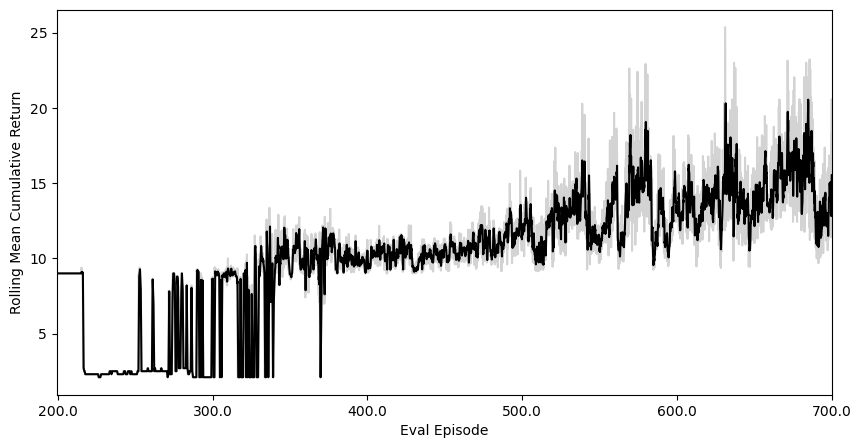

In [30]:
#Examining callback evaluation output
evaluation_log2 = np.load(eval_log_path2 + 'evaluations.npz')
evaluation_log_df = pd.DataFrame({item: [np.mean(ep) for ep in evaluation_log2[item]] for item in evaluation_log2.files})
ax = evaluation_log_df.loc[0:len(evaluation_log_df), 'results'].plot(color = 'lightgray', xlim = [-5, len(evaluation_log_df)], figsize = (10,5))
evaluation_log_df['results'].rolling(5).mean().plot(color = 'black', xlim = [-5, len(evaluation_log_df)])
ax.set_xticklabels(evaluation_log_df['timesteps'])
ax.set_xlabel("Eval Episode")
plt.ylabel("Rolling Mean Cumulative Return")
plt.show()

In [31]:
# saving agent
agent2.save("./ppo_flappy_bird_image_stack_agent")

In [32]:
#deleting old agent and envorinment to free memory
del agent2
del env2
del eval_env2

### Evaluation

In [33]:
#loading vector agent
agent = sb3.PPO.load("./ppo_flappy_bird_vector_agent")

In [34]:
#setting up evaluation envorinment for vector agent
eval_env= Monitor(gym.make('FlappyBird-v0'))

eval_env = sb3.common.vec_env.DummyVecEnv([lambda: eval_env])

In [35]:
# Evaluating the agent for 30 episode by rendering the process
agent.set_env(eval_env)
mean_reward, std_reward = sb3.common.evaluation.evaluate_policy(agent, 
                                                                agent.get_env(), 
                                                                n_eval_episodes=30)

print("Mean Reward: {} +/- {}".format(mean_reward, std_reward))

Mean Reward: 8.38 +/- 1.24


In [36]:
# playing an episode with actions selected by vector agent
obs = eval_env.reset()

terminate = False
truncate = False

cumulative_reward = 0
counter = 0

while not (terminate or truncate):
    
    action = agent.predict(obs)
    obs, reward, terminate, info = eval_env.step(action[0])
    
    eval_env.render('human')
    
    time.sleep(0.1) # Reduce the frame rate with a delay between frames
    
    cumulative_reward = cumulative_reward + reward
    counter = counter + 1

print(counter)
print(cumulative_reward)

/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:190: UserWarning: You tried to render a VecEnv with mode='human' but the render mode defined when initializing the environment must be 'human' or 'rgb_array', not 'None'.
  warnings.warn(


70
[5.899996]


In [37]:
#getting record of model complexity
for key,p in agent.get_parameters()['policy'].items():
    print(key,p.numel())
print(f"Total number of trainable parameters: {sum(p.numel()for ey,p in agent.get_parameters()['policy'].items())}")

mlp_extractor.policy_net.0.weight 768
mlp_extractor.policy_net.0.bias 64
mlp_extractor.policy_net.2.weight 4096
mlp_extractor.policy_net.2.bias 64
mlp_extractor.value_net.0.weight 768
mlp_extractor.value_net.0.bias 64
mlp_extractor.value_net.2.weight 4096
mlp_extractor.value_net.2.bias 64
action_net.weight 128
action_net.bias 2
value_net.weight 64
value_net.bias 1
Total number of trainable parameters: 10179


In [38]:
#deleting agent and envorinment to free memory
del agent
del eval_env

In [39]:
#loading image stack agent
agent = sb3.PPO.load("./ppo_flappy_bird_image_stack_agent")

In [40]:
#setting up evaluation envorinment for image stack agent
eval_env = Monitor(gym.make('FlappyBird-rgb-v0', render_mode='human'))
eval_env = gym.wrappers.resize_observation.ResizeObservation(eval_env, (64, 128))
eval_env = gym.wrappers.gray_scale_observation.GrayScaleObservation(eval_env, keep_dim = True)

eval_env = sb3.common.vec_env.DummyVecEnv([lambda: eval_env])
eval_env = sb3.common.vec_env.VecFrameStack(eval_env, n_stack=4)

/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(


In [41]:
# Evaluating the agent for 30 episode by rendering the process
agent.set_env(eval_env)
mean_reward, std_reward = sb3.common.evaluation.evaluate_policy(agent, 
                                                                agent.get_env(), 
                                                                n_eval_episodes=30)

print("Mean Reward: {} +/- {}".format(mean_reward, std_reward))

Wrapping the env in a VecTransposeImage.


/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: uint8
  logger.warn(
/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: uint8
  logger.warn(


Mean Reward: 14.97 +/- 5.433485682935649


In [42]:
# playing an episode with actions selected by image stack agent
obs = eval_env.reset()

terminate = False
truncate = False

cumulative_reward = 0
counter = 0

while not (terminate or truncate):
    
    action = agent.predict(obs)
    obs, reward, terminate, info = eval_env.step(action[0])
    
    eval_env.render('human')
    
    time.sleep(0.1) # Reduce the frame rate with a delay between frames
    
    cumulative_reward = cumulative_reward + reward
    counter = counter + 1

print(counter)
print(cumulative_reward)

137
[13.500015]


In [43]:
#getting record of model complexity
for key,p in agent.get_parameters()['policy'].items():
    print(key,p.numel())
print(f"Total number of trainable parameters: {sum(p.numel()for ey,p in agent.get_parameters()['policy'].items())}")

features_extractor.cnn.0.weight 8192
features_extractor.cnn.0.bias 32
features_extractor.cnn.2.weight 32768
features_extractor.cnn.2.bias 64
features_extractor.cnn.4.weight 36864
features_extractor.cnn.4.bias 64
features_extractor.linear.0.weight 1572864
features_extractor.linear.0.bias 512
pi_features_extractor.cnn.0.weight 8192
pi_features_extractor.cnn.0.bias 32
pi_features_extractor.cnn.2.weight 32768
pi_features_extractor.cnn.2.bias 64
pi_features_extractor.cnn.4.weight 36864
pi_features_extractor.cnn.4.bias 64
pi_features_extractor.linear.0.weight 1572864
pi_features_extractor.linear.0.bias 512
vf_features_extractor.cnn.0.weight 8192
vf_features_extractor.cnn.0.bias 32
vf_features_extractor.cnn.2.weight 32768
vf_features_extractor.cnn.2.bias 64
vf_features_extractor.cnn.4.weight 36864
vf_features_extractor.cnn.4.bias 64
vf_features_extractor.linear.0.weight 1572864
vf_features_extractor.linear.0.bias 512
action_net.weight 1024
action_net.bias 2
value_net.weight 512
value_net.bias

### Summary

        In this assignment I used actor critic algorithm with (PPO) proximal policy optimisation to create the network to train a vector agent and a Image stack agent to play flappy bird game. 
        To train the vector agent; vector based observations used observations was vectors of lenght 12. Model consisted of actor and critic networks with 2 flattening extractor layers and fully connected network layer.  Total count of weights and biases at vector agent model was 10,179. During training model performance begin to improve and mean reward per episode stablise above 9 point after 230,000 timesteps. After training for  500,000 timesteps models performance evaluated for 30 episode and agent scored 10.67 mean award with  +/- 2.58 std_deviation. 
        To train image stack agent; RBG image based observations used. Images resized to 64x128, then converted to grayscale and stacked to 4 so that observation of agent would consisted of last 4 frame.   Model consisted of 3 convolution extractor layer connected to network layer shared between actor and critic networks and 3 convolution layer special to actor net connected to a network layer and 3 convolution layer special to critic net connected to a network layer and fully connected network layers of actor and critic networks. Total count of weights and biases at image stack agent model was 4,955,619.  During training model performance begin to improve and mean reward per episode stablise above 9 point after 230,000 timesteps just like with vector agent. After training for  500,000 timesteps models performance evaluated for 30 episode and agent scored 11.83 mean award with  +/- 2.66 std_deviation. 
        Both agent had similar performance in game but training image stack agent took much longer. The reason was because, image stack agent had much more trainable parameter. Reducing image size and stacking of image stack agent model would reduce number of trainable parameter and speed up training at the cost of losing in game performance. Unfortunately both models was undertrained even after 500,000 timesteps, ingame performance could be improved with more training.